In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
!pip install lime==0.2.0.1
!pip install shap==0.35.0
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "production"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 20

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"],# "sepsis_cases_2", "sepsis_cases_4"]
    "production" : ["production"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['production']

Bucket 1
Generating distributions for bucket
1 of 100 features
2 of 100 features
3 of 100 features
4 of 100 features
5 of 100 features
6 of 100 features
7 of 100 features
8 of 100 features
9 of 100 features
10 of 100 features
11 of 100 features
12 of 100 features
13 of 100 features
14 of 100 features
15 of 100 features
16 of 100 features
17 of 100 features
18 of 100 features
19 of 100 features
20 of 100 features
21 of 100 features
22 of 100 features
23 of 100 features
24 of 100 features
25 of 100 features
26 of 100 features
27 of 100 features
28 of 100 features
29 of 100 features
30 of 100 features
31 of 100 features
32 of 100 features
33 of 100 features
34 of 100 features
35 of 100 features
36 of 100 features
37 of 100 features
38 of 100 features
39 of 100 features
40 of 100 features
41 of 100 features
42 of 100 features
43 of 100 features
44 of 100 features
45 of 100 features
46 of 100 features
47 of 100 features
48 of 100 features
49 of 100 features
50 of 100 features
51 of 100 feat

Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 10
Creating explanations
[('static__Work_Order_Qty', -0.7516501, 0.7516501), ('index__Resource_0_ID4529', -0.2987308, 0.2987308), ('static__Part_Desc__Cable Head', 0.26917207, 0.26917207), ('index__month_0', -0.26098382, 0.26098382), ('index__hour_0', -0.25301528, 0.25301528), ('index__timesincemidnight_0', -0.16672239, 0.16672239), ('index__Resource.1_0_Machine 5 - Turning & Milling', 0.16140343, 0.16140343), ('index__Report_Type_0_S', -0.13463432, 0.13463432), ('index__activity_duration_0', -0.13402915, 0.13402915), ('static__Part_Desc__Spur Gear', 0.12746699, 0.12746699)]
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for 

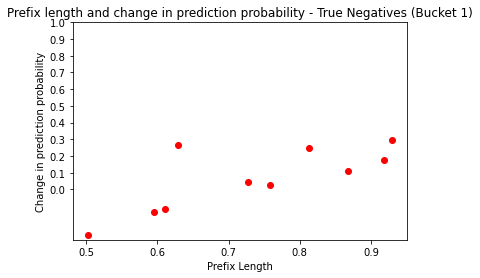

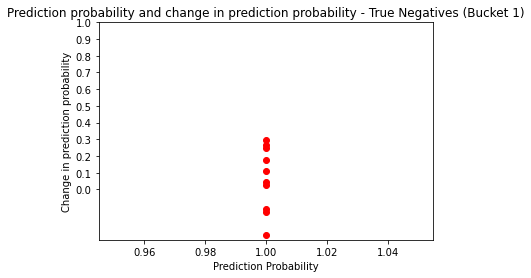

Category 2 of 4. Instance 1 of 10
Creating explanations
[('static__Work_Order_Qty', 0.8114623, 0.8114623), ('index__weekday_0', 0.31191128, 0.31191128), ('index__Resource_0_ID4529', -0.2987308, 0.2987308), ('index__month_0', -0.26098382, 0.26098382), ('index__hour_0', -0.25301528, 0.25301528), ('static__Part_Desc__Ballnut', -0.2089537, 0.2089537), ('index__open_cases_0', 0.1861022, 0.1861022), ('index__timesincemidnight_0', -0.16672239, 0.16672239), ('index__Report_Type_0_S', -0.13463432, 0.13463432), ('static__Part_Desc__Spur Gear', 0.117505684, 0.117505684)]
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for

Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 8 of 10
Creating explanations
[('static__Work_Order_Qty', 1.1866233, 1.1866233), ('index__open_cases_0', 0.55128825, 0.55128825), ('index__Resource_0_ID4429', -0.33643982, 0.33643982), ('index__month_0', -0.26098382, 0.26098382), ('index__weekday_0', 0.19417226, 0.19417226), ('index__hour_0', 0.17983833, 0.17983833), ('index__Resource.1_0_Machine 5 - Turning & Milling', 0.16140343, 0.16140343), ('index__Report_Type_0_S', -0.13463432, 0.13463432), ('index__timesincemidnight_0', 0.12817204, 0.12817204), ('static__Part_Desc__Spur Gear', 0.12746699, 0.12746699)]
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creati

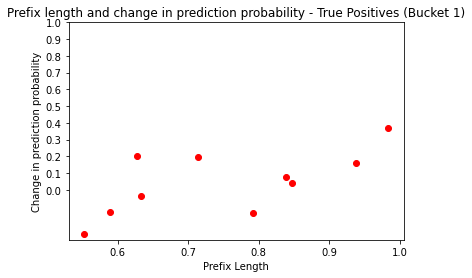

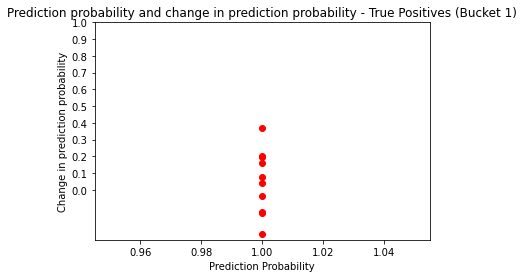

Category 3 of 4. Instance 1 of 8
Creating explanations
[('static__Work_Order_Qty', -0.83392024, 0.83392024), ('index__open_cases_0', 0.46948114, 0.46948114), ('index__month_0', -0.26098382, 0.26098382), ('index__timesincemidnight_0', 0.23215583, 0.23215583), ('static__Part_Desc__Ballnut', -0.2089537, 0.2089537), ('index__hour_0', 0.19999558, 0.19999558), ('index__weekday_0', 0.18226399, 0.18226399), ('index__activity_duration_0', 0.14961153, 0.14961153), ('index__Report_Type_0_S', -0.13079834, 0.13079834), ('index__Qty_Completed_0', -0.117539674, 0.117539674)]
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for

Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


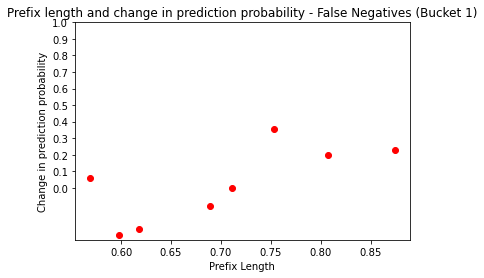

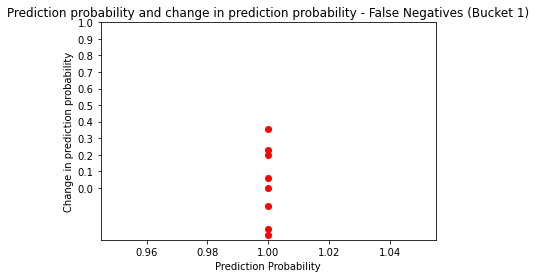

Category 4 of 4. Instance 1 of 8
Creating explanations
[('index__Activity_0_Round Grinding - Q.C.', 0.40431452, 0.40431452), ('index__weekday_0', -0.37109035, 0.37109035), ('static__Part_Desc__Cable Head', 0.26917207, 0.26917207), ('index__month_0', -0.26098382, 0.26098382), ('index__Report_Type_0_S', 0.22807129, 0.22807129), ('index__open_cases_0', 0.18504198, 0.18504198), ('index__activity_duration_0', -0.18417168, 0.18417168), ('index__Qty_Completed_0', -0.16987893, 0.16987893), ('index__hour_0', -0.14810131, 0.14810131), ('static__Work_Order_Qty', -0.1284931, 0.1284931)]
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating d

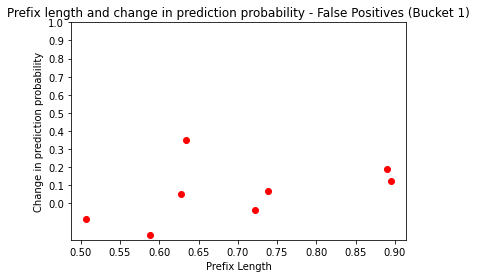

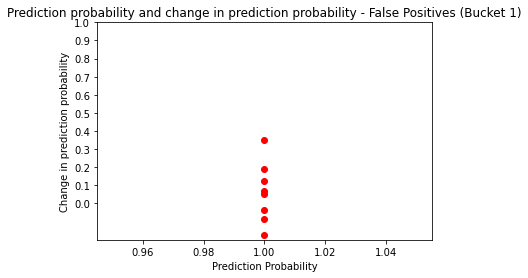

Bucket 2
Generating distributions for bucket
1 of 173 features
2 of 173 features
3 of 173 features
4 of 173 features
5 of 173 features
6 of 173 features
7 of 173 features
8 of 173 features
9 of 173 features
10 of 173 features
11 of 173 features
12 of 173 features
13 of 173 features
14 of 173 features
15 of 173 features
16 of 173 features
17 of 173 features
18 of 173 features
19 of 173 features
20 of 173 features
21 of 173 features
22 of 173 features
23 of 173 features
24 of 173 features
25 of 173 features
26 of 173 features
27 of 173 features
28 of 173 features
29 of 173 features
30 of 173 features
31 of 173 features
32 of 173 features
33 of 173 features
34 of 173 features
35 of 173 features
36 of 173 features
37 of 173 features
38 of 173 features
39 of 173 features
40 of 173 features
41 of 173 features
42 of 173 features
43 of 173 features
44 of 173 features
45 of 173 features
46 of 173 features
47 of 173 features
48 of 173 features
49 of 173 features
50 of 173 features
51 of 173 feat

Creating explanations
[('index__weekday_0', -0.74020624, 0.74020624), ('index__timesincelastevent_1', -0.5516704, 0.5516704), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.52066916, 0.52066916), ('index__Resource.1_1_Machine 4 - Turning & Milling', 0.50876397, 0.50876397), ('index__timesincecasestart_1', 0.3987543, 0.3987543), ('static__Work_Order_Qty', -0.3562486, 0.3562486), ('index__activity_duration_0', -0.3518511, 0.3518511), ('index__Resource_1_ID4932', 0.32347834, 0.32347834), ('index__Resource_0_ID4167', 0.27741277, 0.27741277), ('index__Activity_1_other', -0.2392831, 0.2392831), ('index__timesincemidnight_0', -0.2274632, 0.2274632), ('static__Part_Desc__Bearing', 0.21311349, 0.21311349), ('index__activity_duration_1', -0.20120814, 0.20120814), ('index__month_0', -0.18564792, 0.18564792), ('index__weekday_1', -0.18011025, 0.18011025), ('index__Activity_0_Turning & Milling - Machine 4', 0.17668271, 0.17668271), ('index__hour_1', -0.1508249, 0.1508249)]
Identifying rele

[('index__timesincelastevent_1', 0.76858217, 0.76858217), ('index__timesincemidnight_0', -0.5626422, 0.5626422), ('index__Resource.1_1_Quality Check 1', -0.33130345, 0.33130345), ('index__activity_duration_0', -0.3073638, 0.3073638), ('index__Activity_0_Packing', -0.29966104, 0.29966104), ('index__timesincemidnight_1', -0.29444227, 0.29444227), ('index__timesincecasestart_1', 0.2619631, 0.2619631), ('index__open_cases_1', -0.25960478, 0.25960478), ('index__open_cases_0', -0.24224927, 0.24224927), ('static__Part_Desc__Cable Head', 0.24047224, 0.24047224), ('static__Work_Order_Qty', -0.22691181, 0.22691181), ('index__Qty_Completed_0', -0.22421978, 0.22421978), ('index__Report_Type_0_D', 0.21655248, 0.21655248), ('index__month_0', -0.19977543, 0.19977543), ('index__weekday_1', -0.17506972, 0.17506972), ('index__Qty_Completed_1', -0.14119239, 0.14119239), ('index__Resource.1_0_Packing', -0.12706466, 0.12706466)]
Identifying relevant features
Creating distribution for feature 1 of 17
Creati

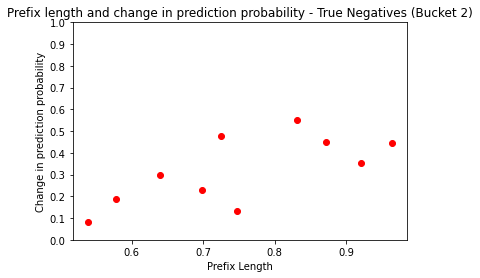

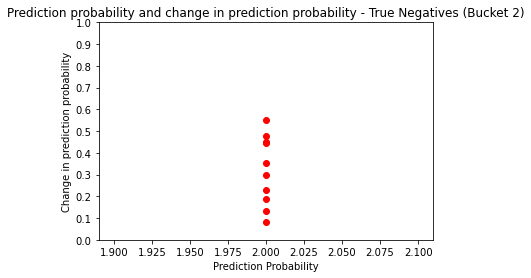

Category 2 of 4. Instance 1 of 10
Creating explanations
[('index__timesincemidnight_0', -0.5341561, 0.5341561), ('index__Resource_0_ID4641', 0.46976417, 0.46976417), ('index__Activity_0_Turning & Milling - Machine 9', 0.4459701, 0.4459701), ('static__Work_Order_Qty', 0.42707163, 0.42707163), ('index__hour_1', -0.39002195, 0.39002195), ('static__Part_Desc__Ballnut', -0.37888935, 0.37888935), ('index__open_cases_1', -0.3389965, 0.3389965), ('index__open_cases_0', 0.3078077, 0.3078077), ('index__month_0', -0.22310852, 0.22310852), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0.18339024, 0.18339024), ('index__weekday_0', 0.16840641, 0.16840641), ('static__Part_Desc__Spur Gear', 0.14280917, 0.14280917), ('index__Resource.1_0_Machine 9 - Turning & Milling', 0.12956071, 0.12956071), ('index__Qty_Completed_1', -0.12738311, 0.12738311), ('index__Report_Type_1_S', 0.11791849, 0.11791849), ('index__timesincemidnight_1', 0.10662037, 0.10662037), ('index__Report_Type_0_D', -0.10531592, 0.

Creating distribution for feature 1 of 17
Creating distribution for feature 2 of 17
Creating distribution for feature 3 of 17
Creating distribution for feature 4 of 17
Creating distribution for feature 5 of 17
Creating distribution for feature 6 of 17
Creating distribution for feature 7 of 17
Creating distribution for feature 8 of 17
Creating distribution for feature 9 of 17
Creating distribution for feature 10 of 17
Creating distribution for feature 11 of 17
Creating distribution for feature 12 of 17
Creating distribution for feature 13 of 17
Creating distribution for feature 14 of 17
Creating distribution for feature 15 of 17
Creating distribution for feature 16 of 17
Creating distribution for feature 17 of 17
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 6 of 10
Creating explanations
[('index__timesincelastevent_1', 0.512603

[('index__Resource_1_ID4641', 0.788115, 0.788115), ('index__timesincelastevent_1', 0.6459897, 0.6459897), ('index__activity_duration_0', 0.58917004, 0.58917004), ('index__open_cases_0', 0.5299221, 0.5299221), ('index__Activity_0_Turning & Milling - Machine 9', 0.4459701, 0.4459701), ('index__Resource_0_ID4641', 0.43595642, 0.43595642), ('index__hour_1', 0.43298554, 0.43298554), ('static__Work_Order_Qty', 0.42707163, 0.42707163), ('index__open_cases_1', -0.31504172, 0.31504172), ('index__Qty_Completed_1', -0.2980889, 0.2980889), ('index__timesincemidnight_1', 0.2611418, 0.2611418), ('index__month_0', -0.22102894, 0.22102894), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0.15355766, 0.15355766), ('static__Part_Desc__Spur Gear', 0.14886253, 0.14886253), ('index__Resource.1_0_Machine 9 - Turning & Milling', 0.12956071, 0.12956071), ('index__timesincemidnight_0', -0.123546675, 0.123546675), ('index__Qty_Completed_0', 0.11786928, 0.11786928)]
Identifying relevant features
Creating 

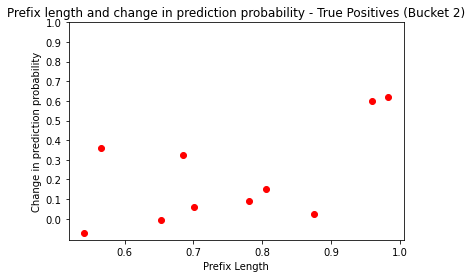

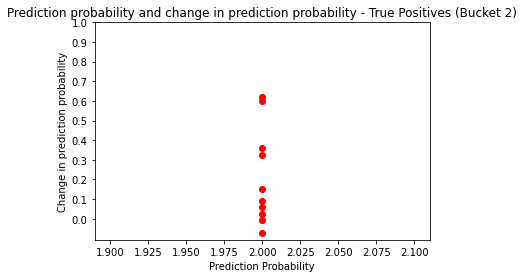

Category 3 of 4. Instance 1 of 8
Creating explanations
[('index__timesincemidnight_0', -0.5858151, 0.5858151), ('index__Qty_Completed_1', 0.39749336, 0.39749336), ('index__open_cases_1', -0.36418572, 0.36418572), ('index__Resource_0_ID4429', -0.36328328, 0.36328328), ('index__weekday_1', 0.35593578, 0.35593578), ('static__Work_Order_Qty', -0.25047046, 0.25047046), ('index__timesincecasestart_1', 0.245269, 0.245269), ('static__Part_Desc__Cable Head', 0.23121575, 0.23121575), ('index__Resource_1_ID4167', 0.22952923, 0.22952923), ('index__hour_1', -0.20931053, 0.20931053), ('index__open_cases_0', 0.17412008, 0.17412008), ('index__Activity_1_Turning & Milling - Machine 5', 0.16319823, 0.16319823), ('index__hour_0', 0.14261325, 0.14261325), ('index__activity_duration_0', -0.14191514, 0.14191514), ('static__Part_Desc__Spur Gear', 0.13218418, 0.13218418), ('index__Qty_Completed_0', -0.12140496, 0.12140496), ('index__timesincelastevent_1', 0.11917994, 0.11917994)]
Identifying relevant features

[('index__timesincemidnight_1', 0.64909273, 0.64909273), ('index__Activity_1_Turning & Milling - Machine 8', -0.45750913, 0.45750913), ('static__Part_Desc__Spur Gear', -0.4165837, 0.4165837), ('index__Activity_0_Turning & Milling - Machine 8', -0.3463688, 0.3463688), ('index__Resource_0_ID4219', -0.33095455, 0.33095455), ('index__timesincecasestart_1', 0.32386518, 0.32386518), ('index__Resource_1_ID4219', -0.26953614, 0.26953614), ('index__Resource.1_0_Machine 8 - Turning & Milling', -0.22316703, 0.22316703), ('index__open_cases_1', -0.21864493, 0.21864493), ('index__activity_duration_1', 0.21293572, 0.21293572), ('index__month_0', -0.21225904, 0.21225904), ('index__hour_1', 0.21174474, 0.21174474), ('index__activity_duration_0', 0.1964613, 0.1964613), ('index__timesincelastevent_1', 0.17488973, 0.17488973), ('static__Work_Order_Qty', 0.15222193, 0.15222193), ('index__Report_Type_1_S', 0.14838962, 0.14838962), ('index__timesincemidnight_0', -0.11982225, 0.11982225)]
Identifying relevan

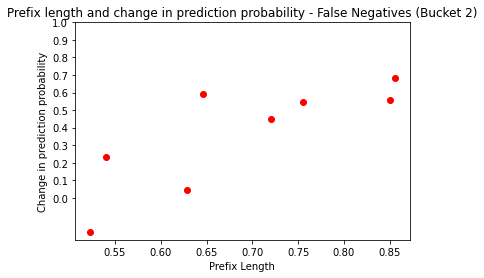

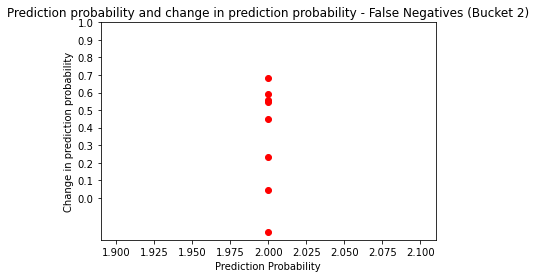

Category 4 of 4. Instance 1 of 8
Creating explanations
[('index__timesincemidnight_1', 0.5244302, 0.5244302), ('index__timesincecasestart_1', -0.47991592, 0.47991592), ('index__timesincelastevent_1', -0.40406397, 0.40406397), ('static__Part_Desc__Ballnut', -0.37888935, 0.37888935), ('static__Work_Order_Qty', 0.37554562, 0.37554562), ('index__weekday_0', 0.3655576, 0.3655576), ('index__timesincemidnight_0', 0.35297728, 0.35297728), ('index__activity_duration_1', -0.3224988, 0.3224988), ('index__Resource.1_1_Machine 7- Laser Marking', 0.25411606, 0.25411606), ('index__open_cases_1', -0.23713857, 0.23713857), ('index__open_cases_0', -0.21825883, 0.21825883), ('index__Report_Type_0_D', 0.20863175, 0.20863175), ('index__Resource.1_0_Quality Check 1', 0.20203686, 0.20203686), ('index__Activity_1_Laser Marking - Machine 7', 0.19454694, 0.19454694), ('index__weekday_1', -0.19110511, 0.19110511), ('index__hour_0', 0.16773723, 0.16773723), ('static__Part_Desc__Spur Gear', 0.12930068, 0.12930068)

[('index__Resource_1_ID4641', 0.7646122, 0.7646122), ('index__timesincemidnight_1', 0.5329076, 0.5329076), ('index__weekday_1', -0.4711231, 0.4711231), ('index__Resource_0_ID4641', 0.4703523, 0.4703523), ('static__Part_Desc__Spur Gear', -0.44598237, 0.44598237), ('index__Resource.1_1_Machine 10 - Grinding', 0.43141785, 0.43141785), ('index__timesincecasestart_1', 0.38353434, 0.38353434), ('index__timesincemidnight_0', 0.36906198, 0.36906198), ('index__open_cases_1', -0.3083513, 0.3083513), ('index__Qty_Completed_0', -0.3049926, 0.3049926), ('index__Activity_1_Turning & Milling - Machine 10', 0.2525763, 0.2525763), ('index__hour_0', 0.23435253, 0.23435253), ('index__activity_duration_1', 0.23085363, 0.23085363), ('index__open_cases_0', 0.21902815, 0.21902815), ('index__Qty_Completed_1', -0.21539758, 0.21539758), ('index__month_0', -0.21278867, 0.21278867), ('index__timesincelastevent_1', 0.20674086, 0.20674086)]
Identifying relevant features
Creating distribution for feature 1 of 17
Cre

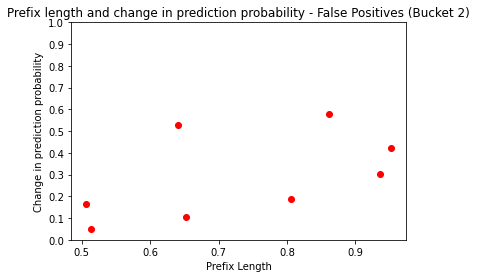

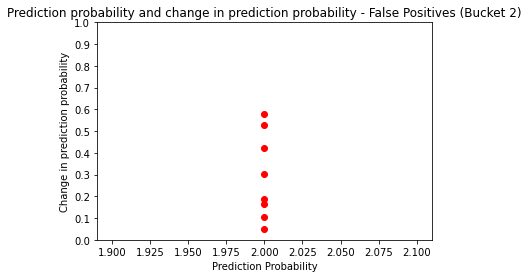

Bucket 3
Generating distributions for bucket
1 of 250 features
2 of 250 features
3 of 250 features
4 of 250 features
5 of 250 features
6 of 250 features
7 of 250 features
8 of 250 features
9 of 250 features
10 of 250 features
11 of 250 features
12 of 250 features
13 of 250 features
14 of 250 features
15 of 250 features
16 of 250 features
17 of 250 features
18 of 250 features
19 of 250 features
20 of 250 features
21 of 250 features
22 of 250 features
23 of 250 features
24 of 250 features
25 of 250 features
26 of 250 features
27 of 250 features
28 of 250 features
29 of 250 features
30 of 250 features
31 of 250 features
32 of 250 features
33 of 250 features
34 of 250 features
35 of 250 features
36 of 250 features
37 of 250 features
38 of 250 features
39 of 250 features
40 of 250 features
41 of 250 features
42 of 250 features
43 of 250 features
44 of 250 features
45 of 250 features
46 of 250 features
47 of 250 features
48 of 250 features
49 of 250 features
50 of 250 features
51 of 250 feat

Creating explanations
[('index__timesincemidnight_1', 0.82972735, 0.82972735), ('index__timesincecasestart_2', -0.64106166, 0.64106166), ('index__hour_1', 0.57, 0.57), ('index__timesincelastevent_1', 0.46182084, 0.46182084), ('static__Work_Order_Qty', -0.4422627, 0.4422627), ('index__hour_2', -0.38489473, 0.38489473), ('static__Part_Desc__Ballnut', -0.3798834, 0.3798834), ('index__timesincemidnight_2', -0.33460084, 0.33460084), ('index__open_cases_0', 0.2833713, 0.2833713), ('index__Resource_1_ID4529', 0.25378293, 0.25378293), ('index__Resource_0_ID4219', -0.24135593, 0.24135593), ('index__activity_duration_1', 0.228089, 0.228089), ('index__timesincemidnight_0', -0.21623187, 0.21623187), ('index__weekday_2', -0.20294327, 0.20294327), ('index__Activity_1_Turning & Milling - Machine 8', -0.1958461, 0.1958461), ('index__Qty_Completed_1', -0.19529492, 0.19529492), ('index__timesincelastevent_2', 0.18878199, 0.18878199), ('index__timesincecasestart_1', 0.18177982, 0.18177982), ('index__Reso

Creating explanations
[('index__activity_duration_0', -0.52726763, 0.52726763), ('index__timesincemidnight_1', -0.39875206, 0.39875206), ('index__timesincecasestart_2', -0.36793312, 0.36793312), ('static__Part_Desc__Ballnut', -0.34987256, 0.34987256), ('index__Resource_1_ID4287', -0.26945376, 0.26945376), ('static__Work_Order_Qty', 0.24714072, 0.24714072), ('index__open_cases_1', -0.24408683, 0.24408683), ('index__weekday_0', -0.23681226, 0.23681226), ('index__Report_Type_0_S', 0.23626801, 0.23626801), ('index__timesincemidnight_0', 0.21659625, 0.21659625), ('index__Resource_0_ID4287', -0.19803445, 0.19803445), ('index__activity_duration_1', 0.18109176, 0.18109176), ('index__hour_2', 0.16331618, 0.16331618), ('index__open_cases_2', 0.14482786, 0.14482786), ('static__Part_Desc__Cable Head', -0.12898484, 0.12898484), ('index__timesincelastevent_1', 0.12156848, 0.12156848), ('index__Resource_2_ID4882', 0.10997802, 0.10997802), ('index__Report_Type_1_D', -0.10949821, 0.10949821), ('index__

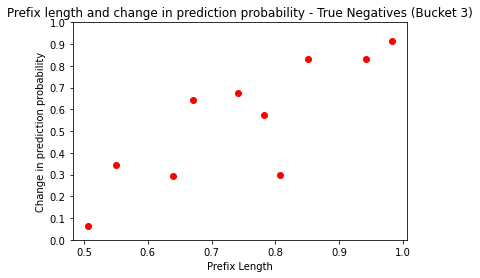

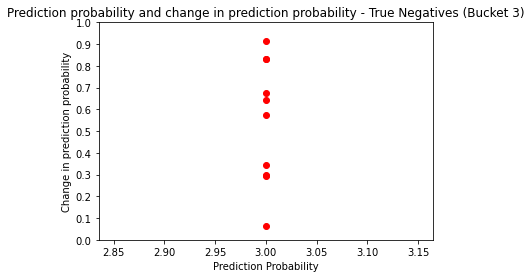

Category 2 of 4. Instance 1 of 10
Creating explanations
[('static__Work_Order_Qty', 0.5152296, 0.5152296), ('index__timesincemidnight_1', -0.4396988, 0.4396988), ('static__Part_Desc__Ballnut', -0.41641742, 0.41641742), ('index__hour_0', 0.36350307, 0.36350307), ('index__timesincecasestart_2', 0.33597684, 0.33597684), ('index__activity_duration_0', 0.3317014, 0.3317014), ('index__open_cases_2', -0.2560289, 0.2560289), ('index__Activity_2_Turning & Milling - Machine 9', 0.20521438, 0.20521438), ('index__open_cases_0', -0.18164892, 0.18164892), ('index__weekday_2', -0.17947786, 0.17947786), ('index__activity_duration_1', 0.1677128, 0.1677128), ('index__Report_Type_2_S', 0.16528344, 0.16528344), ('index__hour_1', -0.1633105, 0.1633105), ('index__Report_Type_0_S', -0.15908046, 0.15908046), ('index__hour_2', 0.15713774, 0.15713774), ('index__weekday_0', -0.15430345, 0.15430345), ('index__activity_duration_2', 0.14243862, 0.14243862), ('index__Report_Type_1_D', 0.1414381, 0.1414381), ('static

Creating explanations
[('index__timesincelastevent_1', 0.46182084, 0.46182084), ('static__Part_Desc__Cable Head', 0.46054175, 0.46054175), ('index__Resource.1_0_Machine 5 - Turning & Milling', -0.3436579, 0.3436579), ('index__timesincecasestart_2', 0.2752305, 0.2752305), ('index__weekday_0', -0.24904604, 0.24904604), ('index__timesincemidnight_0', -0.22290398, 0.22290398), ('index__timesincemidnight_1', 0.21932638, 0.21932638), ('index__hour_1', 0.21324736, 0.21324736), ('index__activity_duration_2', -0.20247805, 0.20247805), ('index__open_cases_1', -0.18641196, 0.18641196), ('index__open_cases_0', 0.1848062, 0.1848062), ('index__weekday_2', 0.18043676, 0.18043676), ('index__weekday_1', -0.17599331, 0.17599331), ('index__Activity_0_Turning & Milling - Machine 5', -0.17308125, 0.17308125), ('static__Work_Order_Qty', -0.14337622, 0.14337622), ('index__Qty_Completed_0', 0.14325134, 0.14325134), ('index__hour_2', 0.13915306, 0.13915306), ('index__Report_Type_1_D', 0.13812798, 0.13812798), 

Creating explanations
[('index__activity_duration_0', 0.6206983, 0.6206983), ('static__Work_Order_Qty', 0.5206365, 0.5206365), ('index__timesincelastevent_1', 0.46182084, 0.46182084), ('index__Qty_Completed_1', -0.37144926, 0.37144926), ('index__timesincemidnight_2', 0.28295392, 0.28295392), ('index__timesincelastevent_2', -0.27409983, 0.27409983), ('index__open_cases_0', 0.2591887, 0.2591887), ('index__weekday_0', 0.25692296, 0.25692296), ('index__Resource_1_ID4641', 0.24369338, 0.24369338), ('index__Activity_2_Turning & Milling - Machine 9', 0.23256618, 0.23256618), ('index__timesincecasestart_2', -0.1933012, 0.1933012), ('index__hour_1', 0.1911839, 0.1911839), ('index__open_cases_1', -0.18000138, 0.18000138), ('index__hour_2', 0.17869721, 0.17869721), ('index__activity_duration_2', -0.16699596, 0.16699596), ('index__Report_Type_2_S', 0.16528344, 0.16528344), ('index__Resource_2_ID4641', 0.13880418, 0.13880418), ('index__weekday_1', -0.13055083, 0.13055083), ('static__Part_Desc__Cabl

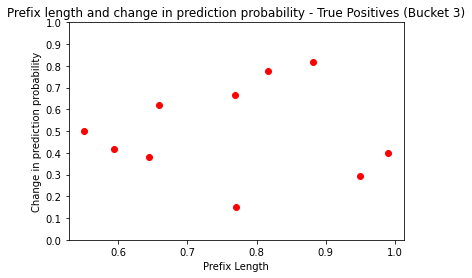

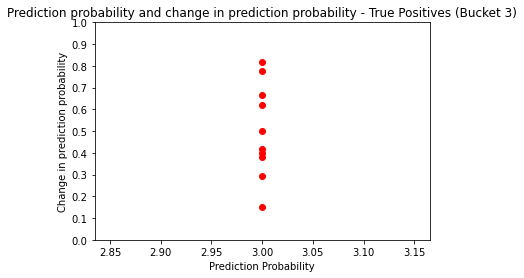

Category 3 of 4. Instance 1 of 10
Creating explanations
[('index__timesincecasestart_2', 0.45040274, 0.45040274), ('index__timesincemidnight_1', 0.34504628, 0.34504628), ('static__Work_Order_Qty', -0.29436052, 0.29436052), ('index__timesincelastevent_2', -0.2807705, 0.2807705), ('index__Resource_1_ID4529', 0.2466412, 0.2466412), ('index__hour_1', 0.24487118, 0.24487118), ('index__open_cases_1', -0.2394812, 0.2394812), ('index__open_cases_2', -0.23867959, 0.23867959), ('index__Qty_Completed_2', 0.22542244, 0.22542244), ('index__timesincemidnight_2', 0.20866627, 0.20866627), ('index__activity_duration_0', -0.20626895, 0.20626895), ('index__hour_2', 0.1889871, 0.1889871), ('index__open_cases_0', -0.17325409, 0.17325409), ('index__Report_Type_1_D', 0.15524974, 0.15524974), ('index__hour_0', -0.15384795, 0.15384795), ('index__Qty_Completed_0', -0.14042293, 0.14042293), ('index__timesincemidnight_0', -0.12637842, 0.12637842), ('static__Part_Desc__Spur Gear', -0.12567088, 0.12567088), ('index

Creating explanations
[('index__timesincemidnight_1', -0.44146731, 0.44146731), ('static__Work_Order_Qty', -0.4260382, 0.4260382), ('index__activity_duration_0', -0.3391493, 0.3391493), ('index__hour_2', 0.26878142, 0.26878142), ('index__timesincelastevent_2', 0.25661156, 0.25661156), ('index__open_cases_1', -0.25396517, 0.25396517), ('index__weekday_0', 0.25077054, 0.25077054), ('index__Resource_1_ID4219', -0.21230747, 0.21230747), ('index__weekday_1', 0.20963778, 0.20963778), ('index__open_cases_2', -0.20491573, 0.20491573), ('index__hour_0', -0.20241651, 0.20241651), ('index__timesincemidnight_2', 0.17075594, 0.17075594), ('index__Report_Type_1_D', 0.14949845, 0.14949845), ('index__Report_Type_0_S', -0.1337879, 0.1337879), ('index__timesincelastevent_1', -0.12910412, 0.12910412), ('static__Part_Desc__Ballnut', 0.11311299, 0.11311299), ('static__Part_Desc__Cable Head', -0.112660766, 0.112660766), ('index__timesincemidnight_0', -0.09584741, 0.09584741), ('index__Resource.1_2_Quality C

Creating explanations
[('index__timesincemidnight_1', -0.7477179, 0.7477179), ('index__hour_1', -0.72560644, 0.72560644), ('index__timesincemidnight_2', -0.45395172, 0.45395172), ('index__hour_2', -0.40458268, 0.40458268), ('static__Part_Desc__Ballnut', -0.39243525, 0.39243525), ('index__activity_duration_1', -0.3845724, 0.3845724), ('index__open_cases_0', 0.21594143, 0.21594143), ('index__timesincelastevent_2', 0.20779935, 0.20779935), ('index__weekday_0', 0.17146298, 0.17146298), ('index__Report_Type_2_S', 0.16528344, 0.16528344), ('index__timesincecasestart_1', -0.16343763, 0.16343763), ('index__weekday_1', 0.14632693, 0.14632693), ('index__activity_duration_2', 0.14213313, 0.14213313), ('static__Part_Desc__Cable Head', -0.14154164, 0.14154164), ('index__open_cases_2', 0.14053868, 0.14053868), ('index__Report_Type_0_S', -0.13742211, 0.13742211), ('index__Report_Type_1_D', -0.13623084, 0.13623084), ('index__Qty_Completed_2', 0.12797372, 0.12797372), ('index__activity_duration_0', -0.

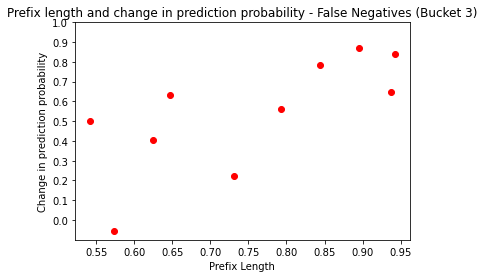

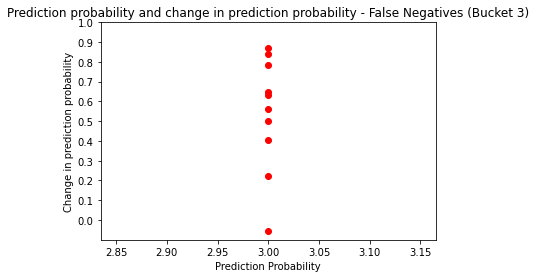

Category 4 of 4. Instance 1 of 10
Creating explanations
[('index__timesincecasestart_2', -0.60638463, 0.60638463), ('index__timesincemidnight_1', 0.4612722, 0.4612722), ('index__timesincelastevent_2', -0.33044615, 0.33044615), ('index__timesincemidnight_2', 0.31551212, 0.31551212), ('index__hour_1', 0.2892006, 0.2892006), ('index__activity_duration_1', -0.24611604, 0.24611604), ('index__timesincelastevent_1', -0.24610753, 0.24610753), ('index__hour_2', 0.22894235, 0.22894235), ('index__open_cases_2', -0.2258201, 0.2258201), ('static__Work_Order_Qty', 0.21899319, 0.21899319), ('index__weekday_1', 0.18807977, 0.18807977), ('index__open_cases_0', -0.18775354, 0.18775354), ('index__hour_0', -0.18592015, 0.18592015), ('index__weekday_2', -0.17990166, 0.17990166), ('index__Report_Type_2_S', 0.16528344, 0.16528344), ('index__open_cases_1', -0.15352844, 0.15352844), ('index__Activity_2_Turning & Milling - Machine 10', -0.15174888, 0.15174888), ('index__Report_Type_1_D', 0.14801377, 0.14801377)

Creating explanations
[('index__timesincemidnight_1', 0.8280115, 0.8280115), ('static__Work_Order_Qty', 0.62357366, 0.62357366), ('index__timesincecasestart_2', 0.4652617, 0.4652617), ('index__timesincelastevent_1', 0.46182084, 0.46182084), ('static__Part_Desc__Ballnut', -0.41210192, 0.41210192), ('index__hour_1', 0.3711216, 0.3711216), ('index__timesincemidnight_2', -0.31480289, 0.31480289), ('index__open_cases_2', 0.29143333, 0.29143333), ('index__Resource.1_2_Quality Check 1', -0.26333264, 0.26333264), ('index__timesincelastevent_2', 0.25641313, 0.25641313), ('index__open_cases_1', -0.23907708, 0.23907708), ('index__activity_duration_2', -0.23729119, 0.23729119), ('index__Qty_Completed_1', -0.17469431, 0.17469431), ('index__Resource_1_ID4794', 0.16897535, 0.16897535), ('index__hour_2', -0.15459608, 0.15459608), ('static__Part_Desc__Cable Head', -0.1319644, 0.1319644), ('index__weekday_0', -0.1298337, 0.1298337), ('index__Report_Type_1_D', -0.12759618, 0.12759618), ('index__weekday_2

Creating explanations
[('index__timesincecasestart_2', 0.7030647, 0.7030647), ('index__timesincelastevent_1', 0.46182084, 0.46182084), ('index__timesincelastevent_2', 0.43200395, 0.43200395), ('static__Work_Order_Qty', -0.37961575, 0.37961575), ('static__Part_Desc__Cable Head', 0.27677912, 0.27677912), ('index__weekday_0', 0.2623374, 0.2623374), ('index__Resource.1_0_Machine 5 - Turning & Milling', -0.24844506, 0.24844506), ('index__timesincecasestart_1', 0.21425934, 0.21425934), ('index__hour_1', 0.20846537, 0.20846537), ('index__open_cases_1', -0.19021863, 0.19021863), ('index__open_cases_2', -0.18691997, 0.18691997), ('index__timesincemidnight_0', 0.18127652, 0.18127652), ('index__Activity_0_Turning & Milling - Machine 5', -0.17308125, 0.17308125), ('index__activity_duration_1', 0.17019741, 0.17019741), ('index__month_0', -0.16157049, 0.16157049), ('index__timesincemidnight_1', 0.15987699, 0.15987699), ('index__open_cases_0', -0.15722293, 0.15722293), ('index__hour_2', 0.15122762, 0

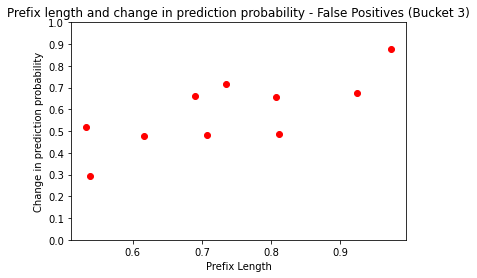

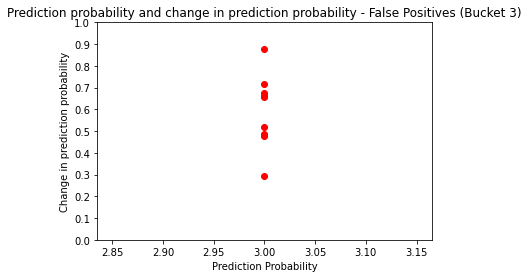

Bucket 4
Generating distributions for bucket
1 of 324 features
2 of 324 features
3 of 324 features
4 of 324 features
5 of 324 features
6 of 324 features
7 of 324 features
8 of 324 features
9 of 324 features
10 of 324 features
11 of 324 features
12 of 324 features
13 of 324 features
14 of 324 features
15 of 324 features
16 of 324 features
17 of 324 features
18 of 324 features
19 of 324 features
20 of 324 features
21 of 324 features
22 of 324 features
23 of 324 features
24 of 324 features
25 of 324 features
26 of 324 features
27 of 324 features
28 of 324 features
29 of 324 features
30 of 324 features
31 of 324 features
32 of 324 features
33 of 324 features
34 of 324 features
35 of 324 features
36 of 324 features
37 of 324 features
38 of 324 features
39 of 324 features
40 of 324 features
41 of 324 features
42 of 324 features
43 of 324 features
44 of 324 features
45 of 324 features
46 of 324 features
47 of 324 features
48 of 324 features
49 of 324 features
50 of 324 features
51 of 324 feat

Creating explanations
[('index__Activity_0_Turning & Milling - Machine 4', 0.42508483, 0.42508483), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.395656, 0.395656), ('index__activity_duration_1', -0.38243663, 0.38243663), ('index__Qty_Completed_3', -0.32271388, 0.32271388), ('index__weekday_1', -0.3195528, 0.3195528), ('index__timesincemidnight_1', 0.2731709, 0.2731709), ('static__Work_Order_Qty', -0.26919228, 0.26919228), ('index__hour_2', -0.26425737, 0.26425737), ('index__weekday_0', -0.2549788, 0.2549788), ('index__timesincelastevent_3', 0.2470255, 0.2470255), ('index__Resource_0_ID4167', 0.2279275, 0.2279275), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.2244279, 0.2244279), ('index__timesincemidnight_0', -0.19945605, 0.19945605), ('index__open_cases_1', -0.18754399, 0.18754399), ('index__Resource.1_1_Machine 4 - Turning & Milling', 0.16808838, 0.16808838), ('index__timesincecasestart_2', -0.16287245, 0.16287245), ('index__hour_0', -0.15786824, 0.15786824), ('

Creating explanations
[('index__timesincecasestart_3', -0.54140717, 0.54140717), ('index__timesincemidnight_1', 0.33735198, 0.33735198), ('index__Resource_3_ID0997', -0.314385, 0.314385), ('index__timesincelastevent_3', -0.31061235, 0.31061235), ('index__hour_2', 0.30691627, 0.30691627), ('static__Part_Desc__Spur Gear', -0.277912, 0.277912), ('index__hour_3', 0.27111846, 0.27111846), ('index__Resource_0_ID4219', -0.25025448, 0.25025448), ('index__timesincecasestart_2', -0.24951732, 0.24951732), ('index__Report_Type_0_S', 0.23118895, 0.23118895), ('index__Report_Type_0_B', 0.20663477, 0.20663477), ('index__timesincemidnight_0', 0.20155562, 0.20155562), ('index__Report_Type_1_S', -0.19913585, 0.19913585), ('index__activity_duration_2', -0.18530634, 0.18530634), ('index__month_3', -0.17219855, 0.17219855), ('index__Report_Type_3_D', -0.1640698, 0.1640698), ('index__month_0', -0.15093225, 0.15093225), ('static__Part_Desc__Cable Head', -0.14549477, 0.14549477), ('index__timesincemidnight_3'

Creating explanations
[('index__timesincecasestart_3', -0.49941388, 0.49941388), ('static__Work_Order_Qty', 0.42704713, 0.42704713), ('index__timesincelastevent_3', -0.38022706, 0.38022706), ('index__weekday_1', -0.36645126, 0.36645126), ('index__Report_Type_0_S', 0.33590546, 0.33590546), ('index__Qty_Completed_0', -0.33104125, 0.33104125), ('index__timesincemidnight_3', -0.2770132, 0.2770132), ('index__timesincecasestart_2', -0.24986747, 0.24986747), ('index__activity_duration_2', -0.2290801, 0.2290801), ('index__Qty_Completed_3', 0.2279942, 0.2279942), ('index__timesincelastevent_1', 0.22197737, 0.22197737), ('index__hour_0', -0.21897928, 0.21897928), ('index__Report_Type_1_S', -0.20274474, 0.20274474), ('index__hour_2', -0.18944108, 0.18944108), ('index__Resource_3_ID4882', -0.1857332, 0.1857332), ('index__Qty_Completed_2', -0.17673126, 0.17673126), ('index__Report_Type_3_D', -0.17371206, 0.17371206), ('index__open_cases_1', -0.16396998, 0.16396998), ('index__open_cases_2', -0.15244

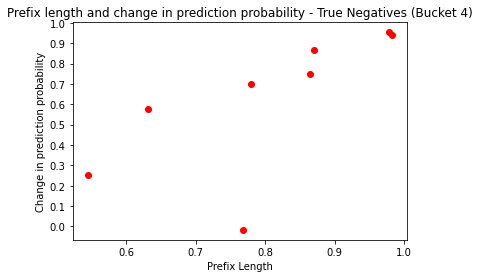

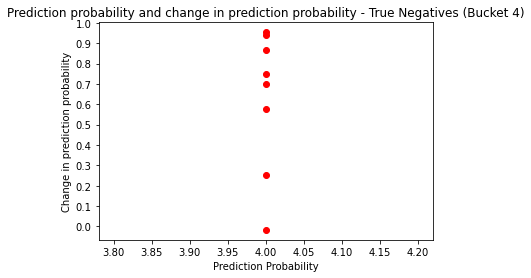

Category 2 of 4. Instance 1 of 10
Creating explanations
[('index__activity_duration_2', -0.47105712, 0.47105712), ('index__timesincecasestart_2', 0.38403293, 0.38403293), ('index__Activity_3_Turning & Milling - Machine 5', 0.33786654, 0.33786654), ('index__activity_duration_0', 0.32022756, 0.32022756), ('index__activity_duration_1', -0.31520787, 0.31520787), ('index__hour_2', 0.26380348, 0.26380348), ('static__Work_Order_Qty', 0.23294947, 0.23294947), ('static__Part_Desc__Cable Head', 0.22199015, 0.22199015), ('index__open_cases_3', 0.21816798, 0.21816798), ('index__Activity_2_Turning & Milling - Machine 5', 0.19984281, 0.19984281), ('index__month_0', -0.19558558, 0.19558558), ('index__timesincemidnight_2', 0.18646614, 0.18646614), ('index__timesincelastevent_3', 0.1849072, 0.1849072), ('index__open_cases_1', -0.1806592, 0.1806592), ('index__Activity_1_Turning & Milling - Machine 5', 0.17302188, 0.17302188), ('index__hour_0', -0.15663886, 0.15663886), ('index__open_cases_2', -0.1520779

Creating explanations
[('static__Work_Order_Qty', -0.64250475, 0.64250475), ('index__activity_duration_1', -0.43786147, 0.43786147), ('index__Resource_0_ID4794', 0.42168945, 0.42168945), ('index__Activity_0_Turning & Milling - Machine 4', 0.41321135, 0.41321135), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.36653632, 0.36653632), ('index__activity_duration_2', 0.3095678, 0.3095678), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.23569173, 0.23569173), ('index__month_0', -0.22542755, 0.22542755), ('index__Report_Type_1_S', -0.21519107, 0.21519107), ('index__timesincelastevent_3', -0.17970133, 0.17970133), ('index__Activity_2_Turning & Milling - Machine 4', 0.1754293, 0.1754293), ('index__weekday_2', 0.17474212, 0.17474212), ('index__Report_Type_2_D', 0.17024674, 0.17024674), ('index__Qty_Completed_3', -0.16527429, 0.16527429), ('index__timesincemidnight_0', 0.16100723, 0.16100723), ('index__weekday_1', 0.15302134, 0.15302134), ('index__month_3', -0.14922298, 0.149222

Creating explanations
[('index__Activity_3_Turning & Milling - Machine 5', 0.5231267, 0.5231267), ('index__activity_duration_2', 0.43496495, 0.43496495), ('index__timesincelastevent_1', 0.3348067, 0.3348067), ('index__timesincecasestart_3', 0.270452, 0.270452), ('index__month_0', -0.19024634, 0.19024634), ('static__Part_Desc__Cable Head', 0.16879314, 0.16879314), ('index__hour_3', 0.15710439, 0.15710439), ('index__timesincelastevent_2', -0.15308076, 0.15308076), ('index__timesincecasestart_2', -0.1501056, 0.1501056), ('index__timesincecasestart_1', -0.14847614, 0.14847614), ('index__Report_Type_3_D', -0.14054851, 0.14054851), ('index__Report_Type_1_S', -0.12884915, 0.12884915), ('index__Activity_2_Turning & Milling - Machine 5', 0.12667009, 0.12667009), ('index__Resource.1_3_Machine 5 - Turning & Milling', 0.12385997, 0.12385997), ('index__Activity_1_Turning & Milling - Machine 5', 0.11765961, 0.11765961), ('index__timesincemidnight_2', -0.10594997, 0.10594997), ('index__Report_Type_1_

Creating explanations
[('index__Activity_1_Turning & Milling - Machine 4', 0.5836902, 0.5836902), ('index__Activity_0_Turning & Milling - Machine 4', 0.4194463, 0.4194463), ('index__timesincecasestart_1', 0.4012333, 0.4012333), ('index__activity_duration_2', -0.3987282, 0.3987282), ('index__timesincecasestart_2', 0.39707446, 0.39707446), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.3414923, 0.3414923), ('index__activity_duration_0', -0.32639697, 0.32639697), ('index__activity_duration_1', 0.32399368, 0.32399368), ('index__timesincelastevent_3', 0.28859, 0.28859), ('index__timesincemidnight_1', 0.28238502, 0.28238502), ('index__hour_2', 0.26476106, 0.26476106), ('index__open_cases_1', -0.26398635, 0.26398635), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.24587406, 0.24587406), ('static__Work_Order_Qty', 0.24387257, 0.24387257), ('static__Part_Desc__Cable Head', 0.2381399, 0.2381399), ('index__timesincelastevent_1', 0.23719648, 0.23719648), ('index__timesincelasteve

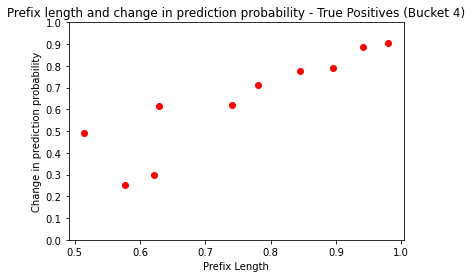

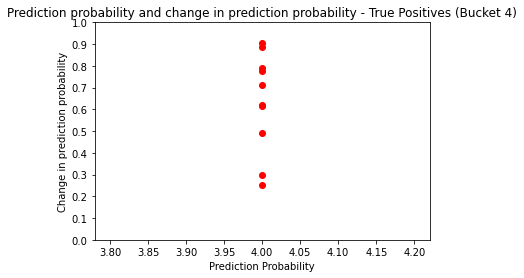

Category 3 of 4. Instance 1 of 8
Creating explanations
[('static__Work_Order_Qty', -0.61650586, 0.61650586), ('index__Resource_2_ID4618', -0.37243652, 0.37243652), ('index__Resource_0_ID4794', 0.37192678, 0.37192678), ('index__activity_duration_1', -0.33960643, 0.33960643), ('index__open_cases_1', -0.2951641, 0.2951641), ('index__timesincelastevent_3', 0.23239361, 0.23239361), ('index__timesincemidnight_3', 0.20886943, 0.20886943), ('index__open_cases_3', 0.20710777, 0.20710777), ('index__timesincecasestart_3', 0.20249456, 0.20249456), ('index__month_0', -0.1851795, 0.1851795), ('index__open_cases_2', -0.18494573, 0.18494573), ('index__timesincelastevent_1', 0.18439548, 0.18439548), ('index__hour_3', 0.16554405, 0.16554405), ('index__activity_duration_0', 0.16023639, 0.16023639), ('index__month_3', -0.1501182, 0.1501182), ('index__timesincemidnight_0', 0.14544764, 0.14544764), ('index__Activity_2_Turning & Milling Q.C.', 0.14260109, 0.14260109), ('index__Report_Type_1_S', 0.13344707, 0

Creating explanations
[('static__Work_Order_Qty', 0.60558677, 0.60558677), ('index__timesincelastevent_2', 0.339069, 0.339069), ('index__activity_duration_1', 0.2924734, 0.2924734), ('index__Activity_0_Round Grinding - Manual', -0.2838757, 0.2838757), ('index__hour_0', -0.2669537, 0.2669537), ('index__Resource_1_ID4528', -0.25619397, 0.25619397), ('index__activity_duration_0', 0.22971076, 0.22971076), ('index__activity_duration_3', -0.21139106, 0.21139106), ('index__Report_Type_1_S', -0.1947901, 0.1947901), ('index__Activity_2_Round Grinding - Manual', -0.18607499, 0.18607499), ('index__timesincemidnight_3', -0.18223988, 0.18223988), ('index__activity_duration_2', -0.17828116, 0.17828116), ('index__hour_2', 0.17816027, 0.17816027), ('index__Resource.1_1_Machine 27 - Grinding', -0.17610098, 0.17610098), ('index__timesincelastevent_1', -0.17061457, 0.17061457), ('index__open_cases_3', -0.15964335, 0.15964335), ('index__timesincemidnight_1', 0.13890067, 0.13890067), ('index__Report_Type_3

Creating explanations
[('index__Activity_2_Turning & Milling - Machine 8', -0.4533825, 0.4533825), ('index__timesincelastevent_3', -0.3456264, 0.3456264), ('index__timesincemidnight_1', 0.3077759, 0.3077759), ('index__Resource_0_ID4219', -0.24856964, 0.24856964), ('index__hour_0', -0.2201434, 0.2201434), ('index__activity_duration_3', -0.22003114, 0.22003114), ('index__timesincemidnight_3', -0.21245293, 0.21245293), ('index__hour_2', -0.20587914, 0.20587914), ('static__Part_Desc__Spur Gear', -0.16433965, 0.16433965), ('index__month_3', -0.1613682, 0.1613682), ('index__Qty_Completed_3', 0.16054308, 0.16054308), ('index__activity_duration_1', 0.15626496, 0.15626496), ('index__timesincecasestart_2', 0.15560898, 0.15560898), ('index__timesincemidnight_0', -0.14663397, 0.14663397), ('index__Activity_0_Turning & Milling - Machine 8', -0.14647497, 0.14647497), ('index__Resource.1_1_Machine 8 - Turning & Milling', -0.14257266, 0.14257266), ('index__Report_Type_1_S', 0.14096905, 0.14096905), ('

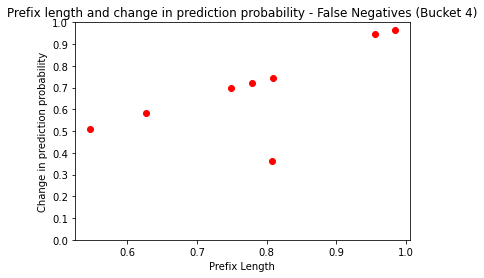

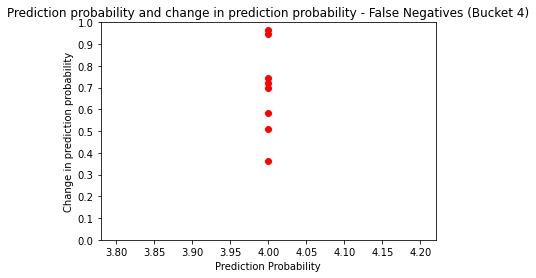

Category 4 of 4. Instance 1 of 7
Creating explanations
[('index__Activity_3_Turning & Milling - Machine 5', 0.5197545, 0.5197545), ('index__timesincemidnight_1', -0.43555772, 0.43555772), ('index__timesincecasestart_3', -0.3481405, 0.3481405), ('static__Work_Order_Qty', 0.33677498, 0.33677498), ('index__Report_Type_0_S', 0.3291285, 0.3291285), ('index__activity_duration_0', -0.3231221, 0.3231221), ('index__timesincelastevent_3', -0.31752694, 0.31752694), ('index__activity_duration_1', 0.3068408, 0.3068408), ('static__Part_Desc__Cable Head', 0.28284636, 0.28284636), ('index__open_cases_1', -0.27098027, 0.27098027), ('index__timesincelastevent_1', -0.26795217, 0.26795217), ('index__hour_0', -0.21248262, 0.21248262), ('index__open_cases_2', -0.21041729, 0.21041729), ('index__Activity_1_Turning & Milling - Machine 5', 0.20894861, 0.20894861), ('index__timesincecasestart_1', -0.19870093, 0.19870093), ('index__hour_2', -0.19563243, 0.19563243), ('index__open_cases_3', 0.19459341, 0.19459341)

Creating explanations
[('index__activity_duration_1', 0.4413675, 0.4413675), ('index__timesincecasestart_3', -0.4186951, 0.4186951), ('index__timesincecasestart_1', 0.41864392, 0.41864392), ('index__Activity_3_Turning & Milling - Machine 5', 0.40558934, 0.40558934), ('index__timesincecasestart_2', 0.39926657, 0.39926657), ('index__timesincemidnight_1', 0.3230531, 0.3230531), ('static__Part_Desc__Cable Head', 0.2950131, 0.2950131), ('index__hour_0', 0.28093362, 0.28093362), ('index__timesincelastevent_1', 0.28017923, 0.28017923), ('index__timesincelastevent_2', -0.23969844, 0.23969844), ('index__activity_duration_2', -0.19328338, 0.19328338), ('index__month_0', -0.18844622, 0.18844622), ('index__timesincemidnight_0', -0.17613788, 0.17613788), ('index__timesincemidnight_3', -0.17087048, 0.17087048), ('index__activity_duration_3', 0.16398853, 0.16398853), ('index__timesincemidnight_2', -0.16198143, 0.16198143), ('index__Activity_1_Turning & Milling - Machine 5', 0.1500471, 0.1500471), ('i

Creating explanations
[('index__Activity_1_Turning & Milling - Machine 4', 0.5836902, 0.5836902), ('index__activity_duration_1', 0.4294987, 0.4294987), ('index__Activity_0_Turning & Milling - Machine 4', 0.4194463, 0.4194463), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.35223514, 0.35223514), ('index__timesincemidnight_1', 0.29447743, 0.29447743), ('index__timesincelastevent_3', 0.2768617, 0.2768617), ('index__open_cases_1', -0.2768414, 0.2768414), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.24587406, 0.24587406), ('index__open_cases_0', -0.24542129, 0.24542129), ('index__activity_duration_2', -0.22732083, 0.22732083), ('index__activity_duration_0', -0.22515607, 0.22515607), ('index__open_cases_3', 0.22124547, 0.22124547), ('index__hour_2', -0.21885246, 0.21885246), ('index__timesincemidnight_0', -0.20523813, 0.20523813), ('index__activity_duration_3', 0.18409693, 0.18409693), ('index__Resource_0_ID4932', 0.18387553, 0.18387553), ('index__hour_3', 0.17959839, 0.

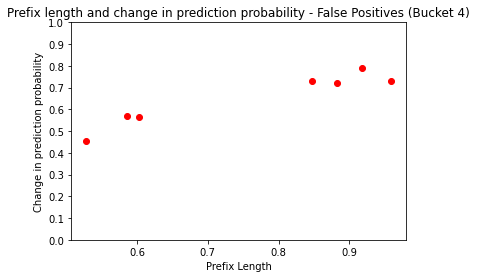

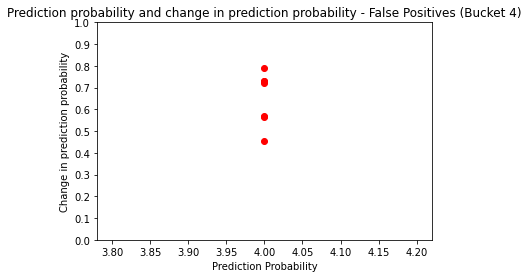

Bucket 5
Generating distributions for bucket
1 of 397 features
2 of 397 features
3 of 397 features
4 of 397 features
5 of 397 features
6 of 397 features
7 of 397 features
8 of 397 features
9 of 397 features
10 of 397 features
11 of 397 features
12 of 397 features
13 of 397 features
14 of 397 features
15 of 397 features
16 of 397 features
17 of 397 features
18 of 397 features
19 of 397 features
20 of 397 features
21 of 397 features
22 of 397 features
23 of 397 features
24 of 397 features
25 of 397 features
26 of 397 features
27 of 397 features
28 of 397 features
29 of 397 features
30 of 397 features
31 of 397 features
32 of 397 features
33 of 397 features
34 of 397 features
35 of 397 features
36 of 397 features
37 of 397 features
38 of 397 features
39 of 397 features
40 of 397 features
41 of 397 features
42 of 397 features
43 of 397 features
44 of 397 features
45 of 397 features
46 of 397 features
47 of 397 features
48 of 397 features
49 of 397 features
50 of 397 features
51 of 397 feat

Creating explanations
[('index__Report_Type_4_S', 0.40222853, 0.40222853), ('index__timesincemidnight_3', -0.35931262, 0.35931262), ('index__activity_duration_3', -0.35555342, 0.35555342), ('index__Qty_Completed_3', -0.3413134, 0.3413134), ('index__Report_Type_4_D', 0.33145288, 0.33145288), ('index__timesincelastevent_2', 0.32961255, 0.32961255), ('index__timesincelastevent_4', 0.29328388, 0.29328388), ('index__hour_1', 0.2719174, 0.2719174), ('index__open_cases_1', -0.248788, 0.248788), ('index__timesincemidnight_2', -0.23451376, 0.23451376), ('static__Work_Order_Qty', -0.22441332, 0.22441332), ('index__Resource_2_ID4529', 0.22431906, 0.22431906), ('index__month_3', -0.21358702, 0.21358702), ('index__activity_duration_2', -0.19549376, 0.19549376), ('index__hour_0', -0.19476594, 0.19476594), ('index__Resource.1_3_Quality Check 1', -0.17730008, 0.17730008), ('index__open_cases_4', -0.15603265, 0.15603265), ('index__weekday_1', -0.1549967, 0.1549967), ('index__weekday_4', 0.14325011, 0.1

Creating explanations
[('index__timesincemidnight_3', 0.46997267, 0.46997267), ('index__weekday_3', -0.33808902, 0.33808902), ('index__activity_duration_3', 0.26938942, 0.26938942), ('index__open_cases_1', -0.2648319, 0.2648319), ('index__Resource_3_ID0997', -0.26240656, 0.26240656), ('index__timesincecasestart_3', 0.24769853, 0.24769853), ('index__activity_duration_1', 0.24467497, 0.24467497), ('index__hour_0', -0.23809576, 0.23809576), ('index__timesincemidnight_1', -0.21418889, 0.21418889), ('index__timesincelastevent_2', -0.20932133, 0.20932133), ('index__Activity_1_Turning & Milling - Machine 8', -0.17832105, 0.17832105), ('index__timesincelastevent_1', 0.17686115, 0.17686115), ('index__weekday_1', -0.17639154, 0.17639154), ('index__Qty_Completed_3', 0.17571306, 0.17571306), ('index__month_3', -0.1688859, 0.1688859), ('index__Resource_0_ID4287', -0.16776809, 0.16776809), ('index__Qty_Completed_2', -0.16277395, 0.16277395), ('index__open_cases_3', -0.14472285, 0.14472285), ('index_

Creating explanations
[('static__Work_Order_Qty', -0.4683163, 0.4683163), ('static__Part_Desc__Ballnut', -0.4520459, 0.4520459), ('index__timesincecasestart_1', 0.34973738, 0.34973738), ('index__timesincemidnight_3', -0.3467954, 0.3467954), ('index__hour_0', -0.30566406, 0.30566406), ('index__Resource_1_ID4529', 0.28897524, 0.28897524), ('index__hour_1', 0.23972625, 0.23972625), ('index__activity_duration_1', 0.23412524, 0.23412524), ('index__Activity_1_Turning & Milling - Machine 8', -0.21025915, 0.21025915), ('index__month_3', -0.20505539, 0.20505539), ('index__weekday_1', -0.19360766, 0.19360766), ('index__timesincelastevent_1', 0.193329, 0.193329), ('index__weekday_3', -0.1916297, 0.1916297), ('index__Report_Type_0_S', 0.18539047, 0.18539047), ('index__Report_Type_0_D', 0.16771881, 0.16771881), ('index__Resource_3_ID4219', 0.16346362, 0.16346362), ('index__timesincelastevent_2', 0.15743583, 0.15743583), ('index__timesincecasestart_4', -0.15663008, 0.15663008), ('index__open_cases_1

Creating explanations
[('index__timesincemidnight_3', -0.44830823, 0.44830823), ('static__Part_Desc__Ballnut', -0.43119222, 0.43119222), ('index__timesincemidnight_4', -0.33262148, 0.33262148), ('index__weekday_3', -0.3257281, 0.3257281), ('index__weekday_0', -0.2524452, 0.2524452), ('index__timesincemidnight_2', -0.22715867, 0.22715867), ('index__Resource_0_ID4287', -0.21884347, 0.21884347), ('index__month_3', -0.2045421, 0.2045421), ('index__open_cases_1', -0.20256858, 0.20256858), ('index__Report_Type_0_S', 0.19731691, 0.19731691), ('index__timesincecasestart_2', -0.1971901, 0.1971901), ('static__Work_Order_Qty', 0.18619995, 0.18619995), ('index__timesincelastevent_1', -0.1832095, 0.1832095), ('index__activity_duration_0', -0.17223392, 0.17223392), ('index__Qty_Completed_3', -0.14729968, 0.14729968), ('index__Resource_3_ID4882', -0.14629237, 0.14629237), ('index__timesincelastevent_4', 0.14295083, 0.14295083), ('index__Resource.1_2_Machine 1 - Lapping', 0.13731912, 0.13731912), ('st

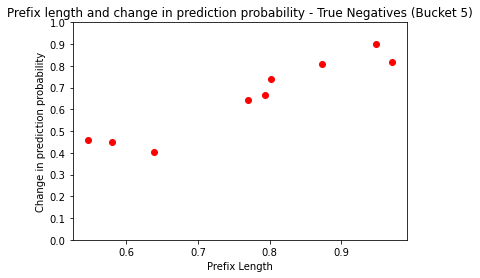

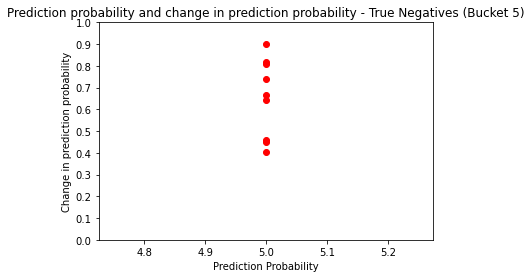

Category 2 of 4. Instance 1 of 10
Creating explanations
[('index__Resource.1_1_Machine 4 - Turning & Milling', 0.714239, 0.714239), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.38090095, 0.38090095), ('index__Activity_1_Turning & Milling - Machine 4', 0.35839367, 0.35839367), ('index__timesincecasestart_4', -0.32611814, 0.32611814), ('index__Activity_0_Turning & Milling - Machine 4', 0.30194676, 0.30194676), ('index__timesincemidnight_3', -0.30191192, 0.30191192), ('index__open_cases_1', -0.25985163, 0.25985163), ('index__weekday_1', -0.23662834, 0.23662834), ('index__Resource.1_4_Machine 4 - Turning & Milling', 0.23400931, 0.23400931), ('index__weekday_0', -0.21021956, 0.21021956), ('index__hour_0', -0.2052222, 0.2052222), ('index__timesincecasestart_1', 0.20460908, 0.20460908), ('index__timesincelastevent_4', -0.19338936, 0.19338936), ('index__weekday_4', -0.18773274, 0.18773274), ('index__Resource_2_ID4529', 0.17425257, 0.17425257), ('index__timesincelastevent_1', 0.17086

Creating explanations
[('static__Work_Order_Qty', 0.46024668, 0.46024668), ('index__timesincecasestart_1', 0.34992394, 0.34992394), ('index__Resource_0_ID4429', -0.33279645, 0.33279645), ('index__weekday_3', -0.33042488, 0.33042488), ('index__timesincelastevent_2', 0.24205315, 0.24205315), ('index__Resource_3_ID4529', 0.23572229, 0.23572229), ('index__timesincemidnight_4', 0.23228663, 0.23228663), ('index__weekday_1', -0.22143579, 0.22143579), ('index__Resource.1_3_Machine 5 - Turning & Milling', 0.20147881, 0.20147881), ('index__timesincemidnight_3', 0.1888945, 0.1888945), ('index__hour_3', 0.17492814, 0.17492814), ('index__timesincemidnight_1', -0.16154973, 0.16154973), ('index__activity_duration_3', -0.15829274, 0.15829274), ('index__open_cases_1', -0.15671763, 0.15671763), ('index__Qty_Completed_3', -0.15196846, 0.15196846), ('index__activity_duration_1', 0.14949036, 0.14949036), ('index__timesincecasestart_2', -0.14835432, 0.14835432), ('index__Resource.1_0_Machine 5 - Turning & M

Creating explanations
[('index__Resource.1_1_Machine 4 - Turning & Milling', 0.8574133, 0.8574133), ('index__activity_duration_3', -0.4539688, 0.4539688), ('static__Part_Desc__Ballnut', -0.4490244, 0.4490244), ('index__Activity_1_Turning & Milling - Machine 4', 0.3891249, 0.3891249), ('index__timesincecasestart_1', 0.36545756, 0.36545756), ('index__Activity_0_Turning & Milling - Machine 4', 0.35599113, 0.35599113), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.32496706, 0.32496706), ('index__Resource_0_ID4429', -0.319262, 0.319262), ('index__timesincelastevent_4', 0.31548625, 0.31548625), ('index__weekday_1', -0.30148968, 0.30148968), ('index__Report_Type_3_S', 0.29568213, 0.29568213), ('index__weekday_4', -0.26164582, 0.26164582), ('index__timesincemidnight_3', -0.25406325, 0.25406325), ('index__weekday_0', -0.2390631, 0.2390631), ('index__Resource.1_4_Machine 4 - Turning & Milling', 0.23400931, 0.23400931), ('index__Qty_Completed_3', 0.23005062, 0.23005062), ('static__Work_

Creating explanations
[('static__Work_Order_Qty', 0.45211774, 0.45211774), ('index__Activity_3_Turning & Milling - Machine 9', 0.41996297, 0.41996297), ('index__Qty_Completed_3', -0.35175985, 0.35175985), ('index__timesincecasestart_1', 0.3431403, 0.3431403), ('index__weekday_3', -0.29648376, 0.29648376), ('index__timesincecasestart_4', -0.2898851, 0.2898851), ('index__timesincecasestart_3', 0.26806647, 0.26806647), ('index__activity_duration_1', 0.24640979, 0.24640979), ('index__month_3', -0.21793963, 0.21793963), ('index__timesincemidnight_3', 0.20584063, 0.20584063), ('index__weekday_1', -0.19622242, 0.19622242), ('index__hour_3', 0.1920218, 0.1920218), ('index__hour_0', -0.18885647, 0.18885647), ('index__timesincelastevent_1', 0.16576871, 0.16576871), ('index__Qty_Completed_2', -0.1616321, 0.1616321), ('index__activity_duration_0', 0.16054845, 0.16054845), ('index__hour_1', 0.15646012, 0.15646012), ('index__open_cases_3', -0.15182407, 0.15182407), ('index__Activity_2_Turning & Mill

Creating explanations
[('index__Resource.1_1_Machine 4 - Turning & Milling', 0.53282565, 0.53282565), ('static__Work_Order_Qty', 0.48308718, 0.48308718), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.4175503, 0.4175503), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.40020242, 0.40020242), ('index__timesincecasestart_1', 0.35676017, 0.35676017), ('index__activity_duration_3', 0.3379399, 0.3379399), ('index__timesincemidnight_3', 0.29665393, 0.29665393), ('index__open_cases_1', -0.2544416, 0.2544416), ('index__Resource_1_ID4932', 0.23966345, 0.23966345), ('index__Qty_Completed_2', -0.23443608, 0.23443608), ('index__month_3', -0.22681397, 0.22681397), ('index__activity_duration_2', 0.21100648, 0.21100648), ('index__Activity_2_other', -0.1909215, 0.1909215), ('index__Qty_Completed_3', -0.1695365, 0.1695365), ('index__timesincecasestart_2', 0.16597278, 0.16597278), ('index__Activity_3_other', -0.16144353, 0.16144353), ('index__timesincelastevent_2', 0.15578555, 0.1557855

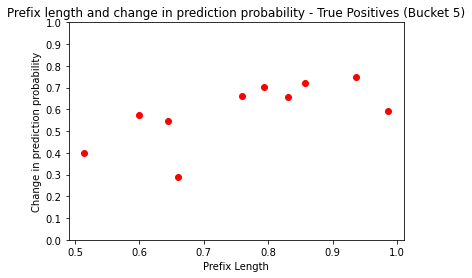

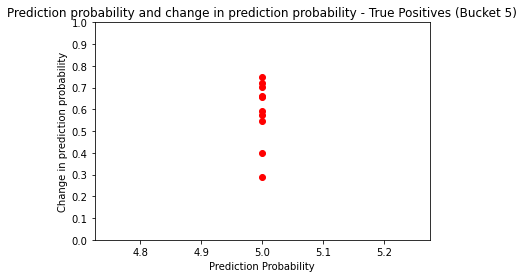

Category 3 of 4. Instance 1 of 7
Creating explanations
[('static__Part_Desc__Ballnut', -0.45899662, 0.45899662), ('index__activity_duration_3', 0.42006254, 0.42006254), ('index__weekday_3', -0.3537484, 0.3537484), ('index__timesincemidnight_4', 0.31123894, 0.31123894), ('index__timesincelastevent_4', 0.26971447, 0.26971447), ('index__activity_duration_4', -0.23031965, 0.23031965), ('index__timesincemidnight_1', -0.22874267, 0.22874267), ('index__hour_1', -0.21766625, 0.21766625), ('index__hour_4', 0.21252082, 0.21252082), ('index__month_3', -0.20178327, 0.20178327), ('static__Work_Order_Qty', -0.19660589, 0.19660589), ('index__timesincelastevent_1', 0.17743227, 0.17743227), ('index__Qty_Completed_0', -0.15575318, 0.15575318), ('index__open_cases_1', -0.15127885, 0.15127885), ('index__weekday_4', 0.14101623, 0.14101623), ('index__Qty_Completed_3', 0.13605721, 0.13605721), ('static__Part_Desc__Spur Gear', 0.12851039, 0.12851039), ('index__hour_2', -0.11727804, 0.11727804), ('index__open_

Creating explanations
[('static__Part_Desc__Spur Gear', -0.73054165, 0.73054165), ('index__timesincemidnight_4', 0.5910942, 0.5910942), ('index__timesincecasestart_1', 0.34062126, 0.34062126), ('index__open_cases_1', -0.33867034, 0.33867034), ('index__timesincelastevent_4', 0.24863571, 0.24863571), ('index__weekday_0', -0.24718362, 0.24718362), ('index__activity_duration_1', 0.23083869, 0.23083869), ('static__Work_Order_Qty', 0.22955818, 0.22955818), ('index__activity_duration_3', -0.22130857, 0.22130857), ('index__month_3', -0.20166081, 0.20166081), ('index__hour_1', 0.19919704, 0.19919704), ('index__Resource_4_ID4219', -0.19630699, 0.19630699), ('index__weekday_1', 0.18509729, 0.18509729), ('index__timesincelastevent_1', 0.18138869, 0.18138869), ('index__timesincemidnight_2', -0.16853453, 0.16853453), ('index__hour_0', -0.16569641, 0.16569641), ('index__weekday_4', -0.16512047, 0.16512047), ('index__timesincecasestart_2', -0.15690297, 0.15690297), ('index__activity_duration_0', -0.13

Creating explanations
[('static__Part_Desc__Ballnut', -0.38671485, 0.38671485), ('index__activity_duration_3', 0.35963655, 0.35963655), ('static__Work_Order_Qty', 0.3374271, 0.3374271), ('index__open_cases_1', -0.30724555, 0.30724555), ('index__timesincecasestart_2', -0.2648491, 0.2648491), ('index__activity_duration_1', -0.24651133, 0.24651133), ('index__weekday_2', -0.23535451, 0.23535451), ('index__Resource_3_ID4529', 0.22897303, 0.22897303), ('index__weekday_4', -0.22133325, 0.22133325), ('index__timesincemidnight_3', 0.19792582, 0.19792582), ('index__weekday_0', -0.18660305, 0.18660305), ('index__timesincecasestart_1', -0.1863206, 0.1863206), ('index__timesincemidnight_4', -0.18466265, 0.18466265), ('index__timesincelastevent_4', -0.17845488, 0.17845488), ('index__month_3', -0.1671691, 0.1671691), ('index__hour_3', 0.16521065, 0.16521065), ('index__timesincemidnight_1', 0.16384205, 0.16384205), ('index__activity_duration_4', -0.15863022, 0.15863022), ('index__weekday_1', -0.156674

Creating explanations
[('static__Part_Desc__Ballnut', -0.45046723, 0.45046723), ('static__Work_Order_Qty', -0.44388276, 0.44388276), ('index__timesincemidnight_4', -0.38054883, 0.38054883), ('index__weekday_3', 0.34504312, 0.34504312), ('index__open_cases_1', -0.30842137, 0.30842137), ('index__timesincemidnight_3', 0.26371723, 0.26371723), ('index__activity_duration_1', -0.2447004, 0.2447004), ('index__hour_4', -0.23394154, 0.23394154), ('index__activity_duration_3', -0.23084544, 0.23084544), ('index__Activity_4_Turning & Milling Q.C.', 0.20661585, 0.20661585), ('index__timesincelastevent_2', -0.20486186, 0.20486186), ('index__timesincecasestart_1', -0.19731131, 0.19731131), ('index__month_3', -0.18057656, 0.18057656), ('index__timesincelastevent_4', 0.17262062, 0.17262062), ('index__Activity_2_Turning & Milling Q.C.', -0.16871242, 0.16871242), ('index__hour_0', 0.16605698, 0.16605698), ('index__weekday_1', 0.14991668, 0.14991668), ('index__Resource_4_ID4618', -0.14901969, 0.14901969),

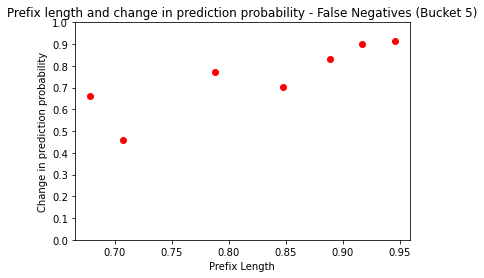

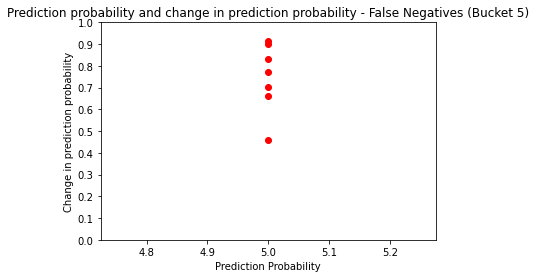

Category 4 of 4. Instance 1 of 9
Creating explanations
[('index__open_cases_1', -0.41146803, 0.41146803), ('index__timesincemidnight_3', 0.38321754, 0.38321754), ('index__activity_duration_3', 0.38083082, 0.38083082), ('index__weekday_3', -0.3764978, 0.3764978), ('index__timesincelastevent_4', -0.28839567, 0.28839567), ('index__timesincecasestart_2', -0.28408605, 0.28408605), ('index__timesincecasestart_1', -0.25485387, 0.25485387), ('index__Report_Type_0_S', 0.22070399, 0.22070399), ('index__month_3', -0.2096934, 0.2096934), ('index__Resource.1_3_Machine 5 - Turning & Milling', 0.20750673, 0.20750673), ('index__hour_1', -0.2054108, 0.2054108), ('index__timesincemidnight_1', -0.19904321, 0.19904321), ('index__Resource_1_ID4529', 0.18983047, 0.18983047), ('index__hour_4', -0.18516265, 0.18516265), ('index__timesincemidnight_2', 0.16084081, 0.16084081), ('index__weekday_1', 0.14315882, 0.14315882), ('index__activity_duration_1', 0.14092556, 0.14092556), ('static__Part_Desc__Ballnut', 0.1

Creating explanations
[('index__timesincecasestart_1', 0.33910918, 0.33910918), ('static__Work_Order_Qty', 0.3330523, 0.3330523), ('index__Resource_0_ID4429', -0.3091672, 0.3091672), ('index__timesincemidnight_3', -0.2995459, 0.2995459), ('index__timesincecasestart_4', -0.2948628, 0.2948628), ('index__activity_duration_1', 0.28588447, 0.28588447), ('index__activity_duration_3', 0.2610578, 0.2610578), ('index__Resource_1_ID4932', 0.25480926, 0.25480926), ('index__timesincelastevent_2', -0.2431844, 0.2431844), ('index__timesincecasestart_2', 0.22589765, 0.22589765), ('index__Qty_Completed_2', 0.20898339, 0.20898339), ('index__Resource.1_3_Machine 5 - Turning & Milling', 0.20733878, 0.20733878), ('index__hour_1', 0.20246755, 0.20246755), ('index__timesincelastevent_1', 0.18610926, 0.18610926), ('index__Qty_Completed_3', -0.1772351, 0.1772351), ('index__month_3', -0.17634514, 0.17634514), ('index__timesincemidnight_2', 0.17034651, 0.17034651), ('index__activity_duration_0', -0.16231011, 0.

Creating explanations
[('index__Activity_3_Turning & Milling - Machine 9', 0.5305866, 0.5305866), ('index__timesincemidnight_3', 0.52798235, 0.52798235), ('static__Work_Order_Qty', 0.4569832, 0.4569832), ('index__weekday_3', 0.3033079, 0.3033079), ('index__timesincemidnight_2', 0.25331846, 0.25331846), ('index__hour_1', -0.23256999, 0.23256999), ('index__open_cases_1', -0.23168834, 0.23168834), ('index__timesincemidnight_1', -0.23107916, 0.23107916), ('index__Report_Type_0_S', 0.22855496, 0.22855496), ('index__timesincelastevent_2', -0.22430609, 0.22430609), ('index__month_3', -0.21786742, 0.21786742), ('index__timesincecasestart_2', -0.21594296, 0.21594296), ('index__activity_duration_1', -0.21414553, 0.21414553), ('index__Resource_4_ID4794', -0.17658277, 0.17658277), ('index__activity_duration_4', -0.17289485, 0.17289485), ('index__hour_0', 0.15897869, 0.15897869), ('index__timesincelastevent_4', -0.15528344, 0.15528344), ('index__open_cases_2', 0.14019611, 0.14019611), ('index__week

Creating explanations
[('index__Resource.1_1_Machine 4 - Turning & Milling', 0.5801726, 0.5801726), ('index__Activity_1_Turning & Milling - Machine 4', 0.45657352, 0.45657352), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.45536447, 0.45536447), ('index__timesincelastevent_2', 0.45463768, 0.45463768), ('static__Part_Desc__Ballnut', -0.44418222, 0.44418222), ('index__timesincemidnight_3', 0.40941542, 0.40941542), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.40528893, 0.40528893), ('index__Qty_Completed_3', -0.36013824, 0.36013824), ('index__timesincemidnight_4', -0.3383148, 0.3383148), ('index__Activity_0_Turning & Milling - Machine 4', 0.27544144, 0.27544144), ('index__open_cases_1', -0.25289717, 0.25289717), ('index__Resource_1_ID4932', 0.24344589, 0.24344589), ('index__hour_4', -0.20655118, 0.20655118), ('index__timesincelastevent_4', -0.19219533, 0.19219533), ('index__activity_duration_3', 0.18619432, 0.18619432), ('index__Activity_3_Turning & Milling - Machine 

Creating explanations
[('index__timesincemidnight_4', 0.6154219, 0.6154219), ('index__Resource.1_4_Machine 10 - Grinding', 0.47318292, 0.47318292), ('index__weekday_3', 0.3732683, 0.3732683), ('index__timesincemidnight_3', 0.36926278, 0.36926278), ('index__open_cases_1', -0.3272284, 0.3272284), ('index__activity_duration_2', 0.28087145, 0.28087145), ('index__Activity_4_Turning & Milling - Machine 10', 0.27263942, 0.27263942), ('index__timesincemidnight_1', 0.26632333, 0.26632333), ('index__activity_duration_3', 0.25990358, 0.25990358), ('index__timesincelastevent_1', -0.25502875, 0.25502875), ('index__Resource.1_1_Machine 10 - Grinding', 0.24239552, 0.24239552), ('index__timesincecasestart_3', -0.2390814, 0.2390814), ('index__Activity_3_Turning & Milling - Machine 10', 0.2260032, 0.2260032), ('index__month_3', -0.21708143, 0.21708143), ('index__activity_duration_1', -0.21120434, 0.21120434), ('index__activity_duration_0', -0.20277348, 0.20277348), ('index__Qty_Completed_3', 0.18952553,

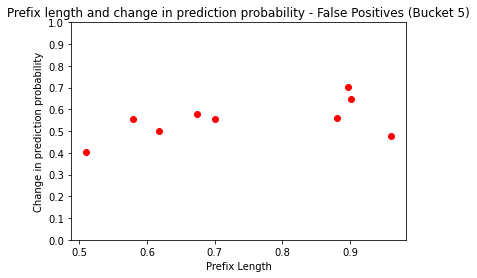

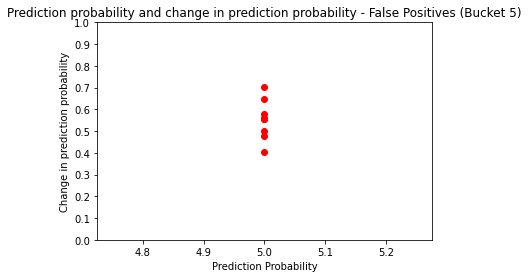

Bucket 6
Generating distributions for bucket
1 of 470 features
2 of 470 features
3 of 470 features
4 of 470 features
5 of 470 features
6 of 470 features
7 of 470 features
8 of 470 features
9 of 470 features
10 of 470 features
11 of 470 features
12 of 470 features
13 of 470 features
14 of 470 features
15 of 470 features
16 of 470 features
17 of 470 features
18 of 470 features
19 of 470 features
20 of 470 features
21 of 470 features
22 of 470 features
23 of 470 features
24 of 470 features
25 of 470 features
26 of 470 features
27 of 470 features
28 of 470 features
29 of 470 features
30 of 470 features
31 of 470 features
32 of 470 features
33 of 470 features
34 of 470 features
35 of 470 features
36 of 470 features
37 of 470 features
38 of 470 features
39 of 470 features
40 of 470 features
41 of 470 features
42 of 470 features
43 of 470 features
44 of 470 features
45 of 470 features
46 of 470 features
47 of 470 features
48 of 470 features
49 of 470 features
50 of 470 features
51 of 470 feat

470 of 470 features
Category 1 of 4. Instance 1 of 7
Creating explanations
[('index__Resource.1_1_Machine 5 - Turning & Milling', 0.37648582, 0.37648582), ('index__timesincelastevent_2', -0.23267923, 0.23267923), ('index__open_cases_3', -0.22242261, 0.22242261), ('index__Resource_5_ID4429', 0.17394733, 0.17394733), ('index__Activity_3_Turning & Milling - Machine 5', 0.17292981, 0.17292981), ('index__hour_3', -0.16470237, 0.16470237), ('index__open_cases_4', -0.16373159, 0.16373159), ('index__Activity_2_Turning & Milling - Machine 5', 0.16204776, 0.16204776), ('index__Resource.1_2_Machine 5 - Turning & Milling', 0.15618615, 0.15618615), ('index__month_2', -0.15484895, 0.15484895), ('index__timesincelastevent_4', 0.15415245, 0.15415245), ('index__Report_Type_4_S', -0.15369467, 0.15369467), ('index__Resource.1_3_Machine 5 - Turning & Milling', 0.15155904, 0.15155904), ('index__open_cases_5', -0.15015614, 0.15015614), ('index__activity_duration_4', -0.14979903, 0.14979903), ('index__Report

Creating explanations
[('index__timesincecasestart_4', -0.4829318, 0.4829318), ('index__Report_Type_4_D', 0.40291992, 0.40291992), ('index__timesincelastevent_4', -0.33885556, 0.33885556), ('index__Report_Type_5_S', 0.27972546, 0.27972546), ('static__Work_Order_Qty', -0.25193518, 0.25193518), ('index__activity_duration_3', -0.24439907, 0.24439907), ('index__Report_Type_5_D', 0.24416909, 0.24416909), ('index__open_cases_5', -0.23634209, 0.23634209), ('index__timesincelastevent_5', -0.2357802, 0.2357802), ('index__open_cases_3', -0.22774841, 0.22774841), ('index__timesincecasestart_2', 0.22764903, 0.22764903), ('index__open_cases_0', 0.21173032, 0.21173032), ('index__timesincelastevent_2', -0.20884006, 0.20884006), ('index__month_2', -0.18881997, 0.18881997), ('index__Report_Type_3_S', 0.18621622, 0.18621622), ('index__timesincemidnight_4', 0.18540122, 0.18540122), ('index__hour_3', -0.1702712, 0.1702712), ('index__Resource_0_ID4219', -0.16899161, 0.16899161), ('index__Activity_3_Turning

Creating explanations
[('index__activity_duration_4', -0.31845036, 0.31845036), ('index__timesincecasestart_4', 0.29350787, 0.29350787), ('index__Resource.1_5_Quality Check 1', -0.24159767, 0.24159767), ('static__Work_Order_Qty', 0.21201995, 0.21201995), ('index__open_cases_5', -0.20462272, 0.20462272), ('index__activity_duration_5', 0.1951321, 0.1951321), ('index__open_cases_3', -0.19126326, 0.19126326), ('index__hour_3', -0.18710604, 0.18710604), ('index__weekday_2', 0.1837702, 0.1837702), ('index__Qty_Completed_5', 0.1815456, 0.1815456), ('index__month_2', -0.17922945, 0.17922945), ('index__open_cases_2', -0.17364955, 0.17364955), ('index__activity_duration_2', -0.16929315, 0.16929315), ('index__weekday_4', -0.16698149, 0.16698149), ('index__Report_Type_4_S', -0.16187288, 0.16187288), ('index__weekday_0', 0.16081782, 0.16081782), ('index__timesincemidnight_1', -0.14633344, 0.14633344), ('index__timesincemidnight_3', -0.13132611, 0.13132611), ('index__timesincemidnight_0', 0.13114838

Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 7
Creating explanations
[('index__timesincecasestart_4', -0.4572964, 0.4572964), ('index__open_cases_5', -0.3829052, 0.3829052), ('index__activity_duration_4', 0.38123894, 0.38123894), ('index__timesincelastevent_3', -0.31618083, 0.31618083), ('static__Work_Order_Qty', -0.28224096, 0.28224096), ('index__Resource_5_ID0998', -0.26075155, 0.26075155), ('index__timesincelastevent_5', 0.22023448, 0.22023448), ('index__hour_1', -0.21591108, 0.21591108), ('index__weekday_4', -0.20909974, 0.20909974), ('index__open_cases_3', -0.18590492, 0.18590492), ('index__Qty_Completed_3', -0.1839976, 0.1839976), ('index__timesincemidnight_1', -0.18219951, 0.18219951), ('index__timesincemidnight_4', -0.18180764, 0.18180764), ('index__activity_duration_0', 0.17663598, 0.17663598), ('index__open_cases_2', -0.16985227, 0.16985227), ('index__Activity_4_Turning & Milling Q.C.', 0.15929703, 0.15929703), ('inde

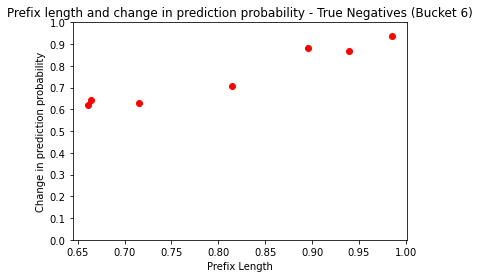

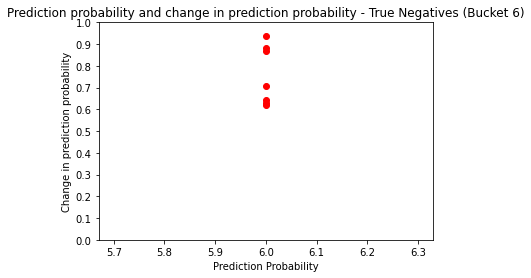

Category 2 of 4. Instance 1 of 7
Creating explanations
[('index__timesincecasestart_4', 0.5588526, 0.5588526), ('index__timesincelastevent_4', -0.3469393, 0.3469393), ('static__Work_Order_Qty', 0.3245374, 0.3245374), ('index__timesincelastevent_3', 0.27809402, 0.27809402), ('static__Part_Desc__Cable Head', 0.25903395, 0.25903395), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.24132916, 0.24132916), ('index__activity_duration_2', -0.23254102, 0.23254102), ('index__Activity_0_other', -0.23004399, 0.23004399), ('index__activity_duration_5', 0.2236495, 0.2236495), ('index__Resource.1_5_Machine 4 - Turning & Milling', 0.22235999, 0.22235999), ('index__open_cases_5', -0.19743197, 0.19743197), ('index__Qty_Completed_5', -0.18415427, 0.18415427), ('index__timesincecasestart_2', 0.18230392, 0.18230392), ('index__Activity_1_other', -0.17624028, 0.17624028), ('index__month_2', -0.175475, 0.175475), ('index__open_cases_2', -0.17244656, 0.17244656), ('index__timesincelastevent_2', -0.1701

Creating explanations
[('static__Work_Order_Qty', 0.52372646, 0.52372646), ('index__timesincelastevent_4', -0.4388534, 0.4388534), ('index__timesincelastevent_5', 0.38136604, 0.38136604), ('index__Resource.1_1_Machine 5 - Turning & Milling', 0.36237752, 0.36237752), ('index__timesincecasestart_4', -0.2924928, 0.2924928), ('index__open_cases_2', 0.2702547, 0.2702547), ('index__Resource.1_2_Machine 5 - Turning & Milling', 0.2626441, 0.2626441), ('index__activity_duration_4', -0.22698766, 0.22698766), ('index__Report_Type_5_D', 0.22335887, 0.22335887), ('index__open_cases_0', 0.21351849, 0.21351849), ('index__timesincemidnight_4', 0.2043259, 0.2043259), ('index__hour_3', -0.18671165, 0.18671165), ('index__timesincelastevent_2', 0.18492997, 0.18492997), ('index__activity_duration_5', -0.18079512, 0.18079512), ('index__month_2', -0.16870792, 0.16870792), ('index__Activity_3_Turning & Milling - Machine 5', 0.16110474, 0.16110474), ('index__Report_Type_4_S', -0.15993607, 0.15993607), ('index_

Creating explanations
[('index__activity_duration_4', 0.360118, 0.360118), ('index__activity_duration_2', -0.3328494, 0.3328494), ('index__Resource.1_1_Machine 5 - Turning & Milling', 0.3265132, 0.3265132), ('index__timesincemidnight_4', 0.29284617, 0.29284617), ('static__Part_Desc__Cable Head', 0.27767956, 0.27767956), ('index__Resource.1_2_Machine 5 - Turning & Milling', 0.27161637, 0.27161637), ('index__Report_Type_5_S', 0.25561404, 0.25561404), ('index__timesincelastevent_2', -0.23038356, 0.23038356), ('index__Qty_Completed_5', 0.22924279, 0.22924279), ('index__open_cases_2', -0.21003604, 0.21003604), ('index__timesincemidnight_3', 0.20677505, 0.20677505), ('index__month_2', -0.20613779, 0.20613779), ('index__open_cases_3', -0.20159847, 0.20159847), ('index__activity_duration_5', 0.19826114, 0.19826114), ('index__open_cases_4', -0.1954362, 0.1954362), ('index__Report_Type_4_S', -0.17531815, 0.17531815), ('index__Report_Type_5_D', 0.16998552, 0.16998552), ('index__activity_duration_

Creating explanations
[('index__timesincecasestart_4', 0.482114, 0.482114), ('index__open_cases_5', -0.37527838, 0.37527838), ('index__activity_duration_4', 0.32903522, 0.32903522), ('index__Activity_4_Turning & Milling - Machine 4', 0.32644618, 0.32644618), ('index__timesincemidnight_4', 0.31741711, 0.31741711), ('index__timesincelastevent_3', -0.3138818, 0.3138818), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.28818065, 0.28818065), ('index__Report_Type_5_S', 0.27699557, 0.27699557), ('index__Report_Type_5_D', 0.27004766, 0.27004766), ('index__Qty_Completed_5', 0.26315376, 0.26315376), ('index__timesincelastevent_4', 0.23625225, 0.23625225), ('index__Activity_2_Turning & Milling - Machine 4', 0.22438484, 0.22438484), ('index__open_cases_3', -0.21969488, 0.21969488), ('index__timesincecasestart_3', 0.21767525, 0.21767525), ('index__Activity_3_Turning & Milling - Machine 4', 0.21276742, 0.21276742), ('index__timesincemidnight_5', 0.2035134, 0.2035134), ('static__Part_Desc__C

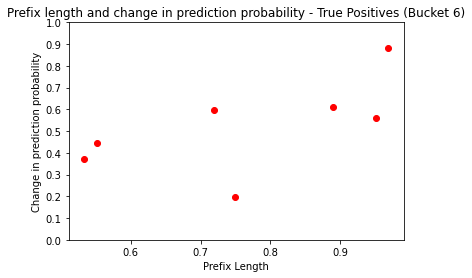

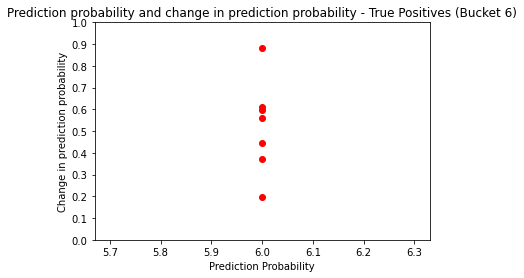

Category 3 of 4. Instance 1 of 9
Creating explanations
[('index__timesincelastevent_5', 0.36893737, 0.36893737), ('index__Resource.1_5_Quality Check 1', -0.33137777, 0.33137777), ('index__timesincelastevent_2', 0.3073733, 0.3073733), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.30678996, 0.30678996), ('index__hour_3', -0.27269956, 0.27269956), ('index__Qty_Completed_5', -0.2518106, 0.2518106), ('index__timesincemidnight_4', -0.23279727, 0.23279727), ('index__Activity_5_Turning & Milling Q.C.', -0.22988193, 0.22988193), ('index__Activity_3_Turning & Milling - Machine 4', 0.22302556, 0.22302556), ('index__timesincelastevent_4', 0.20979291, 0.20979291), ('index__timesincelastevent_3', -0.20688736, 0.20688736), ('index__Activity_2_Turning & Milling - Machine 4', 0.20314455, 0.20314455), ('index__open_cases_3', -0.18671946, 0.18671946), ('index__Report_Type_3_S', 0.17792268, 0.17792268), ('index__timesincecasestart_2', 0.1762923, 0.1762923), ('index__open_cases_5', -0.16939856, 0

Creating explanations
[('static__Part_Desc__Spur Gear', -0.5116741, 0.5116741), ('static__Work_Order_Qty', 0.23714834, 0.23714834), ('index__timesincemidnight_4', 0.21665756, 0.21665756), ('index__timesincemidnight_3', 0.20206325, 0.20206325), ('index__timesincelastevent_5', -0.20054364, 0.20054364), ('index__Qty_Completed_5', -0.19953904, 0.19953904), ('index__month_2', -0.19839673, 0.19839673), ('index__open_cases_2', -0.19446678, 0.19446678), ('index__weekday_4', -0.19349276, 0.19349276), ('index__open_cases_3', -0.1900212, 0.1900212), ('index__weekday_2', 0.174239, 0.174239), ('index__open_cases_5', -0.15742542, 0.15742542), ('index__open_cases_4', -0.15387475, 0.15387475), ('index__Report_Type_4_S', -0.15023956, 0.15023956), ('index__Resource_0_ID4794', 0.14929874, 0.14929874), ('index__activity_duration_5', 0.14876173, 0.14876173), ('index__timesincecasestart_2', 0.13375132, 0.13375132), ('index__weekday_0', -0.13210902, 0.13210902), ('index__activity_duration_1', 0.12501866, 0.1

Creating explanations
[('index__Activity_4_Turning & Milling - Machine 4', 0.30758026, 0.30758026), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.29096973, 0.29096973), ('index__Resource.1_5_Quality Check 1', -0.2843799, 0.2843799), ('index__Activity_3_Turning & Milling Q.C.', -0.2470368, 0.2470368), ('index__open_cases_5', -0.22650191, 0.22650191), ('index__timesincelastevent_3', -0.225757, 0.225757), ('index__timesincecasestart_4', -0.21305408, 0.21305408), ('index__Qty_Completed_5', 0.21300349, 0.21300349), ('index__Activity_5_Turning & Milling Q.C.', -0.20989887, 0.20989887), ('static__Work_Order_Qty', 0.20039341, 0.20039341), ('index__Qty_Completed_4', 0.17591359, 0.17591359), ('index__weekday_2', 0.16903074, 0.16903074), ('index__Activity_2_Turning & Milling - Machine 4', 0.16189262, 0.16189262), ('index__timesincemidnight_3', -0.16110314, 0.16110314), ('index__open_cases_2', -0.15061264, 0.15061264), ('index__open_cases_3', -0.14841314, 0.14841314), ('index__Resource.1

Creating explanations
[('index__timesincecasestart_4', -0.56371486, 0.56371486), ('static__Work_Order_Qty', 0.52456963, 0.52456963), ('index__timesincelastevent_4', -0.44999936, 0.44999936), ('index__timesincelastevent_3', -0.3572011, 0.3572011), ('index__Resource.1_5_Quality Check 1', -0.3523564, 0.3523564), ('index__open_cases_5', -0.30587372, 0.30587372), ('index__activity_duration_2', -0.26891407, 0.26891407), ('index__open_cases_0', 0.23821892, 0.23821892), ('index__timesincecasestart_3', 0.20662424, 0.20662424), ('index__hour_3', -0.20528635, 0.20528635), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0.1965423, 0.1965423), ('index__Activity_3_Turning & Milling - Machine 9', 0.15034442, 0.15034442), ('index__Activity_0_Turning & Milling - Machine 9', 0.15022106, 0.15022106), ('index__Qty_Completed_5', 0.14374, 0.14374), ('index__Report_Type_4_S', -0.14351949, 0.14351949), ('index__Report_Type_4_D', -0.14270155, 0.14270155), ('index__Activity_2_Turning & Milling - Machine 

Creating explanations
[('index__timesincecasestart_4', -0.46770257, 0.46770257), ('static__Work_Order_Qty', -0.35435978, 0.35435978), ('index__activity_duration_3', -0.30879194, 0.30879194), ('index__activity_duration_5', -0.2983112, 0.2983112), ('index__timesincelastevent_2', 0.28177282, 0.28177282), ('index__Resource_0_ID4794', 0.22763366, 0.22763366), ('index__open_cases_5', -0.2240424, 0.2240424), ('index__Activity_3_Turning & Milling Q.C.', -0.21207032, 0.21207032), ('index__hour_3', -0.1976228, 0.1976228), ('index__open_cases_4', -0.18931167, 0.18931167), ('index__timesincemidnight_4', -0.17498964, 0.17498964), ('index__open_cases_3', -0.16975018, 0.16975018), ('index__Resource_3_ID4618', -0.16714783, 0.16714783), ('index__Report_Type_4_S', -0.16333741, 0.16333741), ('index__open_cases_2', -0.16165209, 0.16165209), ('index__month_2', -0.1597935, 0.1597935), ('index__timesincecasestart_2', -0.1555992, 0.1555992), ('index__activity_duration_4', -0.15478976, 0.15478976), ('index__Qt

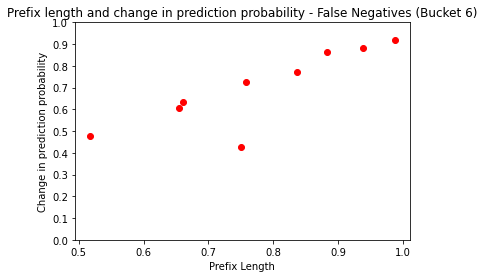

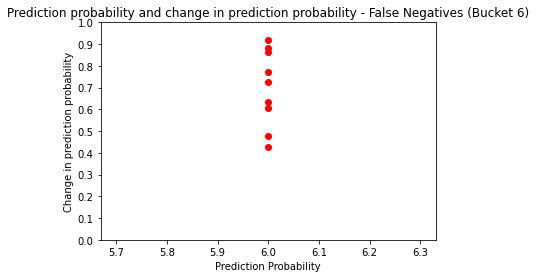

Category 4 of 4. Instance 1 of 8
Creating explanations
[('index__timesincecasestart_4', -0.43301407, 0.43301407), ('index__timesincelastevent_4', -0.41484475, 0.41484475), ('index__activity_duration_4', 0.35848808, 0.35848808), ('static__Work_Order_Qty', 0.33883935, 0.33883935), ('index__Resource.1_1_Machine 5 - Turning & Milling', 0.31717673, 0.31717673), ('static__Part_Desc__Cable Head', 0.28120983, 0.28120983), ('index__Resource.1_2_Machine 5 - Turning & Milling', 0.2601092, 0.2601092), ('index__timesincelastevent_2', -0.23807667, 0.23807667), ('index__open_cases_5', -0.23261441, 0.23261441), ('index__timesincecasestart_2', 0.18127206, 0.18127206), ('index__open_cases_2', -0.17873865, 0.17873865), ('index__month_2', -0.17586188, 0.17586188), ('index__open_cases_3', -0.17397751, 0.17397751), ('index__weekday_3', -0.16961746, 0.16961746), ('index__Activity_2_Turning & Milling - Machine 5', 0.16171165, 0.16171165), ('index__weekday_0', 0.15773667, 0.15773667), ('index__Report_Type_4_S'

Creating explanations
[('index__Report_Type_4_S', 0.65633804, 0.65633804), ('index__timesincelastevent_4', 0.33076638, 0.33076638), ('static__Work_Order_Qty', -0.3281619, 0.3281619), ('index__open_cases_5', -0.29379424, 0.29379424), ('index__timesincemidnight_4', 0.28553858, 0.28553858), ('index__timesincelastevent_5', 0.2799517, 0.2799517), ('index__timesincelastevent_3', -0.24423742, 0.24423742), ('index__month_2', -0.24336205, 0.24336205), ('index__activity_duration_2', -0.22784472, 0.22784472), ('index__timesincemidnight_5', 0.22611284, 0.22611284), ('index__Qty_Completed_5', 0.20974368, 0.20974368), ('index__Report_Type_4_D', 0.19575189, 0.19575189), ('index__open_cases_2', -0.19524342, 0.19524342), ('index__Qty_Completed_3', -0.18628633, 0.18628633), ('index__timesincecasestart_4', 0.18189144, 0.18189144), ('index__activity_duration_4', -0.18147102, 0.18147102), ('index__open_cases_3', -0.17116298, 0.17116298), ('index__hour_1', 0.15829149, 0.15829149), ('index__Activity_3_Turnin

Creating explanations
[('index__timesincelastevent_4', 0.34058255, 0.34058255), ('index__timesincemidnight_4', 0.29987317, 0.29987317), ('index__open_cases_5', -0.27844918, 0.27844918), ('static__Work_Order_Qty', 0.26830742, 0.26830742), ('index__open_cases_3', -0.25304696, 0.25304696), ('index__Activity_1_Turning & Milling - Machine 10', 0.24470334, 0.24470334), ('index__activity_duration_4', 0.2268242, 0.2268242), ('index__Resource.1_4_Machine 10 - Grinding', 0.20562282, 0.20562282), ('index__hour_3', -0.20533526, 0.20533526), ('index__open_cases_2', -0.20340058, 0.20340058), ('index__open_cases_4', -0.1998252, 0.1998252), ('index__activity_duration_2', 0.18084693, 0.18084693), ('index__Resource_3_ID4641', 0.17777845, 0.17777845), ('index__month_2', -0.16902584, 0.16902584), ('index__timesincelastevent_3', 0.1441148, 0.1441148), ('index__timesincecasestart_3', -0.13889375, 0.13889375), ('index__weekday_2', -0.13877204, 0.13877204), ('index__hour_1', 0.1377687, 0.1377687), ('index__ti

Creating explanations
[('index__Resource.1_1_Machine 5 - Turning & Milling', 0.32534298, 0.32534298), ('index__open_cases_5', -0.28865674, 0.28865674), ('index__activity_duration_4', 0.28179786, 0.28179786), ('index__Qty_Completed_5', 0.2733985, 0.2733985), ('index__timesincelastevent_4', 0.2711386, 0.2711386), ('static__Work_Order_Qty', -0.26872626, 0.26872626), ('index__timesincemidnight_4', 0.25944343, 0.25944343), ('index__open_cases_3', -0.25870523, 0.25870523), ('index__timesincelastevent_3', -0.25158092, 0.25158092), ('index__timesincemidnight_5', 0.24245444, 0.24245444), ('static__Part_Desc__Cable Head', 0.24087718, 0.24087718), ('index__activity_duration_3', -0.20412123, 0.20412123), ('index__Activity_0_other', -0.20055898, 0.20055898), ('index__hour_5', 0.19937137, 0.19937137), ('index__activity_duration_5', 0.19840829, 0.19840829), ('index__timesincecasestart_2', 0.18222651, 0.18222651), ('index__month_2', -0.17802633, 0.17802633), ('index__timesincemidnight_3', 0.17779002, 

Pertubing - Run 9
Pertubing - Run 10


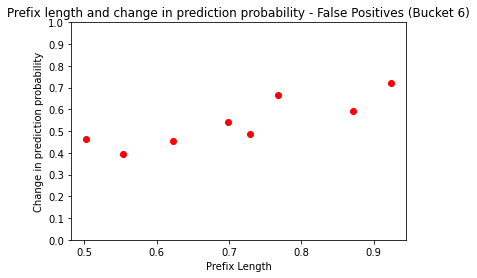

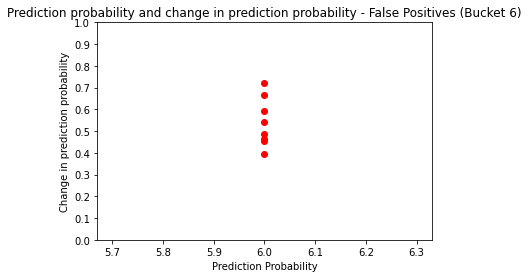

Bucket 7
Generating distributions for bucket
1 of 521 features
2 of 521 features
3 of 521 features
4 of 521 features
5 of 521 features
6 of 521 features
7 of 521 features
8 of 521 features
9 of 521 features
10 of 521 features
11 of 521 features
12 of 521 features
13 of 521 features
14 of 521 features
15 of 521 features
16 of 521 features
17 of 521 features
18 of 521 features
19 of 521 features
20 of 521 features
21 of 521 features
22 of 521 features
23 of 521 features
24 of 521 features
25 of 521 features
26 of 521 features
27 of 521 features
28 of 521 features
29 of 521 features
30 of 521 features
31 of 521 features
32 of 521 features
33 of 521 features
34 of 521 features
35 of 521 features
36 of 521 features
37 of 521 features
38 of 521 features
39 of 521 features
40 of 521 features
41 of 521 features
42 of 521 features
43 of 521 features
44 of 521 features
45 of 521 features
46 of 521 features
47 of 521 features
48 of 521 features
49 of 521 features
50 of 521 features
51 of 521 feat

447 of 521 features
448 of 521 features
449 of 521 features
450 of 521 features
451 of 521 features
452 of 521 features
453 of 521 features
454 of 521 features
455 of 521 features
456 of 521 features
457 of 521 features
458 of 521 features
459 of 521 features
460 of 521 features
461 of 521 features
462 of 521 features
463 of 521 features
464 of 521 features
465 of 521 features
466 of 521 features
467 of 521 features
468 of 521 features
469 of 521 features
470 of 521 features
471 of 521 features
472 of 521 features
473 of 521 features
474 of 521 features
475 of 521 features
476 of 521 features
477 of 521 features
478 of 521 features
479 of 521 features
480 of 521 features
481 of 521 features
482 of 521 features
483 of 521 features
484 of 521 features
485 of 521 features
486 of 521 features
487 of 521 features
488 of 521 features
489 of 521 features
490 of 521 features
491 of 521 features
492 of 521 features
493 of 521 features
494 of 521 features
495 of 521 features
496 of 521 features


Creating explanations
[('index__open_cases_6', -0.6481233, 0.6481233), ('index__Qty_Completed_2', -0.35785148, 0.35785148), ('index__timesincelastevent_5', 0.34615707, 0.34615707), ('index__activity_duration_2', -0.33835638, 0.33835638), ('index__timesincecasestart_6', -0.3136767, 0.3136767), ('index__activity_duration_6', 0.30981952, 0.30981952), ('index__hour_1', -0.2961462, 0.2961462), ('index__timesincemidnight_1', -0.28712907, 0.28712907), ('index__weekday_0', 0.25555152, 0.25555152), ('index__Qty_Completed_6', -0.2376236, 0.2376236), ('index__timesincelastevent_4', -0.21774986, 0.21774986), ('index__month_3', -0.20054188, 0.20054188), ('index__hour_4', -0.19825993, 0.19825993), ('index__open_cases_1', 0.19317374, 0.19317374), ('index__hour_2', 0.19014193, 0.19014193), ('index__timesincelastevent_1', 0.18342577, 0.18342577), ('index__activity_duration_4', 0.17975892, 0.17975892), ('index__timesincelastevent_3', 0.16621436, 0.16621436), ('index__timesincemidnight_6', 0.15335856, 0.

Creating explanations
[('index__activity_duration_6', -0.51948375, 0.51948375), ('index__open_cases_6', -0.4324385, 0.4324385), ('index__Qty_Completed_6', 0.42250037, 0.42250037), ('index__weekday_0', 0.32484698, 0.32484698), ('index__timesincelastevent_3', 0.32287964, 0.32287964), ('index__timesincecasestart_4', 0.26198325, 0.26198325), ('index__timesincemidnight_6', 0.25655416, 0.25655416), ('index__hour_5', -0.25330597, 0.25330597), ('index__timesincecasestart_2', -0.2368221, 0.2368221), ('index__Resource.1_2_Quality Check 1', -0.23106307, 0.23106307), ('index__Resource_2_ID4618', -0.21253972, 0.21253972), ('index__weekday_6', -0.19573468, 0.19573468), ('index__timesincecasestart_6', -0.19302349, 0.19302349), ('index__timesincemidnight_0', 0.17771026, 0.17771026), ('index__activity_duration_4', -0.17455398, 0.17455398), ('index__activity_duration_0', 0.17209573, 0.17209573), ('static__Work_Order_Qty', 0.16713579, 0.16713579), ('index__Report_Type_0_S', 0.16329634, 0.16329634), ('ind

Creating explanations
[('index__weekday_0', 0.38691527, 0.38691527), ('index__open_cases_6', -0.3853579, 0.3853579), ('index__Qty_Completed_6', -0.35438162, 0.35438162), ('index__timesincemidnight_6', 0.31494462, 0.31494462), ('index__Resource_4_ID4882', -0.30930042, 0.30930042), ('index__timesincelastevent_3', -0.2979114, 0.2979114), ('index__Resource.1_2_Quality Check 1', -0.29420924, 0.29420924), ('index__Qty_Completed_2', -0.24706805, 0.24706805), ('index__timesincecasestart_6', -0.24125454, 0.24125454), ('index__timesincemidnight_1', -0.21367873, 0.21367873), ('index__timesincecasestart_4', 0.20858775, 0.20858775), ('index__hour_1', -0.20765343, 0.20765343), ('index__hour_4', 0.20399562, 0.20399562), ('index__timesincecasestart_2', -0.19378883, 0.19378883), ('index__timesincelastevent_4', 0.1918601, 0.1918601), ('index__activity_duration_6', -0.19093384, 0.19093384), ('index__timesincemidnight_0', 0.18523037, 0.18523037), ('index__activity_duration_1', 0.17121437, 0.17121437), ('i

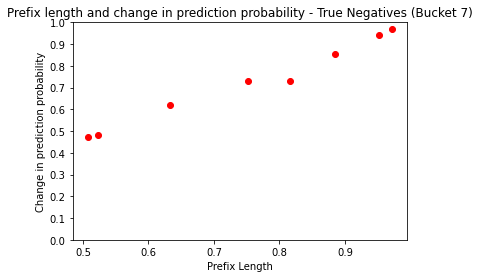

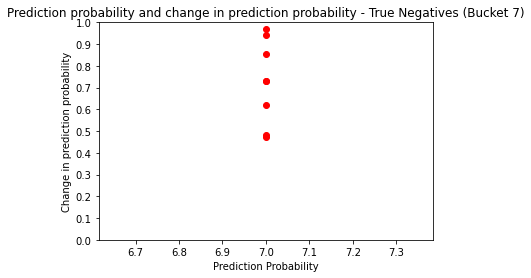

Category 2 of 4. Instance 1 of 8
Creating explanations
[('index__timesincecasestart_6', 0.43390447, 0.43390447), ('index__Activity_5_Turning & Milling Q.C.', -0.3994824, 0.3994824), ('index__open_cases_6', -0.35705018, 0.35705018), ('index__timesincecasestart_4', -0.35588786, 0.35588786), ('index__Qty_Completed_6', -0.34819388, 0.34819388), ('index__activity_duration_6', 0.31018943, 0.31018943), ('index__timesincelastevent_3', -0.30312476, 0.30312476), ('index__Activity_1_Turning & Milling - Machine 4', 0.2940889, 0.2940889), ('index__Resource_5_ID4618', -0.2452049, 0.2452049), ('index__timesincemidnight_1', -0.23395097, 0.23395097), ('index__timesincelastevent_5', -0.2106591, 0.2106591), ('index__Activity_0_Turning & Milling - Machine 4', 0.20953871, 0.20953871), ('index__Resource.1_2_Machine 4 - Turning & Milling', 0.20821497, 0.20821497), ('index__hour_1', -0.20564571, 0.20564571), ('index__timesincelastevent_4', 0.18617791, 0.18617791), ('index__Qty_Completed_4', 0.17544489, 0.1754

Creating explanations
[('index__open_cases_6', -0.54543287, 0.54543287), ('index__Qty_Completed_6', 0.34525666, 0.34525666), ('index__timesincelastevent_3', -0.331149, 0.331149), ('index__timesincemidnight_5', 0.3230239, 0.3230239), ('index__Report_Type_5_S', 0.3095465, 0.3095465), ('index__timesincelastevent_5', 0.29761034, 0.29761034), ('index__timesincecasestart_6', 0.296885, 0.296885), ('index__Qty_Completed_4', -0.23743528, 0.23743528), ('index__hour_4', 0.19384328, 0.19384328), ('index__Activity_3_Turning & Milling - Machine 8', -0.18622452, 0.18622452), ('index__timesincelastevent_6', 0.1739672, 0.1739672), ('index__Report_Type_5_D', 0.17095385, 0.17095385), ('index__hour_3', 0.1707055, 0.1707055), ('index__timesincemidnight_6', -0.1704419, 0.1704419), ('index__timesincemidnight_0', 0.16610749, 0.16610749), ('index__activity_duration_6', -0.16009958, 0.16009958), ('index__Activity_2_Turning & Milling - Machine 8', -0.15517937, 0.15517937), ('static__Work_Order_Qty', -0.1420812, 

Creating explanations
[('index__open_cases_6', -0.4321681, 0.4321681), ('index__activity_duration_3', 0.42268974, 0.42268974), ('index__timesincecasestart_6', 0.38954452, 0.38954452), ('index__timesincecasestart_4', -0.33374473, 0.33374473), ('index__timesincelastevent_3', 0.30235487, 0.30235487), ('index__hour_5', -0.25292367, 0.25292367), ('index__timesincemidnight_6', 0.24918139, 0.24918139), ('index__Qty_Completed_6', 0.2218626, 0.2218626), ('index__timesincelastevent_5', -0.19700217, 0.19700217), ('index__timesincecasestart_3', 0.19411343, 0.19411343), ('index__hour_4', -0.1886752, 0.1886752), ('index__timesincecasestart_1', 0.16892281, 0.16892281), ('index__timesincemidnight_3', 0.16548724, 0.16548724), ('index__timesincemidnight_5', -0.15414046, 0.15414046), ('index__activity_duration_2', 0.1539971, 0.1539971), ('index__month_3', -0.15133525, 0.15133525), ('index__Qty_Completed_4', 0.1448154, 0.1448154), ('index__hour_3', 0.14298637, 0.14298637), ('index__Resource_2_ID4529', 0.1

Creating explanations
[('index__timesincemidnight_5', 0.43859223, 0.43859223), ('index__timesincecasestart_2', -0.39708441, 0.39708441), ('index__open_cases_6', -0.37010118, 0.37010118), ('index__timesincelastevent_3', 0.35461843, 0.35461843), ('index__hour_5', 0.31468716, 0.31468716), ('index__timesincecasestart_6', 0.2950091, 0.2950091), ('index__timesincecasestart_4', -0.231642, 0.231642), ('index__timesincelastevent_5', 0.2036545, 0.2036545), ('index__activity_duration_6', 0.19876055, 0.19876055), ('index__Qty_Completed_6', -0.1921612, 0.1921612), ('index__Report_Type_4_S', 0.1612641, 0.1612641), ('static__Work_Order_Qty', 0.15613516, 0.15613516), ('index__weekday_0', 0.1549969, 0.1549969), ('index__activity_duration_2', 0.151659, 0.151659), ('index__Activity_2_Turning & Milling - Machine 5', 0.14834318, 0.14834318), ('index__weekday_5', 0.14643149, 0.14643149), ('index__weekday_3', 0.1458597, 0.1458597), ('index__Activity_3_Turning & Milling - Machine 5', 0.145682, 0.145682), ('in

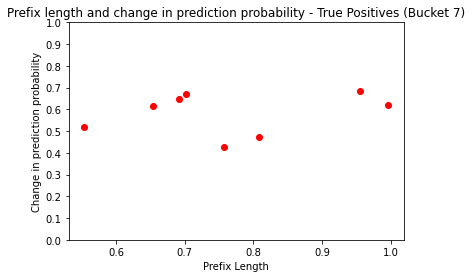

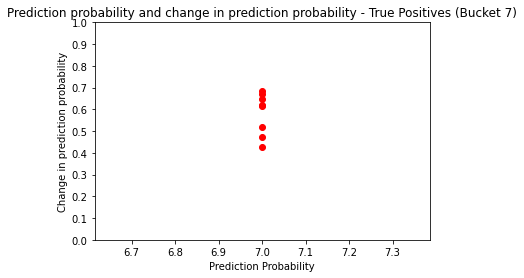

Category 3 of 4. Instance 1 of 8
Creating explanations
[('index__open_cases_6', -0.558773, 0.558773), ('index__timesincelastevent_3', 0.35822868, 0.35822868), ('index__Qty_Completed_6', 0.3578446, 0.3578446), ('index__timesincecasestart_4', -0.31498042, 0.31498042), ('index__timesincemidnight_6', -0.2700564, 0.2700564), ('index__timesincelastevent_5', 0.26271755, 0.26271755), ('index__hour_1', 0.24721532, 0.24721532), ('index__Activity_2_Turning & Milling - Machine 8', -0.23227987, 0.23227987), ('index__activity_duration_2', -0.20677364, 0.20677364), ('index__weekday_0', -0.20490672, 0.20490672), ('index__activity_duration_6', 0.20422071, 0.20422071), ('index__Qty_Completed_4', -0.20379843, 0.20379843), ('index__Report_Type_3_D', 0.20306846, 0.20306846), ('index__Report_Type_0_S', 0.18063594, 0.18063594), ('index__hour_4', -0.17705017, 0.17705017), ('index__hour_3', 0.17104605, 0.17104605), ('index__weekday_5', 0.17073295, 0.17073295), ('index__timesincemidnight_1', 0.15887734, 0.15887

Creating explanations
[('index__timesincecasestart_6', 0.39338875, 0.39338875), ('index__timesincemidnight_6', 0.34494036, 0.34494036), ('index__timesincelastevent_3', -0.33095443, 0.33095443), ('static__Part_Desc__Spur Gear', -0.30200562, 0.30200562), ('index__activity_duration_3', -0.29845166, 0.29845166), ('index__hour_1', 0.29316306, 0.29316306), ('index__open_cases_6', -0.28675368, 0.28675368), ('index__timesincelastevent_2', 0.2652315, 0.2652315), ('index__Activity_2_Turning & Milling - Machine 8', -0.26099107, 0.26099107), ('index__Report_Type_4_S', 0.22288603, 0.22288603), ('index__timesincecasestart_4', 0.22209427, 0.22209427), ('index__activity_duration_6', 0.20634669, 0.20634669), ('index__hour_4', 0.20406574, 0.20406574), ('index__weekday_0', -0.19624597, 0.19624597), ('index__month_3', -0.17853528, 0.17853528), ('index__activity_duration_2', 0.17709503, 0.17709503), ('index__activity_duration_4', -0.16649449, 0.16649449), ('index__timesincecasestart_2', 0.16571544, 0.16571

Creating explanations
[('index__open_cases_6', -0.5545066, 0.5545066), ('index__Qty_Completed_6', -0.3974384, 0.3974384), ('index__timesincelastevent_3', -0.36298335, 0.36298335), ('index__activity_duration_6', 0.31931767, 0.31931767), ('index__timesincecasestart_4', 0.2885496, 0.2885496), ('index__Report_Type_4_S', 0.28802407, 0.28802407), ('index__timesincemidnight_6', 0.2829157, 0.2829157), ('index__timesincemidnight_5', -0.2596877, 0.2596877), ('index__Report_Type_3_D', 0.23679754, 0.23679754), ('index__hour_5', -0.23395608, 0.23395608), ('index__timesincelastevent_5', 0.22749579, 0.22749579), ('index__hour_1', -0.22647898, 0.22647898), ('index__open_cases_1', 0.2196355, 0.2196355), ('index__weekday_0', -0.21532762, 0.21532762), ('index__Report_Type_0_S', 0.20992965, 0.20992965), ('index__timesincelastevent_4', -0.1803269, 0.1803269), ('index__timesincecasestart_6', -0.14356548, 0.14356548), ('index__timesincemidnight_3', -0.14068055, 0.14068055), ('index__Resource.1_4_Machine 9 - 

Creating explanations
[('index__Qty_Completed_6', -0.36600322, 0.36600322), ('index__timesincecasestart_2', -0.34940666, 0.34940666), ('index__open_cases_6', -0.3202128, 0.3202128), ('index__activity_duration_6', 0.31576034, 0.31576034), ('index__Qty_Completed_4', 0.31560877, 0.31560877), ('index__timesincemidnight_6', 0.3099075, 0.3099075), ('index__timesincelastevent_5', -0.26444298, 0.26444298), ('index__weekday_0', 0.26221135, 0.26221135), ('index__timesincecasestart_6', -0.25662178, 0.25662178), ('index__timesincelastevent_3', -0.25070408, 0.25070408), ('index__hour_5', -0.2493962, 0.2493962), ('index__timesincelastevent_6', -0.20303443, 0.20303443), ('static__Work_Order_Qty', 0.20152761, 0.20152761), ('index__hour_4', -0.19318445, 0.19318445), ('index__timesincemidnight_0', -0.1811494, 0.1811494), ('index__weekday_5', 0.1599187, 0.1599187), ('index__activity_duration_3', -0.15553437, 0.15553437), ('index__timesincelastevent_1', -0.1459768, 0.1459768), ('index__activity_duration_4

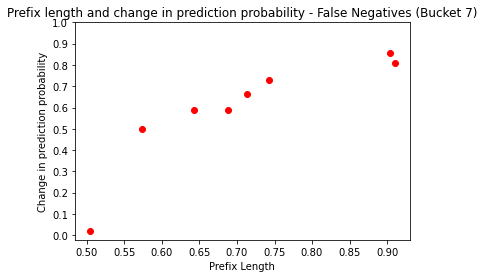

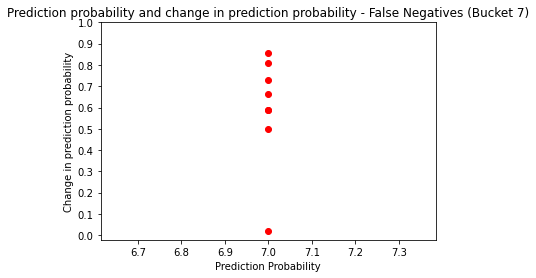

Category 4 of 4. Instance 1 of 7
Creating explanations
[('index__activity_duration_6', -0.6354279, 0.6354279), ('index__open_cases_6', -0.49739242, 0.49739242), ('index__timesincecasestart_4', 0.30777305, 0.30777305), ('index__timesincecasestart_6', 0.27251682, 0.27251682), ('index__Report_Type_4_S', 0.26569426, 0.26569426), ('index__activity_duration_2', -0.25589243, 0.25589243), ('index__Resource.1_2_Machine 4 - Turning & Milling', 0.2548256, 0.2548256), ('index__Activity_3_Turning & Milling - Machine 4', 0.2134568, 0.2134568), ('index__hour_4', 0.21286309, 0.21286309), ('index__timesincemidnight_1', -0.20924632, 0.20924632), ('static__Work_Order_Qty', -0.20334011, 0.20334011), ('index__Qty_Completed_4', 0.17904004, 0.17904004), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.17253318, 0.17253318), ('index__timesincemidnight_6', 0.16144454, 0.16144454), ('index__Activity_0_Turning & Milling - Machine 4', 0.15341553, 0.15341553), ('index__Activity_1_other', -0.12896545, 0.1289

Creating explanations
[('index__open_cases_6', -0.44409725, 0.44409725), ('index__timesincelastevent_3', 0.33099762, 0.33099762), ('index__activity_duration_2', 0.22239335, 0.22239335), ('index__activity_duration_6', 0.2213596, 0.2213596), ('index__timesincelastevent_4', -0.2205461, 0.2205461), ('index__hour_4', 0.21376505, 0.21376505), ('index__weekday_0', -0.21210355, 0.21210355), ('index__Qty_Completed_4', -0.20259604, 0.20259604), ('index__hour_3', 0.19635992, 0.19635992), ('index__timesincemidnight_6', 0.19495957, 0.19495957), ('index__timesincelastevent_5', 0.17949517, 0.17949517), ('index__timesincecasestart_6', -0.17807198, 0.17807198), ('index__timesincelastevent_6', -0.17302576, 0.17302576), ('index__timesincemidnight_3', 0.16509081, 0.16509081), ('index__timesincelastevent_1', -0.15897919, 0.15897919), ('index__Qty_Completed_6', 0.15738343, 0.15738343), ('index__timesincemidnight_0', 0.1509407, 0.1509407), ('index__activity_duration_4', 0.13101515, 0.13101515), ('index__time

Creating explanations
[('index__open_cases_6', -0.5124474, 0.5124474), ('index__Report_Type_5_S', 0.37932524, 0.37932524), ('index__Qty_Completed_6', 0.36686617, 0.36686617), ('index__timesincelastevent_3', -0.36018088, 0.36018088), ('index__timesincecasestart_6', 0.34365648, 0.34365648), ('index__timesincemidnight_1', -0.2873589, 0.2873589), ('index__timesincecasestart_2', 0.282703, 0.282703), ('index__timesincecasestart_4', 0.26122317, 0.26122317), ('index__activity_duration_1', 0.19850565, 0.19850565), ('index__timesincelastevent_4', 0.18019502, 0.18019502), ('index__hour_4', -0.16968594, 0.16968594), ('index__Report_Type_5_D', 0.16835515, 0.16835515), ('index__hour_2', 0.16408084, 0.16408084), ('index__hour_1', -0.16241056, 0.16241056), ('index__activity_duration_4', -0.1609842, 0.1609842), ('index__timesincelastevent_1', 0.14996135, 0.14996135), ('index__activity_duration_3', -0.14470097, 0.14470097), ('index__Report_Type_3_D', 0.14110461, 0.14110461), ('index__activity_duration_6

Creating explanations
[('index__open_cases_6', -0.5346115, 0.5346115), ('index__timesincemidnight_5', 0.41239378, 0.41239378), ('index__Qty_Completed_6', 0.34205934, 0.34205934), ('index__hour_5', 0.3260481, 0.3260481), ('index__timesincecasestart_6', 0.31571555, 0.31571555), ('index__timesincecasestart_2', 0.30817264, 0.30817264), ('index__Resource.1_2_Quality Check 1', -0.3074867, 0.3074867), ('index__activity_duration_3', -0.30237854, 0.30237854), ('index__activity_duration_4', 0.2945129, 0.2945129), ('index__Activity_3_Turning & Milling - Machine 5', 0.2725127, 0.2725127), ('index__hour_4', 0.26572785, 0.26572785), ('index__timesincelastevent_3', -0.23711094, 0.23711094), ('index__Resource_1_ID4529', 0.23296945, 0.23296945), ('index__activity_duration_2', 0.22818144, 0.22818144), ('index__timesincelastevent_5', 0.22652751, 0.22652751), ('index__timesincemidnight_6', 0.2227791, 0.2227791), ('index__timesincelastevent_4', 0.1893158, 0.1893158), ('index__timesincelastevent_1', 0.18873

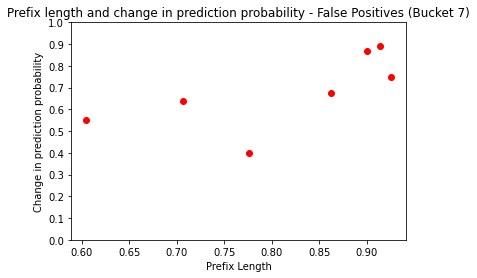

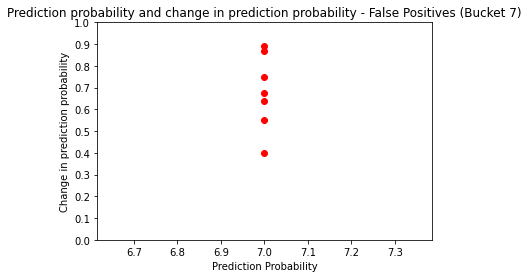

Bucket 8
Generating distributions for bucket
1 of 593 features
2 of 593 features
3 of 593 features
4 of 593 features
5 of 593 features
6 of 593 features
7 of 593 features
8 of 593 features
9 of 593 features
10 of 593 features
11 of 593 features
12 of 593 features
13 of 593 features
14 of 593 features
15 of 593 features
16 of 593 features
17 of 593 features
18 of 593 features
19 of 593 features
20 of 593 features
21 of 593 features
22 of 593 features
23 of 593 features
24 of 593 features
25 of 593 features
26 of 593 features
27 of 593 features
28 of 593 features
29 of 593 features
30 of 593 features
31 of 593 features
32 of 593 features
33 of 593 features
34 of 593 features
35 of 593 features
36 of 593 features
37 of 593 features
38 of 593 features
39 of 593 features
40 of 593 features
41 of 593 features
42 of 593 features
43 of 593 features
44 of 593 features
45 of 593 features
46 of 593 features
47 of 593 features
48 of 593 features
49 of 593 features
50 of 593 features
51 of 593 feat

435 of 593 features
436 of 593 features
437 of 593 features
438 of 593 features
439 of 593 features
440 of 593 features
441 of 593 features
442 of 593 features
443 of 593 features
444 of 593 features
445 of 593 features
446 of 593 features
447 of 593 features
448 of 593 features
449 of 593 features
450 of 593 features
451 of 593 features
452 of 593 features
453 of 593 features
454 of 593 features
455 of 593 features
456 of 593 features
457 of 593 features
458 of 593 features
459 of 593 features
460 of 593 features
461 of 593 features
462 of 593 features
463 of 593 features
464 of 593 features
465 of 593 features
466 of 593 features
467 of 593 features
468 of 593 features
469 of 593 features
470 of 593 features
471 of 593 features
472 of 593 features
473 of 593 features
474 of 593 features
475 of 593 features
476 of 593 features
477 of 593 features
478 of 593 features
479 of 593 features
480 of 593 features
481 of 593 features
482 of 593 features
483 of 593 features
484 of 593 features


Creating explanations
[('index__open_cases_6', -0.4421871, 0.4421871), ('index__timesincelastevent_3', -0.366273, 0.366273), ('index__timesincelastevent_6', 0.29898125, 0.29898125), ('index__month_5', -0.281855, 0.281855), ('index__open_cases_3', -0.2796805, 0.2796805), ('index__month_7', -0.27112848, 0.27112848), ('index__Report_Type_5_S', 0.26342273, 0.26342273), ('index__Qty_Completed_6', 0.26149055, 0.26149055), ('index__Report_Type_5_D', 0.2492674, 0.2492674), ('index__open_cases_1', -0.22552492, 0.22552492), ('index__activity_duration_7', -0.21224621, 0.21224621), ('index__timesincecasestart_7', 0.19573797, 0.19573797), ('index__activity_duration_1', 0.19531652, 0.19531652), ('index__Resource_4_ID4493', 0.19362357, 0.19362357), ('index__timesincelastevent_5', 0.18679087, 0.18679087), ('index__timesincelastevent_1', 0.18676466, 0.18676466), ('index__hour_1', -0.18548872, 0.18548872), ('index__Report_Type_3_D', 0.173115, 0.173115), ('index__Activity_3_Turning & Milling - Machine 5'

Creating explanations
[('index__open_cases_6', -0.44547692, 0.44547692), ('index__timesincelastevent_6', -0.39370593, 0.39370593), ('index__open_cases_3', -0.29834658, 0.29834658), ('index__open_cases_1', -0.29786417, 0.29786417), ('index__Qty_Completed_6', 0.29593784, 0.29593784), ('index__month_7', -0.27344617, 0.27344617), ('index__Report_Type_5_D', 0.26889306, 0.26889306), ('index__month_5', -0.24204008, 0.24204008), ('index__Report_Type_5_S', 0.2366733, 0.2366733), ('index__Qty_Completed_5', -0.19105822, 0.19105822), ('index__hour_1', 0.19085181, 0.19085181), ('index__timesincelastevent_1', 0.16854772, 0.16854772), ('index__Report_Type_3_D', 0.16523825, 0.16523825), ('index__open_cases_7', -0.16305573, 0.16305573), ('index__timesincemidnight_1', 0.15421523, 0.15421523), ('index__activity_duration_1', -0.1496816, 0.1496816), ('index__hour_3', -0.14578284, 0.14578284), ('index__timesincelastevent_4', -0.14384577, 0.14384577), ('index__timesincemidnight_5', 0.14229721, 0.14229721), (

Creating explanations
[('index__Qty_Completed_6', -0.43458056, 0.43458056), ('index__month_7', -0.3410439, 0.3410439), ('index__activity_duration_7', 0.31288075, 0.31288075), ('index__Qty_Completed_1', -0.2694048, 0.2694048), ('index__month_5', -0.26252228, 0.26252228), ('index__timesincecasestart_7', -0.25653574, 0.25653574), ('index__open_cases_3', -0.25269708, 0.25269708), ('index__timesincelastevent_6', 0.22740608, 0.22740608), ('index__Resource_4_ID4287', -0.2135207, 0.2135207), ('index__open_cases_6', -0.20612685, 0.20612685), ('index__activity_duration_2', 0.19732705, 0.19732705), ('index__activity_duration_1', 0.17838176, 0.17838176), ('index__Qty_Completed_5', -0.17559335, 0.17559335), ('index__activity_duration_0', 0.17018922, 0.17018922), ('index__timesincelastevent_3', 0.16037762, 0.16037762), ('index__open_cases_7', -0.15181227, 0.15181227), ('index__Qty_Completed_2', -0.14204974, 0.14204974), ('index__timesincemidnight_6', -0.14045131, 0.14045131), ('index__activity_durat

Creating explanations
[('index__open_cases_6', -0.4180973, 0.4180973), ('index__Qty_Completed_6', -0.403094, 0.403094), ('index__timesincemidnight_6', -0.3478874, 0.3478874), ('index__activity_duration_1', -0.29789588, 0.29789588), ('index__hour_3', -0.23224801, 0.23224801), ('index__timesincelastevent_3', -0.23087214, 0.23087214), ('index__open_cases_3', -0.22978517, 0.22978517), ('index__Report_Type_4_S', 0.20162584, 0.20162584), ('index__activity_duration_0', -0.2012198, 0.2012198), ('index__Qty_Completed_7', 0.19491264, 0.19491264), ('index__Activity_5_Turning & Milling Q.C.', -0.19325551, 0.19325551), ('index__month_7', -0.18805291, 0.18805291), ('index__open_cases_7', -0.18715014, 0.18715014), ('index__month_5', -0.16820082, 0.16820082), ('index__timesincemidnight_4', -0.16813043, 0.16813043), ('index__open_cases_5', -0.16579278, 0.16579278), ('index__weekday_3', 0.1578427, 0.1578427), ('index__weekday_0', 0.14842354, 0.14842354), ('index__activity_duration_2', -0.14433604, 0.144

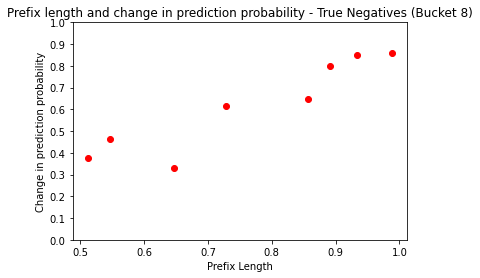

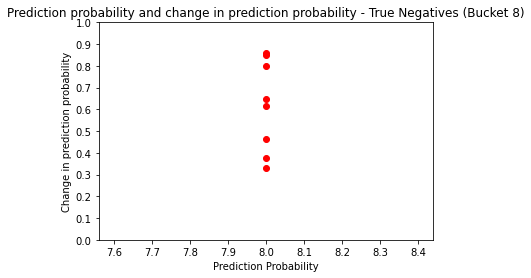

Category 2 of 4. Instance 1 of 6
Creating explanations
[('index__month_7', -0.34256724, 0.34256724), ('index__Qty_Completed_2', -0.294157, 0.294157), ('index__Report_Type_5_S', 0.28406572, 0.28406572), ('index__month_5', -0.2816487, 0.2816487), ('index__Report_Type_5_D', 0.2579794, 0.2579794), ('index__Qty_Completed_6', 0.24793231, 0.24793231), ('index__activity_duration_2', -0.24346758, 0.24346758), ('index__hour_6', 0.24148601, 0.24148601), ('index__timesincemidnight_6', 0.2390447, 0.2390447), ('index__open_cases_3', -0.2350827, 0.2350827), ('index__timesincemidnight_4', 0.21929252, 0.21929252), ('index__hour_0', -0.20178828, 0.20178828), ('index__open_cases_6', -0.1987344, 0.1987344), ('index__timesincemidnight_5', 0.19077346, 0.19077346), ('index__activity_duration_7', -0.18657115, 0.18657115), ('index__open_cases_1', -0.1760022, 0.1760022), ('index__open_cases_5', 0.17302358, 0.17302358), ('index__Activity_4_Turning & Milling - Machine 5', 0.16349572, 0.16349572), ('index__timesin

Creating explanations
[('index__Resource_6_ID4429', 0.4826572, 0.4826572), ('index__Qty_Completed_6', -0.45044267, 0.45044267), ('index__month_7', -0.34202296, 0.34202296), ('index__timesincemidnight_1', -0.30233252, 0.30233252), ('index__open_cases_3', -0.2837937, 0.2837937), ('index__timesincelastevent_6', 0.2782279, 0.2782279), ('index__month_5', -0.26448637, 0.26448637), ('index__Report_Type_4_S', 0.26387697, 0.26387697), ('static__Work_Order_Qty', 0.24946688, 0.24946688), ('index__timesincecasestart_2', -0.23844206, 0.23844206), ('index__timesincelastevent_3', 0.1967496, 0.1967496), ('index__timesincecasestart_7', 0.19543079, 0.19543079), ('index__activity_duration_7', -0.185718, 0.185718), ('index__Report_Type_3_D', 0.18413043, 0.18413043), ('index__weekday_0', 0.18179028, 0.18179028), ('index__Qty_Completed_5', -0.17344338, 0.17344338), ('index__open_cases_6', -0.16586402, 0.16586402), ('index__Activity_4_Turning & Milling - Machine 5', 0.16080186, 0.16080186), ('index__weekday_

Creating explanations
[('index__open_cases_6', -0.40500852, 0.40500852), ('index__timesincemidnight_1', 0.36523902, 0.36523902), ('index__Report_Type_5_D', 0.31350774, 0.31350774), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.2989657, 0.2989657), ('index__open_cases_5', -0.27475682, 0.27475682), ('index__month_5', -0.27460465, 0.27460465), ('index__month_7', -0.27128407, 0.27128407), ('index__hour_6', 0.26583534, 0.26583534), ('index__timesincecasestart_7', 0.2637953, 0.2637953), ('index__Qty_Completed_5', 0.26106656, 0.26106656), ('index__timesincemidnight_6', 0.25774243, 0.25774243), ('index__open_cases_3', -0.24974844, 0.24974844), ('index__Qty_Completed_2', -0.24798152, 0.24798152), ('index__Report_Type_5_S', 0.24457309, 0.24457309), ('index__Activity_1_Turning & Milling - Machine 4', 0.23848875, 0.23848875), ('index__Activity_5_Turning & Milling - Machine 4', 0.23346817, 0.23346817), ('index__activity_duration_0', 0.20871072, 0.20871072), ('index__timesincemidnight_4', 

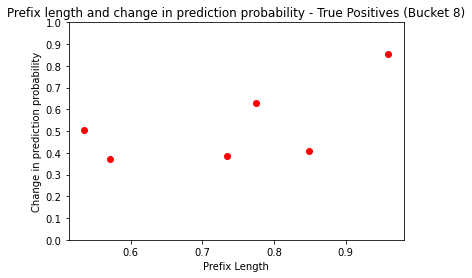

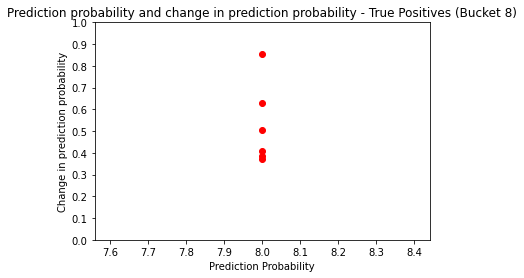

Category 3 of 4. Instance 1 of 9
Creating explanations
[('index__open_cases_6', -0.3434196, 0.3434196), ('index__month_7', -0.30235064, 0.30235064), ('index__hour_1', -0.26706263, 0.26706263), ('index__month_5', -0.26692238, 0.26692238), ('index__timesincelastevent_6', 0.26347938, 0.26347938), ('static__Work_Order_Qty', 0.2542178, 0.2542178), ('index__open_cases_1', 0.24110162, 0.24110162), ('index__open_cases_3', -0.23472519, 0.23472519), ('index__Report_Type_5_D', 0.23082323, 0.23082323), ('index__timesincelastevent_5', 0.20898765, 0.20898765), ('index__activity_duration_2', 0.20499209, 0.20499209), ('index__activity_duration_7', -0.20112345, 0.20112345), ('index__Activity_3_Turning & Milling - Machine 5', 0.19030519, 0.19030519), ('index__timesincelastevent_1', 0.1694044, 0.1694044), ('index__timesincecasestart_2', -0.16642494, 0.16642494), ('index__activity_duration_1', 0.16170526, 0.16170526), ('index__timesincecasestart_7', 0.16066103, 0.16066103), ('index__timesincemidnight_6', 

Creating explanations
[('index__timesincemidnight_1', 0.35556915, 0.35556915), ('index__month_7', -0.2892861, 0.2892861), ('index__Qty_Completed_5', 0.28687835, 0.28687835), ('index__timesincelastevent_6', 0.27158406, 0.27158406), ('index__Report_Type_4_S', 0.26667807, 0.26667807), ('index__hour_6', 0.25844613, 0.25844613), ('index__open_cases_3', -0.24733348, 0.24733348), ('index__timesincemidnight_6', 0.24132556, 0.24132556), ('index__open_cases_6', -0.21400516, 0.21400516), ('index__activity_duration_0', -0.20875122, 0.20875122), ('index__month_5', -0.19967614, 0.19967614), ('index__Qty_Completed_6', 0.1989863, 0.1989863), ('index__hour_1', 0.1967407, 0.1967407), ('index__activity_duration_2', 0.19554837, 0.19554837), ('index__hour_0', -0.1943085, 0.1943085), ('index__timesincelastevent_3', -0.19139706, 0.19139706), ('index__Activity_2_Turning & Milling - Machine 8', -0.17900778, 0.17900778), ('index__timesincemidnight_5', 0.15685017, 0.15685017), ('index__activity_duration_1', 0.15

Creating explanations
[('index__Qty_Completed_6', -0.4042435, 0.4042435), ('index__open_cases_6', -0.40239197, 0.40239197), ('index__month_7', -0.35322315, 0.35322315), ('index__activity_duration_7', 0.318972, 0.318972), ('index__open_cases_3', -0.28759462, 0.28759462), ('index__month_5', -0.25804725, 0.25804725), ('index__timesincelastevent_6', -0.2471827, 0.2471827), ('index__hour_6', 0.24524064, 0.24524064), ('index__Qty_Completed_5', 0.23463252, 0.23463252), ('index__activity_duration_5', 0.22436018, 0.22436018), ('index__Report_Type_4_S', 0.21549518, 0.21549518), ('index__hour_0', -0.21349801, 0.21349801), ('index__open_cases_7', -0.20593944, 0.20593944), ('index__timesincelastevent_7', 0.20193025, 0.20193025), ('index__activity_duration_1', 0.19928971, 0.19928971), ('index__Resource.1_3_Machine 9 - Turning & Milling', -0.19365105, 0.19365105), ('index__Report_Type_3_D', 0.18581565, 0.18581565), ('index__hour_2', -0.17901598, 0.17901598), ('index__Report_Type_3_S', 0.16649051, 0.1

Creating explanations
[('index__Qty_Completed_6', -0.5124304, 0.5124304), ('index__open_cases_6', -0.4221433, 0.4221433), ('index__timesincemidnight_1', 0.30131772, 0.30131772), ('index__open_cases_3', -0.29194948, 0.29194948), ('index__Resource.1_3_Machine 4 - Turning & Milling', 0.2552764, 0.2552764), ('index__month_5', -0.24302259, 0.24302259), ('index__hour_1', 0.23611577, 0.23611577), ('index__timesincelastevent_7', 0.23528667, 0.23528667), ('index__Activity_3_Turning & Milling - Machine 4', 0.23215578, 0.23215578), ('index__Qty_Completed_1', -0.21603899, 0.21603899), ('index__Activity_5_Turning & Milling Q.C.', -0.21040893, 0.21040893), ('index__activity_duration_2', 0.20048317, 0.20048317), ('index__Qty_Completed_5', -0.19455074, 0.19455074), ('index__Activity_1_Turning & Milling - Machine 4', 0.18791659, 0.18791659), ('index__Report_Type_3_D', 0.17779289, 0.17779289), ('index__month_7', -0.17741266, 0.17741266), ('index__timesincelastevent_3', -0.17689478, 0.17689478), ('index_

Creating explanations
[('index__Qty_Completed_6', -0.44501805, 0.44501805), ('index__timesincelastevent_6', -0.40667996, 0.40667996), ('index__timesincemidnight_1', -0.3932562, 0.3932562), ('index__timesincemidnight_6', 0.33305648, 0.33305648), ('index__activity_duration_1', -0.32377964, 0.32377964), ('index__timesincecasestart_2', -0.31455562, 0.31455562), ('index__activity_duration_7', 0.2963258, 0.2963258), ('static__Work_Order_Qty', 0.28809947, 0.28809947), ('index__month_7', -0.27574426, 0.27574426), ('index__month_5', -0.26292118, 0.26292118), ('index__open_cases_3', -0.2277153, 0.2277153), ('index__Activity_5_Turning & Milling - Machine 6', 0.20691183, 0.20691183), ('index__hour_2', -0.20581776, 0.20581776), ('index__hour_6', 0.20221011, 0.20221011), ('index__timesincelastevent_1', -0.18603685, 0.18603685), ('index__Qty_Completed_5', -0.17463537, 0.17463537), ('index__timesincecasestart_7', 0.17433298, 0.17433298), ('index__hour_1', -0.16955927, 0.16955927), ('index__open_cases_

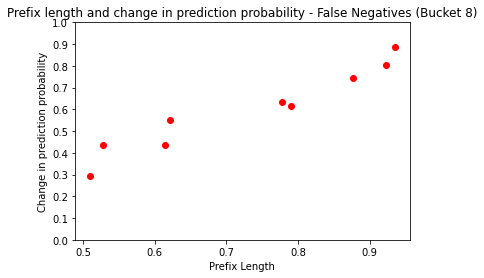

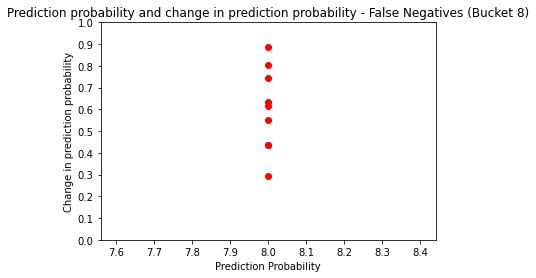

Category 4 of 4. Instance 1 of 5
Creating explanations
[('index__timesincelastevent_6', -0.3911032, 0.3911032), ('index__activity_duration_7', 0.319005, 0.319005), ('index__month_7', -0.30632496, 0.30632496), ('index__open_cases_3', -0.27218753, 0.27218753), ('index__month_5', -0.26318613, 0.26318613), ('index__timesincecasestart_7', -0.26118782, 0.26118782), ('index__Qty_Completed_5', 0.25199157, 0.25199157), ('index__Qty_Completed_6', 0.24420884, 0.24420884), ('index__activity_duration_1', -0.24401182, 0.24401182), ('index__timesincemidnight_1', 0.20012017, 0.20012017), ('index__hour_0', 0.1982368, 0.1982368), ('index__timesincelastevent_1', -0.1969615, 0.1969615), ('index__activity_duration_2', -0.1845975, 0.1845975), ('index__timesincelastevent_3', 0.18333313, 0.18333313), ('index__hour_2', 0.16677491, 0.16677491), ('index__open_cases_6', -0.16017585, 0.16017585), ('index__weekday_3', 0.14975084, 0.14975084), ('index__open_cases_5', 0.1495569, 0.1495569), ('index__Qty_Completed_2',

Creating explanations
[('index__open_cases_6', -0.40791515, 0.40791515), ('index__Qty_Completed_6', -0.39550245, 0.39550245), ('index__Qty_Completed_2', -0.31389567, 0.31389567), ('index__Qty_Completed_5', 0.28355423, 0.28355423), ('index__month_7', -0.27381104, 0.27381104), ('index__month_5', -0.26286784, 0.26286784), ('index__Activity_5_Turning & Milling - Machine 6', 0.23753291, 0.23753291), ('index__activity_duration_2', -0.22597535, 0.22597535), ('static__Work_Order_Qty', 0.21849379, 0.21849379), ('index__hour_0', 0.21483184, 0.21483184), ('index__timesincelastevent_6', 0.20155108, 0.20155108), ('index__Qty_Completed_7', -0.19995163, 0.19995163), ('index__activity_duration_1', 0.19883606, 0.19883606), ('index__Resource.1_7_Machine 6 - Turning & Milling', 0.1957914, 0.1957914), ('index__weekday_0', 0.18632779, 0.18632779), ('index__activity_duration_5', 0.18614924, 0.18614924), ('index__hour_1', -0.18052639, 0.18052639), ('index__timesincelastevent_1', 0.17738098, 0.17738098), ('in

Creating explanations
[('index__timesincelastevent_6', 0.29645744, 0.29645744), ('index__hour_2', 0.28485793, 0.28485793), ('index__activity_duration_6', -0.2803304, 0.2803304), ('index__open_cases_3', -0.27941206, 0.27941206), ('index__Qty_Completed_5', 0.2713075, 0.2713075), ('index__activity_duration_7', -0.25689656, 0.25689656), ('index__Qty_Completed_6', 0.25666538, 0.25666538), ('index__open_cases_1', -0.23245989, 0.23245989), ('index__timesincemidnight_1', 0.2218994, 0.2218994), ('index__month_5', -0.21873756, 0.21873756), ('index__month_7', -0.21288797, 0.21288797), ('index__activity_duration_2', 0.18598858, 0.18598858), ('index__timesincelastevent_7', 0.18517984, 0.18517984), ('index__timesincecasestart_7', 0.17762554, 0.17762554), ('index__timesincelastevent_1', 0.1735767, 0.1735767), ('index__timesincelastevent_3', 0.17235465, 0.17235465), ('index__activity_duration_4', -0.16955385, 0.16955385), ('index__activity_duration_1', 0.16120705, 0.16120705), ('index__open_cases_5', 

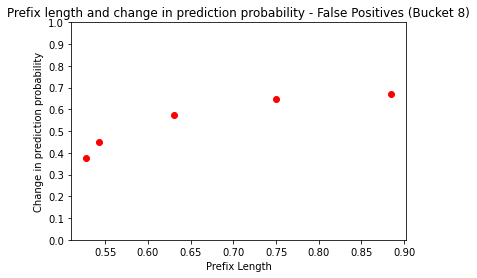

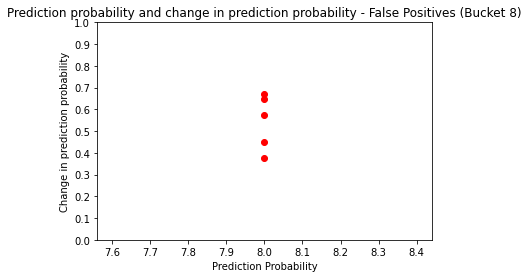

Bucket 9
Generating distributions for bucket
1 of 623 features
2 of 623 features
3 of 623 features
4 of 623 features
5 of 623 features
6 of 623 features
7 of 623 features
8 of 623 features
9 of 623 features
10 of 623 features
11 of 623 features
12 of 623 features
13 of 623 features
14 of 623 features
15 of 623 features
16 of 623 features
17 of 623 features
18 of 623 features
19 of 623 features
20 of 623 features
21 of 623 features
22 of 623 features
23 of 623 features
24 of 623 features
25 of 623 features
26 of 623 features
27 of 623 features
28 of 623 features
29 of 623 features
30 of 623 features
31 of 623 features
32 of 623 features
33 of 623 features
34 of 623 features
35 of 623 features
36 of 623 features
37 of 623 features
38 of 623 features
39 of 623 features
40 of 623 features
41 of 623 features
42 of 623 features
43 of 623 features
44 of 623 features
45 of 623 features
46 of 623 features
47 of 623 features
48 of 623 features
49 of 623 features
50 of 623 features
51 of 623 feat

463 of 623 features
464 of 623 features
465 of 623 features
466 of 623 features
467 of 623 features
468 of 623 features
469 of 623 features
470 of 623 features
471 of 623 features
472 of 623 features
473 of 623 features
474 of 623 features
475 of 623 features
476 of 623 features
477 of 623 features
478 of 623 features
479 of 623 features
480 of 623 features
481 of 623 features
482 of 623 features
483 of 623 features
484 of 623 features
485 of 623 features
486 of 623 features
487 of 623 features
488 of 623 features
489 of 623 features
490 of 623 features
491 of 623 features
492 of 623 features
493 of 623 features
494 of 623 features
495 of 623 features
496 of 623 features
497 of 623 features
498 of 623 features
499 of 623 features
500 of 623 features
501 of 623 features
502 of 623 features
503 of 623 features
504 of 623 features
505 of 623 features
506 of 623 features
507 of 623 features
508 of 623 features
509 of 623 features
510 of 623 features
511 of 623 features
512 of 623 features


Creating explanations
[('index__activity_duration_7', -0.4062583, 0.4062583), ('index__Qty_Completed_6', 0.39876518, 0.39876518), ('index__Report_Type_3_S', 0.3076865, 0.3076865), ('index__open_cases_8', -0.29081944, 0.29081944), ('index__Report_Type_5_S', 0.26057044, 0.26057044), ('index__weekday_8', -0.25432628, 0.25432628), ('index__timesincemidnight_4', -0.24922588, 0.24922588), ('index__timesincecasestart_6', -0.24877872, 0.24877872), ('index__timesincelastevent_4', -0.24129146, 0.24129146), ('index__timesincecasestart_2', 0.19269687, 0.19269687), ('static__Work_Order_Qty', -0.17070358, 0.17070358), ('index__activity_duration_6', -0.15700787, 0.15700787), ('index__Resource_0_ID4219', -0.15573768, 0.15573768), ('index__Report_Type_5_D', 0.151941, 0.151941), ('index__Activity_5_Turning - Machine 8', 0.14854619, 0.14854619), ('index__weekday_0', 0.14441513, 0.14441513), ('index__Activity_5_Turning & Milling Q.C.', 0.13406111, 0.13406111), ('index__timesincecasestart_3', -0.12524632, 

Creating explanations
[('index__Qty_Completed_6', -0.41461155, 0.41461155), ('index__timesincemidnight_6', 0.40232447, 0.40232447), ('index__Qty_Completed_4', -0.25652304, 0.25652304), ('index__hour_6', 0.25633737, 0.25633737), ('index__activity_duration_7', -0.2485732, 0.2485732), ('index__timesincemidnight_4', -0.24436629, 0.24436629), ('index__timesincemidnight_1', -0.22216964, 0.22216964), ('index__timesincecasestart_6', -0.21270657, 0.21270657), ('index__hour_4', -0.20832619, 0.20832619), ('index__open_cases_3', 0.18897627, 0.18897627), ('index__activity_duration_6', -0.16976334, 0.16976334), ('index__Qty_Completed_3', 0.14728323, 0.14728323), ('index__open_cases_0', 0.14613862, 0.14613862), ('index__month_4', -0.13888226, 0.13888226), ('index__Resource.1_3_Machine 1 - Lapping', 0.13362491, 0.13362491), ('index__weekday_8', 0.12750518, 0.12750518), ('index__Resource.1_1_Quality Check 1', -0.12435523, 0.12435523), ('index__hour_2', 0.12327621, 0.12327621), ('index__timesincelasteve

Creating explanations
[('index__Qty_Completed_6', -0.46164674, 0.46164674), ('index__weekday_8', -0.31908056, 0.31908056), ('index__activity_duration_7', -0.27320766, 0.27320766), ('index__Resource_6_ID0998', -0.2588005, 0.2588005), ('index__Qty_Completed_2', -0.23652476, 0.23652476), ('index__timesincecasestart_2', -0.23238717, 0.23238717), ('index__timesincelastevent_1', -0.22953053, 0.22953053), ('index__timesincemidnight_4', -0.18479846, 0.18479846), ('index__hour_3', 0.17556517, 0.17556517), ('index__open_cases_3', 0.15520817, 0.15520817), ('index__Resource.1_3_Machine 1 - Lapping', 0.15413557, 0.15413557), ('index__open_cases_8', -0.15340525, 0.15340525), ('index__activity_duration_6', 0.15123302, 0.15123302), ('index__timesincelastevent_3', -0.13896719, 0.13896719), ('index__timesincecasestart_8', -0.13812797, 0.13812797), ('index__hour_6', -0.13186333, 0.13186333), ('index__Activity_5_Turning & Milling Q.C.', 0.13019353, 0.13019353), ('index__Qty_Completed_0', -0.13002522, 0.13

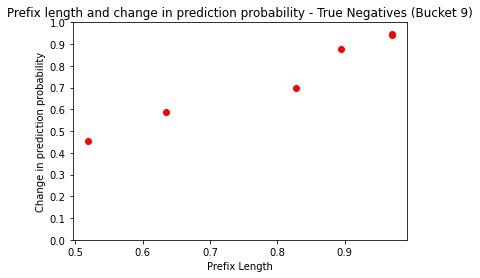

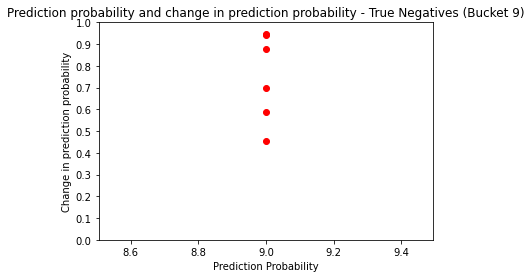

Category 2 of 4. Instance 1 of 8
Creating explanations
[('index__activity_duration_7', 0.35100088, 0.35100088), ('index__Report_Type_4_S', 0.3086145, 0.3086145), ('index__timesincemidnight_4', -0.26756787, 0.26756787), ('index__hour_4', -0.26570517, 0.26570517), ('index__timesincemidnight_6', 0.2567276, 0.2567276), ('index__Qty_Completed_6', -0.2560329, 0.2560329), ('index__Report_Type_3_S', 0.2465068, 0.2465068), ('index__hour_6', 0.23185605, 0.23185605), ('index__weekday_8', 0.21473569, 0.21473569), ('index__open_cases_1', 0.1800575, 0.1800575), ('index__open_cases_0', 0.17849687, 0.17849687), ('index__open_cases_8', -0.17777126, 0.17777126), ('index__hour_3', -0.17750311, 0.17750311), ('index__weekday_4', 0.15465762, 0.15465762), ('index__activity_duration_1', 0.15429792, 0.15429792), ('index__timesincecasestart_6', 0.1526472, 0.1526472), ('index__timesincemidnight_1', -0.14152603, 0.14152603), ('index__weekday_7', 0.14146778, 0.14146778), ('index__weekday_0', -0.14014202, 0.1401420

Creating explanations
[('index__Qty_Completed_6', -0.4611149, 0.4611149), ('index__activity_duration_7', 0.43381444, 0.43381444), ('index__timesincemidnight_1', 0.27809966, 0.27809966), ('index__activity_duration_8', 0.25880525, 0.25880525), ('index__Activity_7_Turning & Milling - Machine 4', 0.18598577, 0.18598577), ('index__open_cases_8', -0.18532902, 0.18532902), ('index__Qty_Completed_4', -0.18516992, 0.18516992), ('index__Qty_Completed_2', -0.17283851, 0.17283851), ('index__activity_duration_2', -0.16733137, 0.16733137), ('index__timesincecasestart_6', 0.16697143, 0.16697143), ('index__Qty_Completed_8', 0.16520838, 0.16520838), ('index__Resource_8_ID4167', 0.15688029, 0.15688029), ('index__hour_1', 0.15414637, 0.15414637), ('index__Resource.1_5_Machine 4 - Turning & Milling', 0.14999275, 0.14999275), ('index__timesincemidnight_3', -0.14803644, 0.14803644), ('index__timesincemidnight_4', -0.14157787, 0.14157787), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.14050643, 0.1

Creating explanations
[('index__activity_duration_7', 0.44404304, 0.44404304), ('index__Activity_8_Turning & Milling - Machine 6', 0.29745603, 0.29745603), ('index__timesincecasestart_6', 0.2937934, 0.2937934), ('index__activity_duration_0', -0.2809898, 0.2809898), ('index__timesincecasestart_8', 0.25972787, 0.25972787), ('index__timesincelastevent_4', -0.25883323, 0.25883323), ('index__weekday_0', -0.2587713, 0.2587713), ('index__Qty_Completed_0', -0.20940624, 0.20940624), ('index__open_cases_3', 0.20179503, 0.20179503), ('index__timesincecasestart_2', 0.18837778, 0.18837778), ('index__weekday_8', -0.17464483, 0.17464483), ('index__activity_duration_6', -0.1687816, 0.1687816), ('index__open_cases_8', -0.15370432, 0.15370432), ('index__Resource_6_ID4429', 0.15149438, 0.15149438), ('index__Activity_5_Turning & Milling Q.C.', 0.13312319, 0.13312319), ('index__month_4', -0.12842697, 0.12842697), ('index__Qty_Completed_6', 0.123542555, 0.123542555), ('index__open_cases_1', -0.1203993, 0.12

Creating explanations
[('index__timesincemidnight_4', 0.5450872, 0.5450872), ('index__timesincelastevent_7', -0.4055109, 0.4055109), ('index__Qty_Completed_6', 0.38546562, 0.38546562), ('index__timesincecasestart_8', 0.37353587, 0.37353587), ('index__activity_duration_7', -0.34287483, 0.34287483), ('index__activity_duration_0', 0.27408546, 0.27408546), ('index__timesincemidnight_1', 0.25303194, 0.25303194), ('index__hour_4', 0.2281272, 0.2281272), ('index__activity_duration_1', 0.22731766, 0.22731766), ('index__weekday_0', -0.22674708, 0.22674708), ('index__activity_duration_6', -0.22192019, 0.22192019), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.2118895, 0.2118895), ('index__timesincemidnight_6', 0.20763317, 0.20763317), ('index__timesincecasestart_6', 0.19351865, 0.19351865), ('index__hour_5', 0.18279992, 0.18279992), ('index__open_cases_0', 0.17659493, 0.17659493), ('index__Report_Type_3_S', 0.16693021, 0.16693021), ('index__hour_6', 0.16447464, 0.16447464), ('index__ti

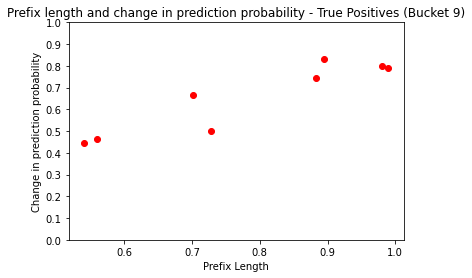

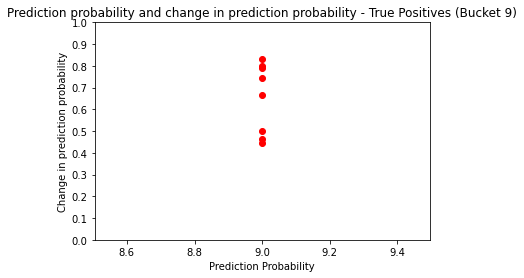

Category 3 of 4. Instance 1 of 5
Creating explanations
[('index__timesincelastevent_4', -0.39218405, 0.39218405), ('index__timesincelastevent_7', -0.32647896, 0.32647896), ('index__weekday_8', -0.3189289, 0.3189289), ('index__Qty_Completed_6', 0.30675352, 0.30675352), ('index__timesincecasestart_8', 0.26350227, 0.26350227), ('index__timesincecasestart_6', 0.25158468, 0.25158468), ('index__open_cases_8', -0.24232431, 0.24232431), ('index__Qty_Completed_0', -0.23038052, 0.23038052), ('index__activity_duration_0', -0.21509738, 0.21509738), ('index__activity_duration_7', 0.20128942, 0.20128942), ('index__activity_duration_6', 0.17015411, 0.17015411), ('index__Qty_Completed_7', 0.16434029, 0.16434029), ('index__open_cases_1', -0.15110771, 0.15110771), ('index__weekday_7', -0.14223805, 0.14223805), ('index__weekday_0', 0.12513842, 0.12513842), ('index__Report_Type_4_S', -0.12453776, 0.12453776), ('index__month_4', -0.124470524, 0.124470524), ('index__timesincemidnight_4', -0.123314, 0.123314

Creating explanations
[('index__Activity_5_Turning & Milling Q.C.', -0.48852968, 0.48852968), ('index__Qty_Completed_6', 0.35250667, 0.35250667), ('index__timesincelastevent_7', -0.25120148, 0.25120148), ('index__weekday_0', -0.24841703, 0.24841703), ('index__timesincemidnight_6', 0.23000073, 0.23000073), ('index__Activity_2_Turning & Milling - Machine 9', 0.22854227, 0.22854227), ('index__timesincecasestart_6', -0.2223731, 0.2223731), ('index__activity_duration_6', -0.18750946, 0.18750946), ('index__weekday_8', -0.17385922, 0.17385922), ('index__timesincemidnight_1', 0.17374955, 0.17374955), ('index__activity_duration_2', -0.17216486, 0.17216486), ('index__hour_1', 0.17021291, 0.17021291), ('index__Qty_Completed_8', 0.16996466, 0.16996466), ('index__open_cases_0', 0.16970314, 0.16970314), ('index__timesincemidnight_4', -0.16698551, 0.16698551), ('index__hour_3', 0.16580792, 0.16580792), ('index__hour_6', 0.16001523, 0.16001523), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0

Creating explanations
[('index__Activity_5_Turning & Milling Q.C.', -0.65158796, 0.65158796), ('index__Qty_Completed_6', -0.3809866, 0.3809866), ('index__hour_4', -0.29107484, 0.29107484), ('index__timesincemidnight_1', 0.27838182, 0.27838182), ('index__activity_duration_7', -0.27370554, 0.27370554), ('index__timesincecasestart_6', 0.2453571, 0.2453571), ('index__weekday_0', -0.23503315, 0.23503315), ('index__Report_Type_3_S', 0.22351697, 0.22351697), ('index__open_cases_8', -0.223255, 0.223255), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.2118895, 0.2118895), ('index__timesincemidnight_4', -0.21055433, 0.21055433), ('index__weekday_8', 0.18657427, 0.18657427), ('index__activity_duration_0', -0.16439159, 0.16439159), ('index__hour_1', 0.14493912, 0.14493912), ('index__hour_6', -0.1382422, 0.1382422), ('index__Qty_Completed_7', 0.13821344, 0.13821344), ('index__timesincelastevent_3', -0.13627598, 0.13627598), ('index__Resource_3_ID4932', 0.13557425, 0.13557425), ('index__Qty

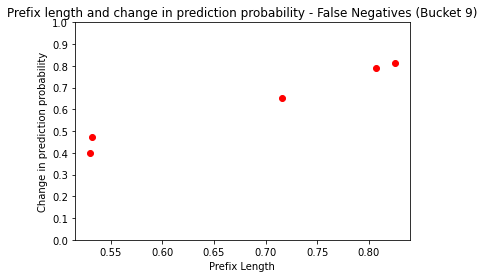

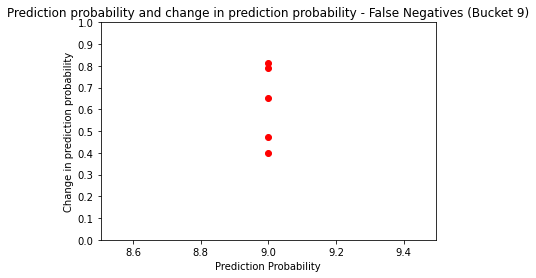

Category 4 of 4. Instance 1 of 5
Creating explanations
[('index__timesincemidnight_1', -0.31488377, 0.31488377), ('index__Qty_Completed_6', 0.2996776, 0.2996776), ('index__weekday_8', -0.2872264, 0.2872264), ('index__timesincecasestart_8', 0.28152013, 0.28152013), ('index__weekday_0', -0.24370839, 0.24370839), ('index__hour_7', 0.24220191, 0.24220191), ('index__timesincecasestart_6', 0.23816596, 0.23816596), ('index__open_cases_8', -0.22542816, 0.22542816), ('index__Report_Type_3_S', 0.22351412, 0.22351412), ('index__activity_duration_0', -0.22346087, 0.22346087), ('static__Work_Order_Qty', -0.202782, 0.202782), ('index__Report_Type_5_D', 0.19523387, 0.19523387), ('index__weekday_7', -0.19265954, 0.19265954), ('index__timesincelastevent_7', 0.18558712, 0.18558712), ('index__Report_Type_5_S', 0.18138361, 0.18138361), ('index__timesincecasestart_7', 0.16728252, 0.16728252), ('index__timesincemidnight_4', -0.16515991, 0.16515991), ('index__hour_3', 0.15807462, 0.15807462), ('index__timesi

Creating explanations
[('index__Report_Type_4_S', 0.36943513, 0.36943513), ('index__Qty_Completed_6', 0.3140696, 0.3140696), ('index__hour_7', 0.2672446, 0.2672446), ('index__Report_Type_5_S', 0.23934256, 0.23934256), ('index__timesincelastevent_1', 0.23853795, 0.23853795), ('index__weekday_0', -0.23025651, 0.23025651), ('index__hour_1', 0.2281788, 0.2281788), ('index__timesincecasestart_6', -0.22504935, 0.22504935), ('index__timesincelastevent_7', 0.1967555, 0.1967555), ('static__Work_Order_Qty', -0.18756448, 0.18756448), ('index__Activity_7_Turning & Milling - Machine 4', 0.17516065, 0.17516065), ('index__timesincemidnight_4', -0.17278652, 0.17278652), ('index__Report_Type_5_D', 0.1705956, 0.1705956), ('index__timesincecasestart_3', -0.15404932, 0.15404932), ('index__open_cases_3', 0.15153976, 0.15153976), ('index__hour_6', -0.14575425, 0.14575425), ('index__open_cases_8', -0.143069, 0.143069), ('index__hour_2', 0.13737309, 0.13737309), ('index__timesincecasestart_8', -0.13591275, 0.

Creating explanations
[('index__activity_duration_7', 0.57979065, 0.57979065), ('index__Qty_Completed_6', 0.36621746, 0.36621746), ('index__activity_duration_8', 0.29243845, 0.29243845), ('index__timesincelastevent_7', 0.2739664, 0.2739664), ('index__timesincemidnight_4', -0.2649923, 0.2649923), ('index__open_cases_8', -0.23023914, 0.23023914), ('index__hour_4', -0.21816032, 0.21816032), ('index__timesincemidnight_1', -0.2176079, 0.2176079), ('index__weekday_0', 0.20837145, 0.20837145), ('index__weekday_8', 0.20442414, 0.20442414), ('index__open_cases_0', 0.17685045, 0.17685045), ('index__timesincecasestart_6', 0.16293743, 0.16293743), ('index__open_cases_1', 0.16106279, 0.16106279), ('index__Qty_Completed_7', 0.15668021, 0.15668021), ('index__hour_3', 0.14807318, 0.14807318), ('index__timesincelastevent_4', 0.14392895, 0.14392895), ('index__weekday_5', 0.1410755, 0.1410755), ('index__month_4', -0.13888198, 0.13888198), ('index__activity_duration_2', 0.13197924, 0.13197924), ('index__Q

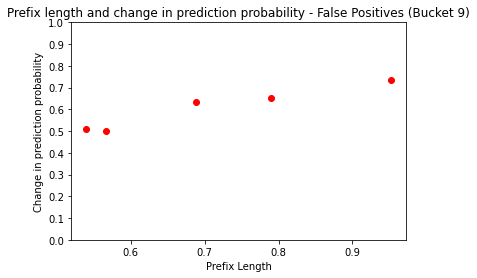

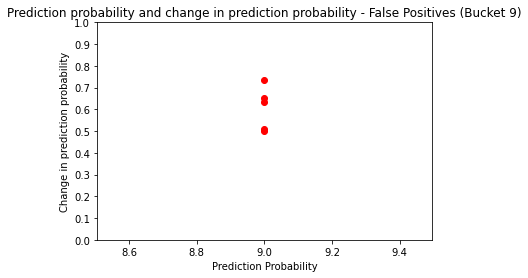

Bucket 10
Generating distributions for bucket
1 of 684 features
2 of 684 features
3 of 684 features
4 of 684 features
5 of 684 features
6 of 684 features
7 of 684 features
8 of 684 features
9 of 684 features
10 of 684 features
11 of 684 features
12 of 684 features
13 of 684 features
14 of 684 features
15 of 684 features
16 of 684 features
17 of 684 features
18 of 684 features
19 of 684 features
20 of 684 features
21 of 684 features
22 of 684 features
23 of 684 features
24 of 684 features
25 of 684 features
26 of 684 features
27 of 684 features
28 of 684 features
29 of 684 features
30 of 684 features
31 of 684 features
32 of 684 features
33 of 684 features
34 of 684 features
35 of 684 features
36 of 684 features
37 of 684 features
38 of 684 features
39 of 684 features
40 of 684 features
41 of 684 features
42 of 684 features
43 of 684 features
44 of 684 features
45 of 684 features
46 of 684 features
47 of 684 features
48 of 684 features
49 of 684 features
50 of 684 features
51 of 684 fea

530 of 684 features
531 of 684 features
532 of 684 features
533 of 684 features
534 of 684 features
535 of 684 features
536 of 684 features
537 of 684 features
538 of 684 features
539 of 684 features
540 of 684 features
541 of 684 features
542 of 684 features
543 of 684 features
544 of 684 features
545 of 684 features
546 of 684 features
547 of 684 features
548 of 684 features
549 of 684 features
550 of 684 features
551 of 684 features
552 of 684 features
553 of 684 features
554 of 684 features
555 of 684 features
556 of 684 features
557 of 684 features
558 of 684 features
559 of 684 features
560 of 684 features
561 of 684 features
562 of 684 features
563 of 684 features
564 of 684 features
565 of 684 features
566 of 684 features
567 of 684 features
568 of 684 features
569 of 684 features
570 of 684 features
571 of 684 features
572 of 684 features
573 of 684 features
574 of 684 features
575 of 684 features
576 of 684 features
577 of 684 features
578 of 684 features
579 of 684 features


Creating explanations
[('index__timesincelastevent_7', -0.34512076, 0.34512076), ('index__hour_1', -0.33573157, 0.33573157), ('index__timesincemidnight_3', -0.31080154, 0.31080154), ('index__Qty_Completed_8', 0.29777876, 0.29777876), ('index__activity_duration_0', -0.2958516, 0.2958516), ('index__activity_duration_1', 0.28027257, 0.28027257), ('index__timesincemidnight_8', 0.27866334, 0.27866334), ('index__activity_duration_7', -0.24570747, 0.24570747), ('static__Work_Order_Qty', 0.24011466, 0.24011466), ('index__hour_8', 0.19197257, 0.19197257), ('index__month_6', -0.16934039, 0.16934039), ('index__activity_duration_4', 0.1656993, 0.1656993), ('index__hour_5', 0.16390117, 0.16390117), ('index__activity_duration_8', 0.14768003, 0.14768003), ('index__timesincecasestart_6', 0.14625326, 0.14625326), ('index__hour_2', -0.14227752, 0.14227752), ('index__activity_duration_9', -0.1349588, 0.1349588), ('index__month_0', 0.1285249, 0.1285249), ('index__Qty_Completed_6', -0.12295884, 0.12295884)

Creating explanations
[('index__Activity_5_Lapping - Machine 1', -0.3020807, 0.3020807), ('index__activity_duration_1', 0.29545462, 0.29545462), ('index__Resource.1_1_Machine 8 - Turning & Milling', -0.2592475, 0.2592475), ('index__hour_1', -0.20583211, 0.20583211), ('index__Qty_Completed_9', -0.20123643, 0.20123643), ('index__Activity_4_Turning & Milling Q.C.', 0.19959742, 0.19959742), ('index__Activity_1_Turning & Milling - Machine 8', -0.19308397, 0.19308397), ('index__timesincemidnight_2', 0.18892632, 0.18892632), ('index__Qty_Completed_6', 0.18316217, 0.18316217), ('index__timesincelastevent_6', 0.17901728, 0.17901728), ('index__timesincemidnight_3', 0.16491869, 0.16491869), ('index__Resource_1_ID4219', -0.1516367, 0.1516367), ('index__timesincelastevent_7', 0.15149947, 0.15149947), ('index__month_0', 0.1492641, 0.1492641), ('index__timesincecasestart_6', 0.14215869, 0.14215869), ('index__Qty_Completed_2', -0.13440324, 0.13440324), ('index__timesincelastevent_1', 0.13276413, 0.132

Creating explanations
[('index__hour_5', 0.3271891, 0.3271891), ('index__timesincemidnight_3', -0.26670527, 0.26670527), ('index__activity_duration_7', -0.25895524, 0.25895524), ('index__timesincemidnight_4', 0.2511935, 0.2511935), ('index__Resource.1_1_Machine 8 - Turning & Milling', -0.24062288, 0.24062288), ('index__timesincemidnight_5', 0.23487914, 0.23487914), ('index__activity_duration_1', -0.2252774, 0.2252774), ('index__timesincemidnight_8', -0.21919772, 0.21919772), ('index__weekday_8', 0.19532815, 0.19532815), ('index__Resource_7_ID4882', -0.19447231, 0.19447231), ('index__Qty_Completed_9', 0.18734872, 0.18734872), ('index__hour_1', 0.17594254, 0.17594254), ('index__timesincelastevent_4', 0.1754392, 0.1754392), ('index__Activity_1_Turning & Milling - Machine 8', -0.15633458, 0.15633458), ('index__hour_7', -0.15285368, 0.15285368), ('index__hour_2', -0.15197587, 0.15197587), ('index__weekday_5', -0.15125781, 0.15125781), ('index__timesincelastevent_3', -0.15075408, 0.15075408)

Creating explanations
[('index__timesincelastevent_7', -0.43482423, 0.43482423), ('index__Qty_Completed_9', -0.27977747, 0.27977747), ('index__hour_1', -0.25795916, 0.25795916), ('index__hour_5', 0.21438846, 0.21438846), ('index__activity_duration_3', -0.20840527, 0.20840527), ('index__Resource.1_1_Machine 8 - Turning & Milling', -0.20685005, 0.20685005), ('index__weekday_8', 0.1997983, 0.1997983), ('index__activity_duration_7', -0.19075218, 0.19075218), ('index__timesincemidnight_8', 0.18781045, 0.18781045), ('index__activity_duration_1', -0.1788895, 0.1788895), ('index__month_6', -0.17883222, 0.17883222), ('index__Activity_1_Turning & Milling - Machine 8', -0.17215194, 0.17215194), ('index__timesincelastevent_3', -0.16940261, 0.16940261), ('index__timesincecasestart_2', -0.16249974, 0.16249974), ('index__Qty_Completed_6', -0.1612531, 0.1612531), ('static__Work_Order_Qty', -0.15196288, 0.15196288), ('index__timesincecasestart_6', 0.14446852, 0.14446852), ('index__month_0', 0.13969806,

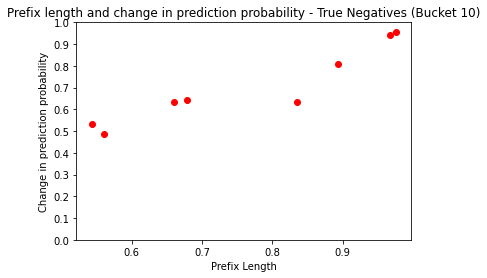

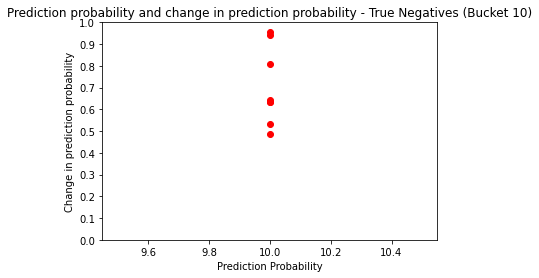

Category 2 of 4. Instance 1 of 6
Creating explanations
[('index__timesincelastevent_7', -0.4144624, 0.4144624), ('index__timesincemidnight_3', 0.36401987, 0.36401987), ('index__Qty_Completed_8', 0.310656, 0.310656), ('static__Work_Order_Qty', 0.30708778, 0.30708778), ('index__activity_duration_1', 0.25682408, 0.25682408), ('index__hour_1', 0.24900752, 0.24900752), ('index__hour_5', 0.22833684, 0.22833684), ('index__Activity_9_Lapping - Machine 1', 0.17918062, 0.17918062), ('index__month_6', -0.17074491, 0.17074491), ('index__month_0', 0.16747457, 0.16747457), ('index__activity_duration_7', -0.16571474, 0.16571474), ('index__hour_9', 0.16228989, 0.16228989), ('index__hour_8', -0.1555534, 0.1555534), ('index__timesincelastevent_3', -0.15527995, 0.15527995), ('index__timesincecasestart_6', -0.14374976, 0.14374976), ('index__weekday_8', -0.13537708, 0.13537708), ('index__hour_3', 0.12354702, 0.12354702), ('index__open_cases_2', 0.121376954, 0.121376954), ('index__timesincelastevent_4', -0.

Creating explanations
[('index__hour_1', -0.3295691, 0.3295691), ('index__timesincemidnight_8', -0.31875402, 0.31875402), ('index__timesincemidnight_4', 0.30540693, 0.30540693), ('static__Work_Order_Qty', 0.29057553, 0.29057553), ('index__timesincelastevent_7', -0.28941792, 0.28941792), ('index__weekday_8', 0.27108875, 0.27108875), ('index__Report_Type_5_D', 0.26631266, 0.26631266), ('index__Report_Type_5_S', 0.26553044, 0.26553044), ('index__timesincemidnight_3', -0.2573223, 0.2573223), ('index__timesincecasestart_2', 0.2088263, 0.2088263), ('index__Qty_Completed_9', -0.18944705, 0.18944705), ('index__month_6', -0.16942905, 0.16942905), ('index__Activity_8_Turning & Milling - Machine 5', 0.16818488, 0.16818488), ('index__activity_duration_4', 0.16671947, 0.16671947), ('index__Qty_Completed_6', 0.16290428, 0.16290428), ('index__timesincelastevent_2', -0.14795049, 0.14795049), ('index__timesincemidnight_6', 0.1421641, 0.1421641), ('index__hour_8', -0.13564302, 0.13564302), ('index__acti

Creating explanations
[('index__activity_duration_7', 0.4026811, 0.4026811), ('index__Qty_Completed_8', 0.3439472, 0.3439472), ('index__hour_1', 0.30320284, 0.30320284), ('index__activity_duration_1', 0.2806121, 0.2806121), ('index__timesincemidnight_3', 0.27775756, 0.27775756), ('static__Work_Order_Qty', 0.26512977, 0.26512977), ('index__timesincelastevent_4', 0.1897828, 0.1897828), ('index__Activity_4_Final Inspection Q.C.', -0.1875858, 0.1875858), ('index__timesincemidnight_7', 0.18146025, 0.18146025), ('index__hour_2', 0.1692341, 0.1692341), ('index__timesincemidnight_8', -0.1606366, 0.1606366), ('index__timesincelastevent_7', 0.15425545, 0.15425545), ('index__Qty_Completed_3', 0.14095734, 0.14095734), ('index__hour_5', 0.13854767, 0.13854767), ('index__timesincelastevent_5', 0.13835941, 0.13835941), ('index__activity_duration_8', 0.13723649, 0.13723649), ('index__open_cases_1', 0.13349229, 0.13349229), ('index__month_6', -0.1332871, 0.1332871), ('index__timesincelastevent_1', -0.1

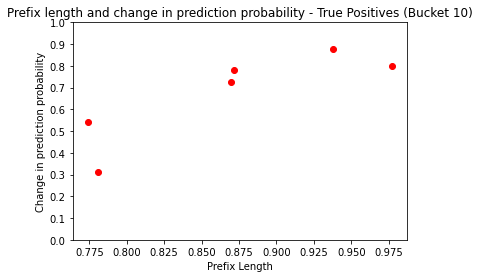

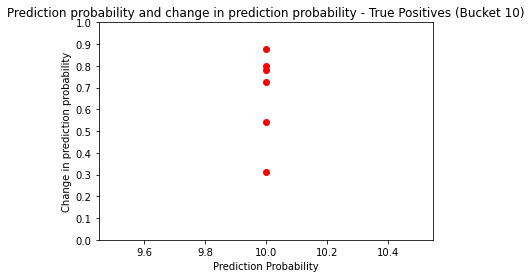

Category 3 of 4. Instance 1 of 5
Creating explanations
[('index__timesincemidnight_3', 0.41442856, 0.41442856), ('index__Qty_Completed_9', -0.3859414, 0.3859414), ('index__Qty_Completed_2', 0.3311165, 0.3311165), ('index__timesincelastevent_7', -0.30271417, 0.30271417), ('index__hour_1', 0.29446647, 0.29446647), ('index__hour_5', -0.28443322, 0.28443322), ('static__Work_Order_Qty', 0.2793273, 0.2793273), ('index__hour_2', 0.2085222, 0.2085222), ('index__activity_duration_9', -0.20847137, 0.20847137), ('index__activity_duration_1', -0.18750063, 0.18750063), ('index__Activity_4_Turning & Milling Q.C.', 0.18682876, 0.18682876), ('index__weekday_8', -0.17465936, 0.17465936), ('index__timesincelastevent_4', -0.17435578, 0.17435578), ('index__weekday_5', -0.17372137, 0.17372137), ('index__hour_3', 0.16256762, 0.16256762), ('index__activity_duration_3', 0.15234318, 0.15234318), ('index__hour_8', 0.14412825, 0.14412825), ('index__weekday_4', -0.14216173, 0.14216173), ('index__timesincemidnight

Creating explanations
[('index__timesincelastevent_7', 0.34988314, 0.34988314), ('index__Resource_7_ID4882', -0.33571246, 0.33571246), ('index__hour_1', 0.33561322, 0.33561322), ('index__timesincemidnight_3', -0.3062257, 0.3062257), ('index__Qty_Completed_6', -0.25984752, 0.25984752), ('index__activity_duration_7', -0.24415363, 0.24415363), ('index__Qty_Completed_2', 0.23958091, 0.23958091), ('index__activity_duration_0', -0.19592565, 0.19592565), ('index__weekday_8', 0.18802036, 0.18802036), ('index__timesincemidnight_4', -0.1779484, 0.1779484), ('index__hour_5', -0.17781633, 0.17781633), ('index__hour_7', -0.17634824, 0.17634824), ('index__hour_2', -0.17182387, 0.17182387), ('index__Report_Type_3_D', 0.16595434, 0.16595434), ('index__month_6', -0.16546056, 0.16546056), ('index__weekday_5', -0.15718278, 0.15718278), ('index__Report_Type_3_S', 0.15468313, 0.15468313), ('index__activity_duration_1', 0.15383372, 0.15383372), ('index__timesincemidnight_1', 0.14215213, 0.14215213), ('index

Creating explanations
[('index__hour_1', 0.29968363, 0.29968363), ('index__timesincemidnight_8', -0.28832912, 0.28832912), ('index__timesincemidnight_3', -0.28388125, 0.28388125), ('index__timesincelastevent_7', -0.23359717, 0.23359717), ('index__activity_duration_3', -0.22482382, 0.22482382), ('index__hour_2', -0.22187512, 0.22187512), ('index__Resource_5_ID0997', 0.21297917, 0.21297917), ('index__timesincelastevent_4', -0.20782417, 0.20782417), ('index__timesincemidnight_4', 0.20314202, 0.20314202), ('index__hour_8', -0.19688208, 0.19688208), ('index__weekday_8', -0.18942522, 0.18942522), ('index__Qty_Completed_2', -0.18742044, 0.18742044), ('index__timesincecasestart_2', -0.17238794, 0.17238794), ('static__Part_Desc__Spur Gear', -0.1714788, 0.1714788), ('index__Activity_1_Turning & Milling - Machine 8', -0.16543683, 0.16543683), ('index__Qty_Completed_9', 0.16346483, 0.16346483), ('index__timesincemidnight_1', 0.1604798, 0.1604798), ('index__hour_5', -0.16023947, 0.16023947), ('inde

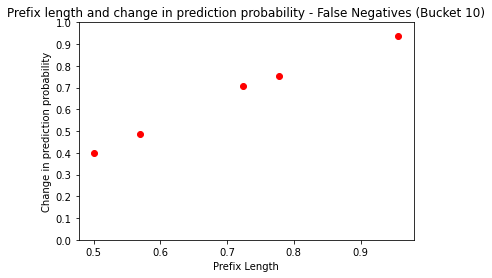

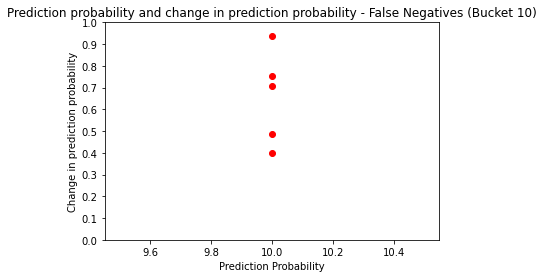

Category 4 of 4. Instance 1 of 5
Creating explanations
[('index__hour_1', 0.38652492, 0.38652492), ('index__Qty_Completed_9', -0.34916377, 0.34916377), ('index__Report_Type_5_S', 0.25021592, 0.25021592), ('index__Qty_Completed_2', 0.22233596, 0.22233596), ('index__Resource_5_ID0997', 0.21092995, 0.21092995), ('index__hour_5', -0.20575146, 0.20575146), ('index__activity_duration_1', -0.19066405, 0.19066405), ('index__Report_Type_5_D', 0.18781029, 0.18781029), ('index__weekday_8', -0.18729913, 0.18729913), ('index__timesincemidnight_8', -0.18457505, 0.18457505), ('index__month_6', -0.16522548, 0.16522548), ('static__Work_Order_Qty', -0.1593188, 0.1593188), ('index__hour_2', -0.15343468, 0.15343468), ('index__activity_duration_4', 0.14612527, 0.14612527), ('index__Qty_Completed_6', 0.13049346, 0.13049346), ('index__activity_duration_2', -0.12608594, 0.12608594), ('index__timesincecasestart_6', -0.125485, 0.125485), ('index__hour_3', -0.124826774, 0.124826774), ('index__month_0', 0.1221728

Creating explanations
[('index__hour_1', -0.33731437, 0.33731437), ('index__timesincemidnight_3', 0.2734865, 0.2734865), ('index__Report_Type_5_S', 0.23895417, 0.23895417), ('index__hour_5', 0.22897239, 0.22897239), ('index__timesincelastevent_3', -0.2014021, 0.2014021), ('index__Report_Type_5_D', 0.19098175, 0.19098175), ('index__Activity_8_Turning & Milling - Machine 5', 0.18247615, 0.18247615), ('index__weekday_8', -0.1820415, 0.1820415), ('index__Report_Type_3_D', 0.18179666, 0.18179666), ('index__timesincecasestart_2', 0.18039986, 0.18039986), ('index__Qty_Completed_6', 0.17418545, 0.17418545), ('index__Report_Type_3_S', 0.17380497, 0.17380497), ('index__timesincelastevent_4', 0.17076305, 0.17076305), ('index__month_6', -0.16522548, 0.16522548), ('index__Activity_4_Turning & Milling Q.C.', 0.16040877, 0.16040877), ('index__Qty_Completed_9', -0.15463604, 0.15463604), ('static__Work_Order_Qty', -0.15253165, 0.15253165), ('index__timesincelastevent_7', 0.15106225, 0.15106225), ('inde

Creating explanations
[('index__timesincemidnight_3', 0.41707864, 0.41707864), ('index__activity_duration_7', 0.3815742, 0.3815742), ('static__Work_Order_Qty', 0.27874067, 0.27874067), ('index__hour_1', -0.26914352, 0.26914352), ('index__activity_duration_1', 0.26912594, 0.26912594), ('index__weekday_8', 0.23445717, 0.23445717), ('index__Qty_Completed_2', 0.23045516, 0.23045516), ('index__Activity_8_Turning & Milling - Machine 5', 0.22255826, 0.22255826), ('index__timesincelastevent_7', 0.21566655, 0.21566655), ('index__hour_5', 0.19070244, 0.19070244), ('index__month_6', -0.17224403, 0.17224403), ('index__timesincelastevent_4', 0.16418521, 0.16418521), ('index__timesincelastevent_1', -0.15822954, 0.15822954), ('index__hour_7', 0.1468531, 0.1468531), ('index__timesincecasestart_6', 0.1440984, 0.1440984), ('index__activity_duration_8', 0.13472, 0.13472), ('index__open_cases_1', 0.13201194, 0.13201194), ('index__Qty_Completed_6', 0.12908335, 0.12908335), ('index__weekday_9', -0.12861565,

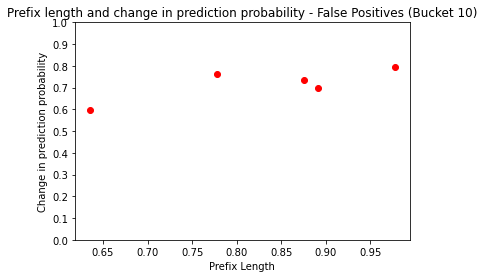

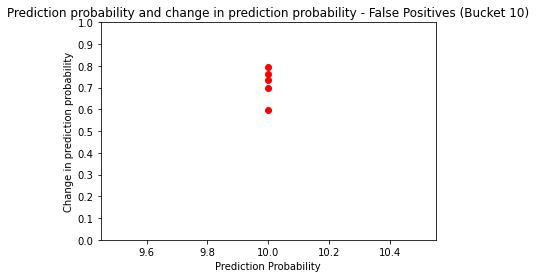

Bucket 11
Generating distributions for bucket
1 of 714 features
2 of 714 features
3 of 714 features
4 of 714 features
5 of 714 features
6 of 714 features
7 of 714 features
8 of 714 features
9 of 714 features
10 of 714 features
11 of 714 features
12 of 714 features
13 of 714 features
14 of 714 features
15 of 714 features
16 of 714 features
17 of 714 features
18 of 714 features
19 of 714 features
20 of 714 features
21 of 714 features
22 of 714 features
23 of 714 features
24 of 714 features
25 of 714 features
26 of 714 features
27 of 714 features
28 of 714 features
29 of 714 features
30 of 714 features
31 of 714 features
32 of 714 features
33 of 714 features
34 of 714 features
35 of 714 features
36 of 714 features
37 of 714 features
38 of 714 features
39 of 714 features
40 of 714 features
41 of 714 features
42 of 714 features
43 of 714 features
44 of 714 features
45 of 714 features
46 of 714 features
47 of 714 features
48 of 714 features
49 of 714 features
50 of 714 features
51 of 714 fea

479 of 714 features
480 of 714 features
481 of 714 features
482 of 714 features
483 of 714 features
484 of 714 features
485 of 714 features
486 of 714 features
487 of 714 features
488 of 714 features
489 of 714 features
490 of 714 features
491 of 714 features
492 of 714 features
493 of 714 features
494 of 714 features
495 of 714 features
496 of 714 features
497 of 714 features
498 of 714 features
499 of 714 features
500 of 714 features
501 of 714 features
502 of 714 features
503 of 714 features
504 of 714 features
505 of 714 features
506 of 714 features
507 of 714 features
508 of 714 features
509 of 714 features
510 of 714 features
511 of 714 features
512 of 714 features
513 of 714 features
514 of 714 features
515 of 714 features
516 of 714 features
517 of 714 features
518 of 714 features
519 of 714 features
520 of 714 features
521 of 714 features
522 of 714 features
523 of 714 features
524 of 714 features
525 of 714 features
526 of 714 features
527 of 714 features
528 of 714 features


Creating explanations
[('index__month_0', 0.30159774, 0.30159774), ('index__hour_3', 0.22844335, 0.22844335), ('index__timesincelastevent_4', -0.22495961, 0.22495961), ('index__weekday_2', -0.21959087, 0.21959087), ('index__timesincelastevent_10', -0.21387213, 0.21387213), ('index__Qty_Completed_8', 0.20493324, 0.20493324), ('index__Qty_Completed_6', -0.18836045, 0.18836045), ('index__timesincecasestart_2', -0.18289545, 0.18289545), ('index__open_cases_1', -0.16945311, 0.16945311), ('index__weekday_9', -0.15662593, 0.15662593), ('index__open_cases_5', -0.14708266, 0.14708266), ('index__activity_duration_7', 0.13794203, 0.13794203), ('index__timesincemidnight_3', 0.13076888, 0.13076888), ('static__Work_Order_Qty', -0.115119405, 0.115119405), ('index__activity_duration_2', 0.114277825, 0.114277825), ('index__Qty_Completed_5', -0.11349541, 0.11349541), ('index__timesincemidnight_6', -0.110809386, 0.110809386), ('index__hour_4', -0.11047114, 0.11047114), ('index__timesincecasestart_4', 0.1

Creating explanations
[('index__timesincemidnight_10', -0.36241683, 0.36241683), ('index__Qty_Completed_5', 0.3458404, 0.3458404), ('index__weekday_2', -0.2540029, 0.2540029), ('index__month_0', 0.2389088, 0.2389088), ('index__timesincelastevent_1', -0.2310706, 0.2310706), ('index__timesincemidnight_3', 0.22826925, 0.22826925), ('index__timesincelastevent_4', 0.21704845, 0.21704845), ('index__timesincelastevent_3', -0.1919796, 0.1919796), ('index__hour_3', 0.19194385, 0.19194385), ('index__timesincecasestart_9', 0.17788869, 0.17788869), ('index__timesincecasestart_6', 0.1743867, 0.1743867), ('static__Work_Order_Qty', -0.17036405, 0.17036405), ('index__Qty_Completed_1', -0.16676106, 0.16676106), ('index__open_cases_5', -0.16558263, 0.16558263), ('index__open_cases_1', -0.16415726, 0.16415726), ('index__Qty_Completed_8', 0.1632903, 0.1632903), ('index__Qty_Completed_3', -0.15270178, 0.15270178), ('index__hour_1', -0.15211435, 0.15211435), ('index__Qty_Completed_9', -0.14429827, 0.1442982

Creating explanations
[('index__timesincemidnight_10', -0.3186977, 0.3186977), ('index__month_0', 0.30601344, 0.30601344), ('index__hour_2', -0.29886657, 0.29886657), ('index__timesincecasestart_7', -0.2853343, 0.2853343), ('index__timesincelastevent_4', -0.27210894, 0.27210894), ('index__weekday_2', -0.24438071, 0.24438071), ('index__weekday_3', -0.23041272, 0.23041272), ('index__timesincelastevent_8', 0.22683512, 0.22683512), ('index__hour_1', 0.2219867, 0.2219867), ('index__Qty_Completed_6', -0.21354808, 0.21354808), ('index__Qty_Completed_1', 0.21088272, 0.21088272), ('index__timesincelastevent_10', -0.20429859, 0.20429859), ('index__activity_duration_5', -0.19716296, 0.19716296), ('index__activity_duration_0', 0.16488512, 0.16488512), ('index__open_cases_5', -0.16368464, 0.16368464), ('index__timesincelastevent_3', -0.15888281, 0.15888281), ('index__hour_3', -0.15536559, 0.15536559), ('index__weekday_6', 0.1553637, 0.1553637), ('static__Work_Order_Qty', -0.15321521, 0.15321521), (

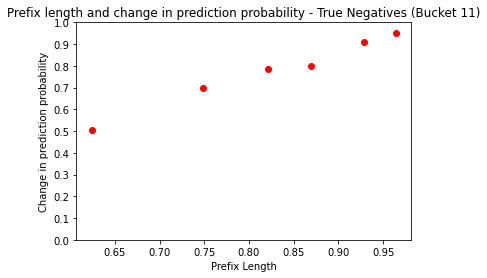

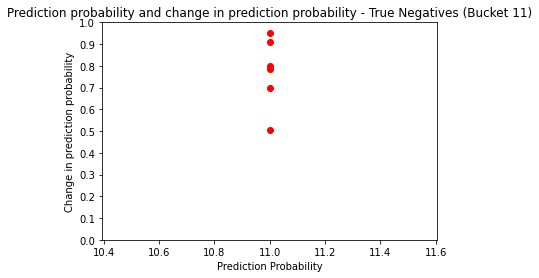

Category 2 of 4. Instance 1 of 7
Creating explanations
[('static__Work_Order_Qty', 0.37506166, 0.37506166), ('index__Qty_Completed_1', 0.2612496, 0.2612496), ('index__timesincelastevent_4', -0.24669173, 0.24669173), ('index__month_0', 0.24114046, 0.24114046), ('index__Qty_Completed_5', 0.2327624, 0.2327624), ('index__timesincemidnight_7', 0.22513531, 0.22513531), ('index__weekday_2', -0.21775624, 0.21775624), ('index__Qty_Completed_8', 0.1932657, 0.1932657), ('index__Activity_5_Turning & Milling Q.C.', -0.1891074, 0.1891074), ('index__hour_3', 0.18667525, 0.18667525), ('index__hour_1', 0.1773281, 0.1773281), ('index__timesincelastevent_8', 0.17454205, 0.17454205), ('index__open_cases_0', 0.14503433, 0.14503433), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0.14087734, 0.14087734), ('index__timesincecasestart_2', -0.13871518, 0.13871518), ('index__activity_duration_7', -0.13455658, 0.13455658), ('index__activity_duration_4', 0.12755738, 0.12755738), ('index__weekday_6', -0.125

Creating explanations
[('static__Work_Order_Qty', 0.39155975, 0.39155975), ('index__hour_2', -0.31345257, 0.31345257), ('index__month_0', 0.28124386, 0.28124386), ('index__hour_5', 0.2720233, 0.2720233), ('index__hour_3', 0.24688657, 0.24688657), ('index__timesincemidnight_3', 0.22367467, 0.22367467), ('index__timesincecasestart_6', 0.20566718, 0.20566718), ('index__Qty_Completed_1', -0.19342774, 0.19342774), ('index__Qty_Completed_7', 0.18877798, 0.18877798), ('index__weekday_6', 0.17784467, 0.17784467), ('index__open_cases_5', -0.16654173, 0.16654173), ('index__Qty_Completed_6', -0.16261834, 0.16261834), ('index__hour_8', -0.1546071, 0.1546071), ('index__timesincecasestart_7', 0.15419386, 0.15419386), ('index__timesincemidnight_5', 0.14369625, 0.14369625), ('index__open_cases_3', -0.14180703, 0.14180703), ('index__Report_Type_3_D', 0.13408013, 0.13408013), ('index__weekday_9', -0.1328503, 0.1328503), ('index__weekday_10', 0.12581375, 0.12581375), ('index__Qty_Completed_9', -0.1202377

Creating explanations
[('index__timesincelastevent_4', -0.27049863, 0.27049863), ('index__hour_8', 0.24658926, 0.24658926), ('index__weekday_2', 0.24610397, 0.24610397), ('index__timesincemidnight_7', 0.23755403, 0.23755403), ('index__hour_2', 0.2308995, 0.2308995), ('index__timesincelastevent_10', 0.22531077, 0.22531077), ('index__month_0', 0.1928424, 0.1928424), ('index__open_cases_5', -0.19131188, 0.19131188), ('index__hour_3', 0.18043691, 0.18043691), ('index__timesincecasestart_9', 0.1723667, 0.1723667), ('index__activity_duration_7', 0.17147991, 0.17147991), ('index__timesincecasestart_7', 0.16569188, 0.16569188), ('index__Activity_10_Turning & Milling Q.C.', 0.1602364, 0.1602364), ('index__Qty_Completed_1', 0.16015063, 0.16015063), ('index__weekday_3', -0.15983707, 0.15983707), ('index__weekday_6', -0.15782079, 0.15782079), ('index__timesincecasestart_6', 0.14778803, 0.14778803), ('index__open_cases_3', -0.13386145, 0.13386145), ('index__Qty_Completed_7', 0.13211906, 0.13211906)

Creating explanations
[('static__Work_Order_Qty', 0.36844432, 0.36844432), ('index__timesincemidnight_10', -0.3570298, 0.3570298), ('index__hour_8', 0.3543807, 0.3543807), ('index__timesincelastevent_10', 0.3328519, 0.3328519), ('index__Qty_Completed_5', 0.29119632, 0.29119632), ('index__timesincelastevent_4', -0.2863265, 0.2863265), ('index__weekday_2', -0.24407487, 0.24407487), ('index__month_0', 0.2353016, 0.2353016), ('index__timesincemidnight_1', -0.233917, 0.233917), ('index__Qty_Completed_8', 0.23087238, 0.23087238), ('index__timesincecasestart_6', 0.23000742, 0.23000742), ('index__activity_duration_8', 0.22805312, 0.22805312), ('index__hour_3', 0.21833047, 0.21833047), ('index__activity_duration_5', -0.2031552, 0.2031552), ('index__hour_1', -0.20171136, 0.20171136), ('index__Qty_Completed_1', 0.1851515, 0.1851515), ('index__timesincecasestart_9', 0.16961315, 0.16961315), ('index__open_cases_0', 0.1688963, 0.1688963), ('index__timesincecasestart_7', 0.16384466, 0.16384466), ('in

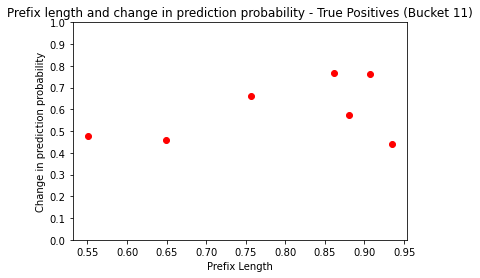

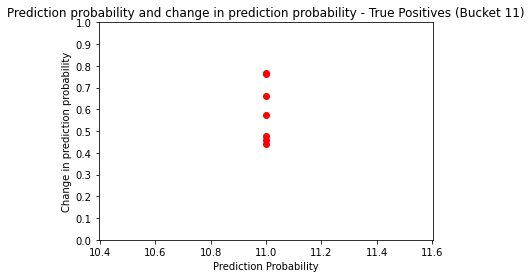

Category 3 of 4. Instance 1 of 5
Creating explanations
[('index__hour_8', 0.3944648, 0.3944648), ('index__timesincemidnight_7', 0.3579803, 0.3579803), ('index__timesincelastevent_4', -0.26745063, 0.26745063), ('index__timesincelastevent_10', 0.25872198, 0.25872198), ('index__weekday_2', -0.21567287, 0.21567287), ('index__month_0', 0.20942138, 0.20942138), ('index__hour_2', -0.19983083, 0.19983083), ('index__open_cases_5', -0.1912698, 0.1912698), ('index__hour_1', -0.17729187, 0.17729187), ('index__Resource_8_ID3846', -0.17239535, 0.17239535), ('index__Qty_Completed_6', -0.16492689, 0.16492689), ('index__Resource_9_ID4641', 0.16107696, 0.16107696), ('index__hour_4', -0.15482181, 0.15482181), ('index__Report_Type_9_S', 0.15409707, 0.15409707), ('index__hour_6', 0.14647834, 0.14647834), ('index__Resource.1_1_Machine 9 - Turning & Milling', -0.14190823, 0.14190823), ('index__timesincemidnight_1', -0.14108917, 0.14108917), ('index__open_cases_1', 0.14035949, 0.14035949), ('index__Report_Typ

Creating explanations
[('index__timesincemidnight_7', 0.33729222, 0.33729222), ('index__timesincelastevent_4', -0.30471915, 0.30471915), ('index__Qty_Completed_5', 0.2990541, 0.2990541), ('static__Part_Desc__Spur Gear', -0.29318884, 0.29318884), ('index__weekday_2', -0.24810265, 0.24810265), ('index__month_0', 0.23284493, 0.23284493), ('index__hour_1', 0.22769699, 0.22769699), ('index__timesincecasestart_6', 0.21157812, 0.21157812), ('index__hour_8', -0.20948727, 0.20948727), ('index__hour_4', 0.19193025, 0.19193025), ('index__hour_6', 0.18909845, 0.18909845), ('index__Activity_10_Turning & Milling Q.C.', 0.18211403, 0.18211403), ('index__timesincecasestart_9', 0.1747635, 0.1747635), ('index__weekday_3', -0.16018933, 0.16018933), ('index__Report_Type_9_S', 0.15409707, 0.15409707), ('index__timesincecasestart_7', 0.15380728, 0.15380728), ('index__timesincemidnight_4', 0.15336215, 0.15336215), ('index__Qty_Completed_1', -0.15025932, 0.15025932), ('index__hour_2', -0.14505883, 0.14505883)

Creating explanations
[('index__Activity_5_Turning & Milling Q.C.', -0.26818255, 0.26818255), ('index__timesincemidnight_10', 0.25907096, 0.25907096), ('index__weekday_2', -0.2534156, 0.2534156), ('index__hour_8', 0.24782017, 0.24782017), ('index__Qty_Completed_5', -0.22709882, 0.22709882), ('index__timesincelastevent_10', -0.2197648, 0.2197648), ('index__open_cases_5', -0.19007903, 0.19007903), ('index__Qty_Completed_1', 0.18287249, 0.18287249), ('index__month_0', 0.18269412, 0.18269412), ('index__open_cases_1', -0.17455818, 0.17455818), ('index__Activity_10_Turning & Milling Q.C.', 0.17399338, 0.17399338), ('index__timesincelastevent_3', -0.17337693, 0.17337693), ('index__timesincelastevent_1', 0.16487843, 0.16487843), ('index__hour_4', -0.16273136, 0.16273136), ('index__weekday_3', -0.15983431, 0.15983431), ('index__Activity_3_Turning & Milling - Machine 4', 0.15921879, 0.15921879), ('index__weekday_6', -0.15765633, 0.15765633), ('index__timesincecasestart_6', 0.15755244, 0.15755244

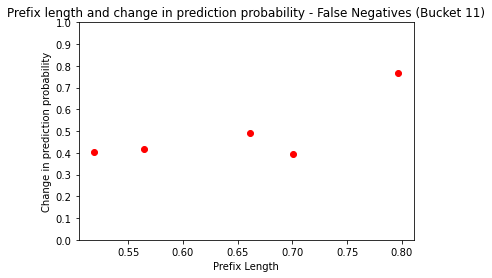

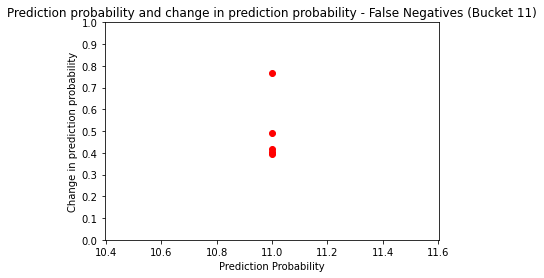

Category 4 of 4. Instance 1 of 4
Creating explanations
[('index__hour_8', 0.279252, 0.279252), ('index__Qty_Completed_5', 0.27525434, 0.27525434), ('index__timesincelastevent_10', 0.27030915, 0.27030915), ('index__timesincelastevent_3', -0.25965795, 0.25965795), ('index__weekday_2', -0.24565563, 0.24565563), ('index__open_cases_1', -0.23618701, 0.23618701), ('index__weekday_3', -0.23421215, 0.23421215), ('index__timesincemidnight_1', -0.21903093, 0.21903093), ('index__timesincelastevent_4', 0.21594031, 0.21594031), ('index__timesincemidnight_3', 0.21480344, 0.21480344), ('index__Resource_6_ID4529', 0.19939348, 0.19939348), ('index__hour_3', 0.1983592, 0.1983592), ('index__timesincecasestart_2', 0.19762129, 0.19762129), ('index__hour_1', -0.19001454, 0.19001454), ('index__weekday_6', -0.18171403, 0.18171403), ('index__month_0', 0.17418867, 0.17418867), ('index__timesincecasestart_6', 0.16179748, 0.16179748), ('index__timesincecasestart_9', 0.15835668, 0.15835668), ('static__Work_Order_Q

Creating explanations
[('static__Work_Order_Qty', 0.38857812, 0.38857812), ('index__Qty_Completed_5', 0.34638435, 0.34638435), ('index__hour_8', 0.34303477, 0.34303477), ('index__month_0', 0.28124386, 0.28124386), ('index__weekday_9', 0.26641443, 0.26641443), ('index__Qty_Completed_8', 0.23990455, 0.23990455), ('index__Qty_Completed_1', 0.22011782, 0.22011782), ('index__timesincelastevent_10', -0.2080038, 0.2080038), ('index__timesincelastevent_1', 0.17999598, 0.17999598), ('index__activity_duration_9', -0.17940961, 0.17940961), ('index__hour_1', -0.17813629, 0.17813629), ('index__open_cases_5', -0.1655438, 0.1655438), ('index__open_cases_0', 0.16517514, 0.16517514), ('index__timesincemidnight_1', -0.16377725, 0.16377725), ('index__open_cases_1', 0.15604661, 0.15604661), ('index__activity_duration_2', -0.15398583, 0.15398583), ('index__weekday_8', -0.15323877, 0.15323877), ('index__timesincemidnight_3', -0.14922877, 0.14922877), ('index__Resource.1_8_Machine 6 - Turning & Milling', 0.1

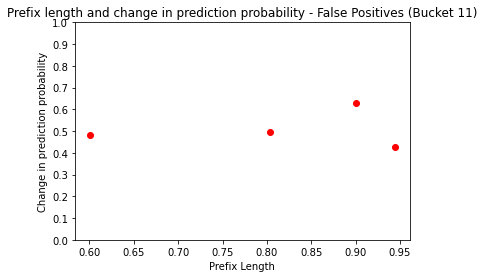

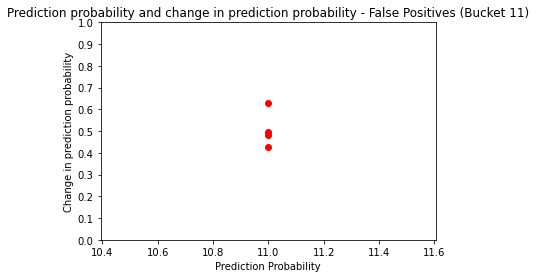

Bucket 12
Generating distributions for bucket
1 of 751 features
2 of 751 features
3 of 751 features
4 of 751 features
5 of 751 features
6 of 751 features
7 of 751 features
8 of 751 features
9 of 751 features
10 of 751 features
11 of 751 features
12 of 751 features
13 of 751 features
14 of 751 features
15 of 751 features
16 of 751 features
17 of 751 features
18 of 751 features
19 of 751 features
20 of 751 features
21 of 751 features
22 of 751 features
23 of 751 features
24 of 751 features
25 of 751 features
26 of 751 features
27 of 751 features
28 of 751 features
29 of 751 features
30 of 751 features
31 of 751 features
32 of 751 features
33 of 751 features
34 of 751 features
35 of 751 features
36 of 751 features
37 of 751 features
38 of 751 features
39 of 751 features
40 of 751 features
41 of 751 features
42 of 751 features
43 of 751 features
44 of 751 features
45 of 751 features
46 of 751 features
47 of 751 features
48 of 751 features
49 of 751 features
50 of 751 features
51 of 751 fea

414 of 751 features
415 of 751 features
416 of 751 features
417 of 751 features
418 of 751 features
419 of 751 features
420 of 751 features
421 of 751 features
422 of 751 features
423 of 751 features
424 of 751 features
425 of 751 features
426 of 751 features
427 of 751 features
428 of 751 features
429 of 751 features
430 of 751 features
431 of 751 features
432 of 751 features
433 of 751 features
434 of 751 features
435 of 751 features
436 of 751 features
437 of 751 features
438 of 751 features
439 of 751 features
440 of 751 features
441 of 751 features
442 of 751 features
443 of 751 features
444 of 751 features
445 of 751 features
446 of 751 features
447 of 751 features
448 of 751 features
449 of 751 features
450 of 751 features
451 of 751 features
452 of 751 features
453 of 751 features
454 of 751 features
455 of 751 features
456 of 751 features
457 of 751 features
458 of 751 features
459 of 751 features
460 of 751 features
461 of 751 features
462 of 751 features
463 of 751 features


Creating explanations
[('index__timesincelastevent_5', 0.2996394, 0.2996394), ('index__open_cases_8', -0.21936245, 0.21936245), ('index__timesincemidnight_8', 0.2158209, 0.2158209), ('index__hour_7', 0.20735472, 0.20735472), ('index__timesincemidnight_11', -0.20534751, 0.20534751), ('index__hour_4', -0.20290022, 0.20290022), ('index__timesincemidnight_6', -0.20215033, 0.20215033), ('index__timesincecasestart_1', 0.20014453, 0.20014453), ('index__timesincemidnight_1', -0.1993631, 0.1993631), ('index__hour_6', -0.19513617, 0.19513617), ('index__timesincemidnight_7', -0.1938374, 0.1938374), ('index__Report_Type_5_S', 0.17257209, 0.17257209), ('index__Activity_2_Turning & Milling - Machine 4', 0.1690112, 0.1690112), ('index__open_cases_1', -0.1566233, 0.1566233), ('index__month_11', -0.15315776, 0.15315776), ('index__Resource.1_1_Machine 5 - Turning & Milling', 0.14441168, 0.14441168), ('index__hour_8', 0.13633859, 0.13633859), ('index__timesincecasestart_10', 0.13543616, 0.13543616), ('st

Creating explanations
[('index__timesincemidnight_7', -0.27894935, 0.27894935), ('index__Qty_Completed_8', 0.26029107, 0.26029107), ('index__timesincemidnight_6', -0.22035258, 0.22035258), ('index__activity_duration_0', 0.21755159, 0.21755159), ('index__hour_4', -0.2047275, 0.2047275), ('index__hour_6', -0.20334126, 0.20334126), ('index__open_cases_1', -0.19935443, 0.19935443), ('index__hour_7', 0.1704932, 0.1704932), ('index__hour_0', 0.17022318, 0.17022318), ('index__timesincecasestart_3', -0.16904128, 0.16904128), ('index__open_cases_8', -0.16702843, 0.16702843), ('index__month_11', -0.15232615, 0.15232615), ('index__timesincelastevent_8', 0.15027437, 0.15027437), ('index__Resource.1_1_Machine 5 - Turning & Milling', 0.14441168, 0.14441168), ('index__activity_duration_4', -0.14416237, 0.14416237), ('index__month_5', -0.13372447, 0.13372447), ('index__timesincecasestart_9', -0.1319642, 0.1319642), ('index__timesincemidnight_9', 0.12842242, 0.12842242), ('index__weekday_5', 0.12537788

Creating explanations
[('index__activity_duration_0', 0.25219244, 0.25219244), ('index__Resource_4_ID4882', -0.21313441, 0.21313441), ('index__Activity_1_Laser Marking - Machine 7', 0.19231024, 0.19231024), ('index__timesincemidnight_6', -0.18979669, 0.18979669), ('index__timesincemidnight_10', 0.18764168, 0.18764168), ('index__timesincecasestart_1', -0.18730545, 0.18730545), ('index__open_cases_1', -0.16803758, 0.16803758), ('index__Qty_Completed_8', -0.16202836, 0.16202836), ('index__timesincemidnight_2', 0.1554442, 0.1554442), ('index__month_11', -0.15431198, 0.15431198), ('index__timesincelastevent_10', -0.15201774, 0.15201774), ('index__timesincelastevent_8', 0.14961216, 0.14961216), ('index__hour_10', 0.14152883, 0.14152883), ('index__Resource.1_7_Quality Check 1', 0.13449712, 0.13449712), ('index__timesincecasestart_9', -0.13420993, 0.13420993), ('index__timesincelastevent_2', -0.13211015, 0.13211015), ('index__hour_6', -0.13158807, 0.13158807), ('index__timesincemidnight_9', 0.

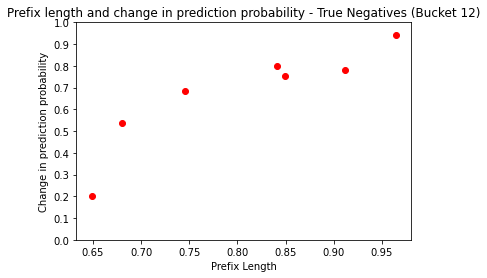

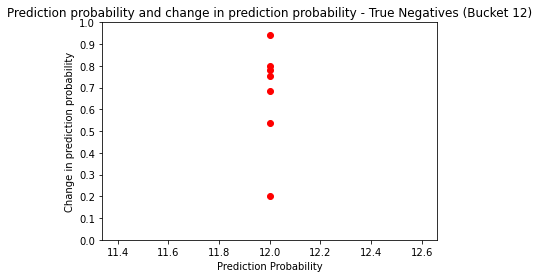

Category 2 of 4. Instance 1 of 6
Creating explanations
[('index__timesincecasestart_1', 0.4150567, 0.4150567), ('index__hour_2', 0.28532907, 0.28532907), ('index__timesincelastevent_5', -0.24728711, 0.24728711), ('index__open_cases_8', -0.22050025, 0.22050025), ('index__timesincemidnight_8', 0.20099501, 0.20099501), ('index__open_cases_1', -0.19946924, 0.19946924), ('index__timesincemidnight_10', 0.18690555, 0.18690555), ('index__hour_4', -0.18211946, 0.18211946), ('index__hour_6', -0.18156704, 0.18156704), ('index__hour_8', 0.16855267, 0.16855267), ('index__timesincelastevent_9', -0.16187595, 0.16187595), ('index__timesincemidnight_2', 0.15249492, 0.15249492), ('index__weekday_5', -0.14240466, 0.14240466), ('index__Qty_Completed_3', 0.14123854, 0.14123854), ('index__timesincemidnight_3', 0.13396524, 0.13396524), ('index__timesincelastevent_1', 0.12846653, 0.12846653), ('index__Qty_Completed_8', -0.12429242, 0.12429242), ('index__month_5', -0.11490151, 0.11490151), ('index__hour_10', 0

Creating explanations
[('index__timesincemidnight_10', -0.37340373, 0.37340373), ('index__Qty_Completed_8', 0.2732067, 0.2732067), ('static__Work_Order_Qty', 0.26845485, 0.26845485), ('index__timesincemidnight_6', 0.24122675, 0.24122675), ('index__Resource.1_8_Machine 7- Laser Marking', 0.23319404, 0.23319404), ('index__hour_4', -0.22373195, 0.22373195), ('index__open_cases_8', -0.20798323, 0.20798323), ('index__timesincecasestart_1', 0.18123868, 0.18123868), ('index__activity_duration_4', 0.17767577, 0.17767577), ('index__timesincemidnight_8', -0.16659123, 0.16659123), ('index__timesincelastevent_8', 0.14961216, 0.14961216), ('index__timesincecasestart_3', 0.14792535, 0.14792535), ('index__timesincemidnight_11', 0.1422811, 0.1422811), ('index__timesincelastevent_7', -0.14186364, 0.14186364), ('index__Activity_2_Turning & Milling - Machine 9', 0.13966663, 0.13966663), ('index__timesincecasestart_9', -0.1364974, 0.1364974), ('index__hour_6', 0.13536449, 0.13536449), ('index__hour_1', 0.

Creating explanations
[('index__timesincemidnight_10', -0.34154832, 0.34154832), ('index__timesincemidnight_3', 0.31045684, 0.31045684), ('index__timesincemidnight_7', -0.29730493, 0.29730493), ('index__Qty_Completed_8', 0.2719676, 0.2719676), ('static__Work_Order_Qty', 0.2548052, 0.2548052), ('index__hour_4', -0.23136492, 0.23136492), ('index__hour_6', -0.20007664, 0.20007664), ('index__open_cases_8', -0.19447203, 0.19447203), ('index__timesincemidnight_6', -0.19297409, 0.19297409), ('index__timesincemidnight_8', 0.18401588, 0.18401588), ('index__hour_8', 0.18171379, 0.18171379), ('index__Activity_8_Turning & Milling - Machine 4', 0.1789324, 0.1789324), ('index__activity_duration_4', 0.17495249, 0.17495249), ('index__open_cases_1', -0.17329066, 0.17329066), ('index__timesincelastevent_9', -0.1558006, 0.1558006), ('index__month_11', -0.15301609, 0.15301609), ('index__timesincelastevent_7', -0.14173709, 0.14173709), ('index__timesincecasestart_9', -0.13426454, 0.13426454), ('index__time

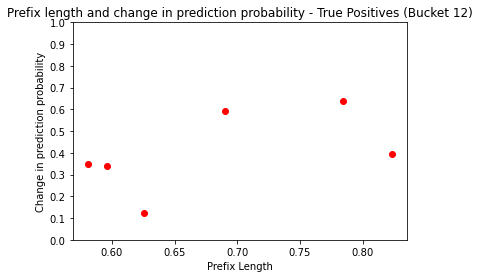

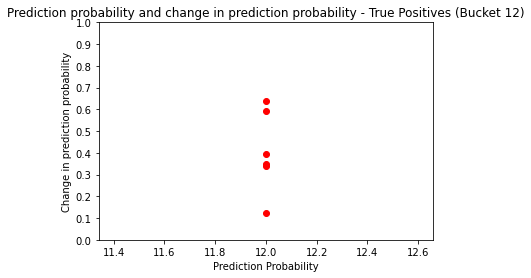

Category 3 of 4. Instance 1 of 6
Creating explanations
[('index__timesincemidnight_8', 0.32598972, 0.32598972), ('index__timesincemidnight_6', 0.2589805, 0.2589805), ('index__hour_4', -0.19831277, 0.19831277), ('index__timesincecasestart_1', 0.18797727, 0.18797727), ('index__hour_10', -0.17942688, 0.17942688), ('index__timesincemidnight_10', -0.16379987, 0.16379987), ('index__timesincemidnight_9', -0.16183269, 0.16183269), ('index__hour_2', -0.16088209, 0.16088209), ('index__hour_8', 0.15445136, 0.15445136), ('index__month_5', -0.14829752, 0.14829752), ('index__activity_duration_4', -0.14307944, 0.14307944), ('index__timesincelastevent_9', 0.1409039, 0.1409039), ('index__open_cases_5', -0.14089726, 0.14089726), ('index__Activity_2_Turning & Milling - Machine 9', 0.13966663, 0.13966663), ('index__hour_6', 0.13750017, 0.13750017), ('static__Work_Order_Qty', -0.13418631, 0.13418631), ('index__timesincelastevent_7', -0.13377623, 0.13377623), ('index__hour_0', -0.13295858, 0.13295858), ('in

Creating explanations
[('index__timesincemidnight_7', -0.27563325, 0.27563325), ('index__timesincelastevent_5', -0.27450907, 0.27450907), ('index__hour_2', 0.24364546, 0.24364546), ('index__hour_4', -0.23138992, 0.23138992), ('index__timesincemidnight_10', 0.20436151, 0.20436151), ('index__Qty_Completed_3', 0.1982083, 0.1982083), ('static__Work_Order_Qty', 0.19701092, 0.19701092), ('index__open_cases_1', -0.18587379, 0.18587379), ('index__timesincelastevent_7', -0.17803136, 0.17803136), ('index__hour_6', -0.17721823, 0.17721823), ('index__timesincemidnight_8', 0.15910299, 0.15910299), ('index__Activity_5_Turning & Milling - Machine 6', 0.15718333, 0.15718333), ('index__open_cases_8', -0.15460885, 0.15460885), ('index__timesincemidnight_2', 0.14896794, 0.14896794), ('index__hour_8', 0.1470676, 0.1470676), ('index__weekday_5', -0.14489253, 0.14489253), ('index__month_5', -0.13974544, 0.13974544), ('index__timesincemidnight_6', -0.13738519, 0.13738519), ('index__Resource_11_ID4794', 0.136

Creating explanations
[('index__timesincemidnight_7', -0.3492577, 0.3492577), ('index__timesincemidnight_8', 0.25962391, 0.25962391), ('index__timesincecasestart_1', -0.23828271, 0.23828271), ('index__hour_2', 0.21155483, 0.21155483), ('index__timesincelastevent_2', -0.20072049, 0.20072049), ('index__timesincemidnight_6', -0.19974591, 0.19974591), ('index__hour_8', 0.19752964, 0.19752964), ('index__hour_6', -0.1923262, 0.1923262), ('index__timesincecasestart_3', -0.19212525, 0.19212525), ('index__timesincelastevent_7', -0.18333101, 0.18333101), ('index__timesincemidnight_1', -0.17798568, 0.17798568), ('index__timesincemidnight_10', -0.17269222, 0.17269222), ('index__Qty_Completed_8', 0.17148425, 0.17148425), ('index__hour_1', -0.16850711, 0.16850711), ('index__hour_0', -0.16698106, 0.16698106), ('index__hour_5', 0.1617814, 0.1617814), ('index__hour_10', -0.15598089, 0.15598089), ('index__timesincelastevent_5', -0.15550244, 0.15550244), ('index__month_11', -0.1497485, 0.1497485), ('inde

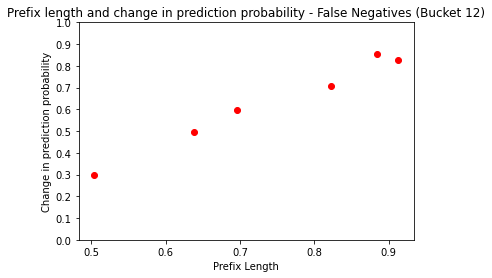

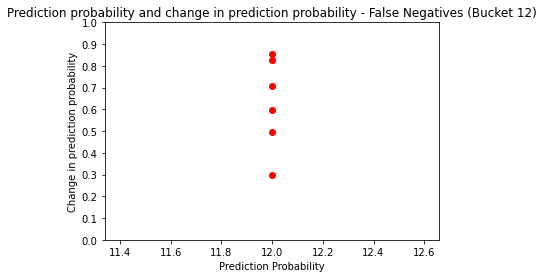

Category 4 of 4. Instance 1 of 1
Creating explanations
[('index__hour_4', -0.2885382, 0.2885382), ('index__Qty_Completed_8', 0.26516446, 0.26516446), ('index__timesincemidnight_8', 0.24347778, 0.24347778), ('index__timesincemidnight_10', -0.21306448, 0.21306448), ('index__weekday_6', -0.20775983, 0.20775983), ('index__hour_8', 0.19879374, 0.19879374), ('index__weekday_2', 0.19473627, 0.19473627), ('index__timesincelastevent_4', 0.19116713, 0.19116713), ('index__timesincecasestart_1', 0.18868387, 0.18868387), ('index__timesincemidnight_2', -0.18265262, 0.18265262), ('index__timesincelastevent_7', -0.17460719, 0.17460719), ('index__timesincemidnight_1', -0.17088005, 0.17088005), ('index__hour_1', -0.17011236, 0.17011236), ('index__timesincelastevent_9', -0.16197555, 0.16197555), ('index__hour_6', 0.16166648, 0.16166648), ('static__Work_Order_Qty', 0.15897425, 0.15897425), ('index__Resource_8_ID4794', 0.15111691, 0.15111691), ('index__weekday_10', -0.14654258, 0.14654258), ('index__activi

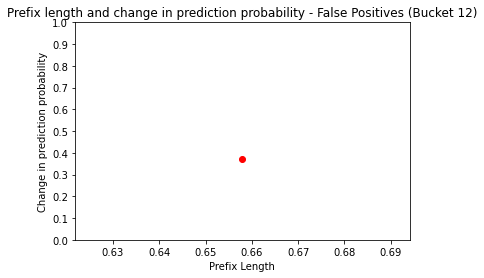

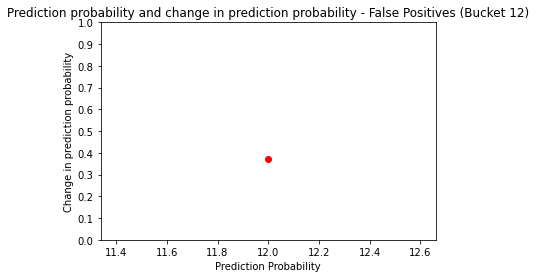

Bucket 13
Generating distributions for bucket
1 of 810 features
2 of 810 features
3 of 810 features
4 of 810 features
5 of 810 features
6 of 810 features
7 of 810 features
8 of 810 features
9 of 810 features
10 of 810 features
11 of 810 features
12 of 810 features
13 of 810 features
14 of 810 features
15 of 810 features
16 of 810 features
17 of 810 features
18 of 810 features
19 of 810 features
20 of 810 features
21 of 810 features
22 of 810 features
23 of 810 features
24 of 810 features
25 of 810 features
26 of 810 features
27 of 810 features
28 of 810 features
29 of 810 features
30 of 810 features
31 of 810 features
32 of 810 features
33 of 810 features
34 of 810 features
35 of 810 features
36 of 810 features
37 of 810 features
38 of 810 features
39 of 810 features
40 of 810 features
41 of 810 features
42 of 810 features
43 of 810 features
44 of 810 features
45 of 810 features
46 of 810 features
47 of 810 features
48 of 810 features
49 of 810 features
50 of 810 features
51 of 810 fea

423 of 810 features
424 of 810 features
425 of 810 features
426 of 810 features
427 of 810 features
428 of 810 features
429 of 810 features
430 of 810 features
431 of 810 features
432 of 810 features
433 of 810 features
434 of 810 features
435 of 810 features
436 of 810 features
437 of 810 features
438 of 810 features
439 of 810 features
440 of 810 features
441 of 810 features
442 of 810 features
443 of 810 features
444 of 810 features
445 of 810 features
446 of 810 features
447 of 810 features
448 of 810 features
449 of 810 features
450 of 810 features
451 of 810 features
452 of 810 features
453 of 810 features
454 of 810 features
455 of 810 features
456 of 810 features
457 of 810 features
458 of 810 features
459 of 810 features
460 of 810 features
461 of 810 features
462 of 810 features
463 of 810 features
464 of 810 features
465 of 810 features
466 of 810 features
467 of 810 features
468 of 810 features
469 of 810 features
470 of 810 features
471 of 810 features
472 of 810 features


Creating explanations
[('index__timesincelastevent_3', -0.43340823, 0.43340823), ('index__timesincecasestart_8', 0.2730208, 0.2730208), ('index__timesincemidnight_3', 0.22944108, 0.22944108), ('index__activity_duration_11', -0.22658794, 0.22658794), ('index__timesincemidnight_7', -0.21183062, 0.21183062), ('index__hour_3', 0.20930552, 0.20930552), ('index__Report_Type_5_D', 0.18587442, 0.18587442), ('index__Activity_12_Lapping - Machine 1', -0.17912674, 0.17912674), ('static__Work_Order_Qty', -0.17247881, 0.17247881), ('index__activity_duration_8', -0.16604264, 0.16604264), ('index__timesincelastevent_8', -0.15840828, 0.15840828), ('index__Resource.1_5_Machine 5 - Turning & Milling', 0.14366484, 0.14366484), ('index__Qty_Completed_11', 0.13553225, 0.13553225), ('index__timesincemidnight_6', -0.13531893, 0.13531893), ('index__open_cases_1', -0.13526265, 0.13526265), ('index__weekday_9', -0.13180444, 0.13180444), ('index__open_cases_4', -0.12604797, 0.12604797), ('index__hour_8', 0.12559

Creating explanations
[('index__activity_duration_11', 0.2597244, 0.2597244), ('index__Resource_2_ID4429', 0.22359352, 0.22359352), ('index__timesincemidnight_3', -0.2046792, 0.2046792), ('static__Work_Order_Qty', -0.19448733, 0.19448733), ('index__activity_duration_1', 0.19228649, 0.19228649), ('index__timesincemidnight_12', -0.18904006, 0.18904006), ('index__open_cases_2', -0.18509516, 0.18509516), ('index__open_cases_5', -0.18371502, 0.18371502), ('index__hour_3', -0.15802723, 0.15802723), ('index__weekday_9', -0.15350965, 0.15350965), ('index__Resource_11_ID4445', 0.14078745, 0.14078745), ('index__open_cases_1', -0.12442953, 0.12442953), ('index__timesincemidnight_8', -0.11684979, 0.11684979), ('index__activity_duration_7', -0.11631985, 0.11631985), ('index__activity_duration_5', -0.11456646, 0.11456646), ('index__weekday_8', -0.114182845, 0.114182845), ('index__activity_duration_8', 0.11391167, 0.11391167), ('index__timesincemidnight_7', 0.11168699, 0.11168699), ('index__Report_Ty

Creating explanations
[('index__timesincelastevent_3', -0.41094336, 0.41094336), ('index__hour_1', 0.33695832, 0.33695832), ('index__timesincelastevent_8', 0.22682363, 0.22682363), ('index__Resource.1_0_Machine 8 - Turning & Milling', -0.22389841, 0.22389841), ('index__activity_duration_4', -0.21234971, 0.21234971), ('static__Work_Order_Qty', -0.1771963, 0.1771963), ('index__Report_Type_8_S', -0.15119049, 0.15119049), ('index__hour_0', -0.15104377, 0.15104377), ('index__Qty_Completed_11', 0.1505953, 0.1505953), ('index__Resource_7_ID4882', 0.13870841, 0.13870841), ('index__Resource.1_4_Quality Check 1', -0.1366303, 0.1366303), ('index__timesincemidnight_9', -0.13500296, 0.13500296), ('index__open_cases_0', 0.13225457, 0.13225457), ('index__weekday_9', -0.13140117, 0.13140117), ('index__timesincemidnight_1', 0.1269805, 0.1269805), ('index__hour_3', -0.12569542, 0.12569542), ('index__activity_duration_8', 0.11664929, 0.11664929), ('index__timesincemidnight_12', 0.11322631, 0.11322631), (

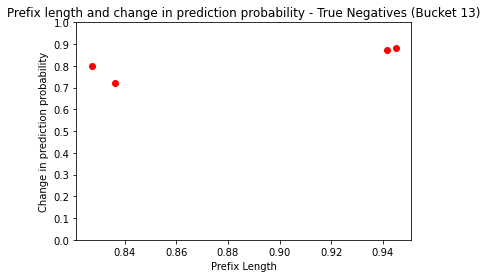

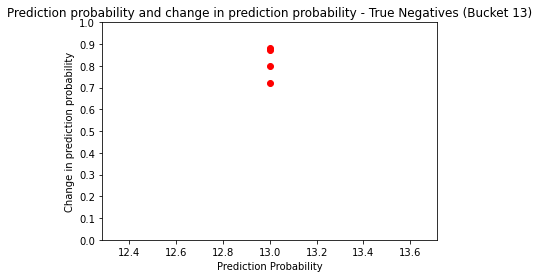

Category 2 of 4. Instance 1 of 2
Creating explanations
[('index__activity_duration_11', 0.3997928, 0.3997928), ('index__hour_1', 0.31479096, 0.31479096), ('index__timesincemidnight_3', -0.21123429, 0.21123429), ('index__timesincelastevent_8', -0.20360886, 0.20360886), ('index__month_9', -0.20303275, 0.20303275), ('index__hour_0', -0.1930666, 0.1930666), ('index__timesincemidnight_12', -0.18904006, 0.18904006), ('index__activity_duration_6', -0.16994573, 0.16994573), ('index__activity_duration_5', 0.16916978, 0.16916978), ('index__timesincemidnight_6', 0.14660993, 0.14660993), ('index__open_cases_4', -0.1360563, 0.1360563), ('index__open_cases_5', -0.13374572, 0.13374572), ('index__timesincemidnight_1', 0.13288431, 0.13288431), ('index__Resource.1_5_Machine 4 - Turning & Milling', 0.13096508, 0.13096508), ('static__Work_Order_Qty', 0.1305789, 0.1305789), ('index__hour_3', -0.12604783, 0.12604783), ('index__activity_duration_1', 0.12477809, 0.12477809), ('index__activity_duration_9', 0.1

Creating explanations
[('index__activity_duration_7', 0.39953318, 0.39953318), ('index__hour_1', 0.29548556, 0.29548556), ('index__activity_duration_4', 0.25173151, 0.25173151), ('index__timesincelastevent_8', 0.24950428, 0.24950428), ('index__hour_0', 0.22817147, 0.22817147), ('index__Activity_2_other', 0.21846402, 0.21846402), ('index__timesincemidnight_7', -0.20680769, 0.20680769), ('index__month_9', -0.19961219, 0.19961219), ('index__activity_duration_12', 0.17762567, 0.17762567), ('index__open_cases_2', -0.17509428, 0.17509428), ('index__Qty_Completed_4', 0.15798609, 0.15798609), ('index__activity_duration_2', -0.15075351, 0.15075351), ('index__timesincemidnight_6', -0.14855485, 0.14855485), ('static__Work_Order_Qty', 0.14546537, 0.14546537), ('index__Qty_Completed_11', -0.14254874, 0.14254874), ('index__open_cases_5', -0.13832812, 0.13832812), ('index__timesincemidnight_1', 0.12640257, 0.12640257), ('index__activity_duration_1', 0.12293113, 0.12293113), ('index__Qty_Completed_1',

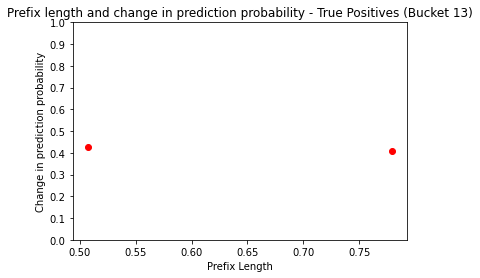

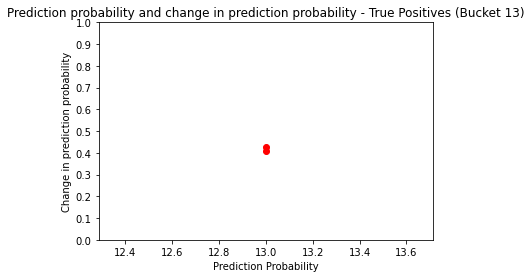

Category 3 of 4. Instance 1 of 5
Creating explanations
[('index__timesincemidnight_3', 0.27830264, 0.27830264), ('index__activity_duration_11', -0.23918933, 0.23918933), ('index__timesincelastevent_8', -0.22723733, 0.22723733), ('index__hour_3', 0.22515763, 0.22515763), ('index__Resource_2_ID4429', 0.21266922, 0.21266922), ('index__weekday_9', 0.21245739, 0.21245739), ('index__timesincelastevent_3', 0.20225048, 0.20225048), ('index__activity_duration_8', -0.19546126, 0.19546126), ('index__open_cases_2', -0.18106571, 0.18106571), ('index__activity_duration_3', -0.17767659, 0.17767659), ('index__hour_0', 0.17415082, 0.17415082), ('index__Resource_4_ID4529', 0.16248147, 0.16248147), ('index__activity_duration_7', -0.15380202, 0.15380202), ('static__Work_Order_Qty', 0.14791265, 0.14791265), ('index__activity_duration_0', -0.14712399, 0.14712399), ('index__open_cases_5', -0.14156023, 0.14156023), ('index__weekday_8', 0.13201524, 0.13201524), ('index__hour_5', 0.12650578, 0.12650578), ('inde

Creating explanations
[('index__weekday_9', 0.27644542, 0.27644542), ('index__activity_duration_11', -0.25098482, 0.25098482), ('index__timesincelastevent_8', -0.22108635, 0.22108635), ('index__timesincemidnight_3', -0.2024692, 0.2024692), ('index__Resource_3_ID3846', 0.18591954, 0.18591954), ('index__timesincemidnight_6', 0.17241761, 0.17241761), ('index__Report_Type_11_D', 0.16616723, 0.16616723), ('index__month_9', -0.16614126, 0.16614126), ('index__hour_3', -0.16253737, 0.16253737), ('index__Activity_7_Turning & Milling - Machine 9', 0.16035432, 0.16035432), ('index__activity_duration_8', -0.15728518, 0.15728518), ('index__Qty_Completed_11', 0.15096723, 0.15096723), ('index__Report_Type_8_S', -0.14564861, 0.14564861), ('index__Report_Type_12_D', 0.13877316, 0.13877316), ('index__open_cases_5', -0.133265, 0.133265), ('index__timesincemidnight_9', -0.1317077, 0.1317077), ('index__Report_Type_3_D', 0.12644272, 0.12644272), ('index__Activity_6_Turning & Milling - Machine 9', 0.12543496

Creating explanations
[('index__timesincemidnight_5', -0.24284077, 0.24284077), ('index__timesincecasestart_8', 0.22702356, 0.22702356), ('index__timesincelastevent_8', -0.22609761, 0.22609761), ('index__activity_duration_11', -0.22324331, 0.22324331), ('index__Report_Type_5_D', 0.21676372, 0.21676372), ('index__hour_0', -0.19297414, 0.19297414), ('index__weekday_9', 0.18947035, 0.18947035), ('index__timesincemidnight_12', -0.18305773, 0.18305773), ('index__open_cases_2', -0.18069254, 0.18069254), ('index__timesincemidnight_3', -0.180518, 0.180518), ('index__open_cases_5', -0.16677158, 0.16677158), ('index__month_9', -0.16599451, 0.16599451), ('index__hour_3', -0.15881369, 0.15881369), ('index__timesincemidnight_6', 0.14202265, 0.14202265), ('index__Qty_Completed_11', 0.13809946, 0.13809946), ('index__Report_Type_5_S', 0.13265356, 0.13265356), ('index__open_cases_4', -0.1291232, 0.1291232), ('index__timesincemidnight_0', -0.12512995, 0.12512995), ('index__activity_duration_8', 0.124382

Creating explanations
[('index__activity_duration_7', 0.36525807, 0.36525807), ('index__Resource.1_8_Machine 6 - Turning & Milling', 0.28519413, 0.28519413), ('index__Activity_11_Laser Marking - Machine 7', -0.23271449, 0.23271449), ('index__activity_duration_4', -0.23119222, 0.23119222), ('index__timesincemidnight_3', 0.20455933, 0.20455933), ('index__hour_3', 0.20148957, 0.20148957), ('index__timesincelastevent_3', 0.1986428, 0.1986428), ('index__hour_0', -0.19023497, 0.19023497), ('index__timesincemidnight_12', -0.18271744, 0.18271744), ('index__open_cases_2', -0.17809463, 0.17809463), ('index__month_9', -0.16796418, 0.16796418), ('index__Resource.1_5_Machine 6 - Turning & Milling', 0.15339692, 0.15339692), ('index__activity_duration_0', -0.14542627, 0.14542627), ('index__Qty_Completed_11', -0.136725, 0.136725), ('index__weekday_9', -0.13199954, 0.13199954), ('index__open_cases_4', -0.12925668, 0.12925668), ('index__open_cases_5', -0.12191256, 0.12191256), ('index__Activity_0_Turnin

Creating explanations
[('index__hour_1', 0.34851116, 0.34851116), ('index__timesincelastevent_3', -0.3466205, 0.3466205), ('index__timesincecasestart_8', 0.27978355, 0.27978355), ('index__activity_duration_11', -0.25544673, 0.25544673), ('index__timesincelastevent_8', -0.22494446, 0.22494446), ('index__Resource.1_0_Machine 8 - Turning & Milling', -0.22389841, 0.22389841), ('index__timesincemidnight_3', -0.2132496, 0.2132496), ('index__activity_duration_8', -0.19782335, 0.19782335), ('index__timesincemidnight_6', 0.17557412, 0.17557412), ('index__month_9', -0.1657229, 0.1657229), ('index__hour_0', -0.16062202, 0.16062202), ('index__hour_3', -0.158366, 0.158366), ('static__Work_Order_Qty', -0.15746096, 0.15746096), ('index__Qty_Completed_11', 0.14968666, 0.14968666), ('index__Resource_9_ID0997', 0.13208942, 0.13208942), ('index__weekday_9', -0.13047747, 0.13047747), ('index__timesincemidnight_9', -0.12584294, 0.12584294), ('index__Report_Type_12_S', 0.12311443, 0.12311443), ('index__acti

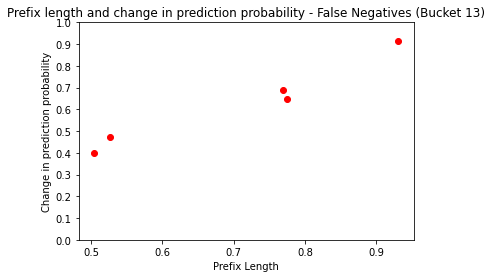

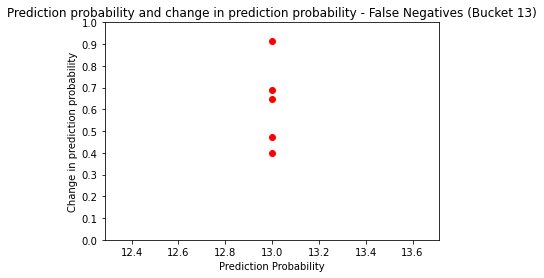

Category 4 of 4. Instance 1 of 3
Creating explanations
[('index__activity_duration_4', -0.2638041, 0.2638041), ('index__weekday_9', 0.25897565, 0.25897565), ('index__hour_0', 0.22321647, 0.22321647), ('index__timesincemidnight_7', -0.21731299, 0.21731299), ('index__activity_duration_11', -0.21308309, 0.21308309), ('index__hour_3', 0.20776132, 0.20776132), ('index__timesincelastevent_8', 0.20696422, 0.20696422), ('index__timesincemidnight_3', 0.19607872, 0.19607872), ('index__open_cases_5', -0.19299044, 0.19299044), ('index__Activity_12_Lapping - Machine 1', -0.18373635, 0.18373635), ('index__Resource_9_ID4882', 0.16094598, 0.16094598), ('index__Resource.1_4_Quality Check 1', -0.13501796, 0.13501796), ('index__timesincelastevent_9', 0.13254344, 0.13254344), ('index__timesincemidnight_6', -0.12957785, 0.12957785), ('index__activity_duration_3', -0.12703942, 0.12703942), ('index__activity_duration_1', 0.12517758, 0.12517758), ('index__Resource_8_ID4287', 0.11666903, 0.11666903), ('index__

Creating explanations
[('index__activity_duration_7', 0.42702422, 0.42702422), ('index__activity_duration_11', -0.23762971, 0.23762971), ('index__timesincelastevent_8', -0.22926822, 0.22926822), ('index__timesincemidnight_3', 0.20455933, 0.20455933), ('index__hour_3', 0.20216164, 0.20216164), ('index__timesincemidnight_12', -0.18938035, 0.18938035), ('index__hour_0', -0.1874956, 0.1874956), ('index__activity_duration_3', -0.18248655, 0.18248655), ('index__timesincemidnight_6', -0.17000674, 0.17000674), ('index__weekday_12', 0.16902338, 0.16902338), ('index__weekday_9', 0.15563144, 0.15563144), ('index__Resource.1_5_Machine 6 - Turning & Milling', 0.14682123, 0.14682123), ('index__timesincemidnight_9', -0.12953639, 0.12953639), ('index__weekday_8', 0.12841791, 0.12841791), ('index__Qty_Completed_12', -0.1245816, 0.1245816), ('index__Qty_Completed_11', -0.123085976, 0.123085976), ('index__hour_9', -0.10319944, 0.10319944), ('index__Report_Type_5_D', -0.101718426, 0.101718426), ('index__h

Creating explanations
[('index__activity_duration_11', 0.3678485, 0.3678485), ('index__Resource.1_8_Machine 6 - Turning & Milling', 0.28519413, 0.28519413), ('index__activity_duration_4', 0.24673988, 0.24673988), ('index__Activity_0_Turning & Milling - Machine 6', 0.23447433, 0.23447433), ('index__timesincelastevent_8', 0.20785388, 0.20785388), ('index__hour_0', -0.19247553, 0.19247553), ('index__Resource_9_ID4932', 0.16923375, 0.16923375), ('index__month_9', -0.16783102, 0.16783102), ('index__activity_duration_5', 0.15601918, 0.15601918), ('index__Resource.1_1_Machine 6 - Turning & Milling', 0.14775886, 0.14775886), ('index__timesincemidnight_7', 0.12772995, 0.12772995), ('index__hour_8', 0.12745962, 0.12745962), ('index__Qty_Completed_11', -0.12654299, 0.12654299), ('index__Resource_4_ID4794', -0.124414176, 0.124414176), ('index__open_cases_4', -0.11968659, 0.11968659), ('index__timesincemidnight_6', -0.11739778, 0.11739778), ('index__activity_duration_0', -0.11598285, 0.11598285), (

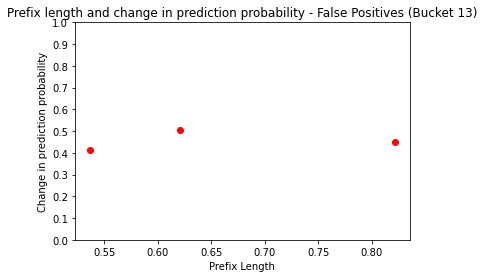

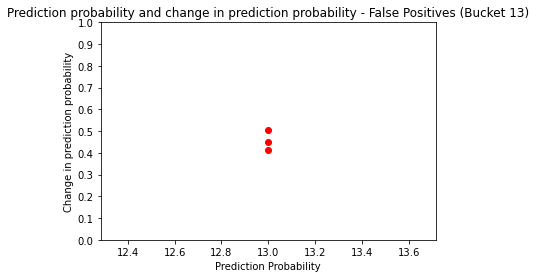

Bucket 14
Generating distributions for bucket
1 of 808 features
2 of 808 features
3 of 808 features
4 of 808 features
5 of 808 features
6 of 808 features
7 of 808 features
8 of 808 features
9 of 808 features
10 of 808 features
11 of 808 features
12 of 808 features
13 of 808 features
14 of 808 features
15 of 808 features
16 of 808 features
17 of 808 features
18 of 808 features
19 of 808 features
20 of 808 features
21 of 808 features
22 of 808 features
23 of 808 features
24 of 808 features
25 of 808 features
26 of 808 features
27 of 808 features
28 of 808 features
29 of 808 features
30 of 808 features
31 of 808 features
32 of 808 features
33 of 808 features
34 of 808 features
35 of 808 features
36 of 808 features
37 of 808 features
38 of 808 features
39 of 808 features
40 of 808 features
41 of 808 features
42 of 808 features
43 of 808 features
44 of 808 features
45 of 808 features
46 of 808 features
47 of 808 features
48 of 808 features
49 of 808 features
50 of 808 features
51 of 808 fea

425 of 808 features
426 of 808 features
427 of 808 features
428 of 808 features
429 of 808 features
430 of 808 features
431 of 808 features
432 of 808 features
433 of 808 features
434 of 808 features
435 of 808 features
436 of 808 features
437 of 808 features
438 of 808 features
439 of 808 features
440 of 808 features
441 of 808 features
442 of 808 features
443 of 808 features
444 of 808 features
445 of 808 features
446 of 808 features
447 of 808 features
448 of 808 features
449 of 808 features
450 of 808 features
451 of 808 features
452 of 808 features
453 of 808 features
454 of 808 features
455 of 808 features
456 of 808 features
457 of 808 features
458 of 808 features
459 of 808 features
460 of 808 features
461 of 808 features
462 of 808 features
463 of 808 features
464 of 808 features
465 of 808 features
466 of 808 features
467 of 808 features
468 of 808 features
469 of 808 features
470 of 808 features
471 of 808 features
472 of 808 features
473 of 808 features
474 of 808 features


Creating explanations
[('index__Qty_Completed_7', -0.40059772, 0.40059772), ('index__timesincecasestart_4', -0.2742762, 0.2742762), ('index__Report_Type_5_S', 0.20990317, 0.20990317), ('index__hour_1', 0.17823525, 0.17823525), ('index__weekday_13', 0.16788444, 0.16788444), ('index__timesincemidnight_10', -0.16396672, 0.16396672), ('index__activity_duration_1', -0.1630403, 0.1630403), ('index__timesincelastevent_8', -0.16237873, 0.16237873), ('index__open_cases_9', -0.15460612, 0.15460612), ('index__activity_duration_10', -0.14481789, 0.14481789), ('index__activity_duration_9', 0.13841663, 0.13841663), ('index__timesincelastevent_2', 0.13172519, 0.13172519), ('index__Activity_12_Final Inspection Q.C.', 0.12094533, 0.12094533), ('index__Resource.1_3_Quality Check 1', 0.11120503, 0.11120503), ('index__Qty_Completed_1', 0.103170514, 0.103170514), ('index__Qty_Completed_3', -0.10120368, 0.10120368), ('index__timesincemidnight_6', -0.099336125, 0.099336125), ('index__activity_duration_11', -

Creating explanations
[('index__timesincelastevent_8', 0.36558715, 0.36558715), ('index__activity_duration_0', 0.28527206, 0.28527206), ('index__timesincecasestart_6', -0.27470005, 0.27470005), ('index__activity_duration_5', -0.27273867, 0.27273867), ('index__timesincecasestart_11', -0.20738779, 0.20738779), ('index__activity_duration_13', -0.20091319, 0.20091319), ('index__open_cases_2', 0.18735938, 0.18735938), ('index__hour_1', 0.17622992, 0.17622992), ('index__Qty_Completed_7', 0.17149074, 0.17149074), ('index__timesincemidnight_10', -0.16400513, 0.16400513), ('index__activity_duration_6', -0.15868106, 0.15868106), ('index__open_cases_9', -0.15392415, 0.15392415), ('index__timesincemidnight_13', -0.14518683, 0.14518683), ('index__Activity_12_Final Inspection Q.C.', 0.13774666, 0.13774666), ('index__timesincemidnight_1', 0.12804307, 0.12804307), ('index__Resource.1_11_Quality Check 1', -0.12580897, 0.12580897), ('index__timesincecasestart_3', 0.12564202, 0.12564202), ('index__open_c

Creating explanations
[('index__activity_duration_5', -0.243855, 0.243855), ('index__timesincecasestart_11', 0.20941332, 0.20941332), ('index__open_cases_9', -0.17436492, 0.17436492), ('index__timesincelastevent_4', -0.16994195, 0.16994195), ('index__timesincemidnight_1', -0.16657886, 0.16657886), ('index__Activity_12_Final Inspection Q.C.', 0.14616948, 0.14616948), ('index__activity_duration_1', 0.125772, 0.125772), ('index__timesincelastevent_2', -0.120864086, 0.120864086), ('index__timesincemidnight_13', -0.12005246, 0.12005246), ('index__activity_duration_10', 0.116391234, 0.116391234), ('static__Part_Desc__Plug', 0.11416486, 0.11416486), ('index__weekday_2', 0.11313023, 0.11313023), ('index__hour_11', 0.10955812, 0.10955812), ('index__hour_5', 0.106898725, 0.106898725), ('index__weekday_13', -0.096915185, 0.096915185), ('index__open_cases_5', -0.09566172, 0.09566172), ('index__Resource_2_ID4429', 0.09415096, 0.09415096), ('index__timesincecasestart_4', 0.08990414, 0.08990414), ('i

Creating explanations
[('index__timesincelastevent_8', 0.36548135, 0.36548135), ('index__Activity_13_Flat Grinding - Machine 11', -0.19331361, 0.19331361), ('index__timesincecasestart_2', -0.19288474, 0.19288474), ('index__activity_duration_1', 0.18545264, 0.18545264), ('index__Qty_Completed_8', 0.17873915, 0.17873915), ('index__open_cases_9', -0.17793606, 0.17793606), ('index__activity_duration_13', -0.17496726, 0.17496726), ('index__timesincemidnight_13', -0.14846745, 0.14846745), ('index__Activity_12_Final Inspection Q.C.', 0.1447852, 0.1447852), ('index__Qty_Completed_3', 0.14370647, 0.14370647), ('index__timesincemidnight_9', -0.1333506, 0.1333506), ('index__timesincemidnight_1', -0.13060158, 0.13060158), ('index__weekday_13', 0.1291786, 0.1291786), ('index__hour_7', -0.12630588, 0.12630588), ('index__activity_duration_0', 0.12486116, 0.12486116), ('index__timesincemidnight_6', -0.12075843, 0.12075843), ('index__activity_duration_10', -0.11417816, 0.11417816), ('index__open_cases_

Creating explanations
[('index__Activity_12_Final Inspection Q.C.', -0.6047, 0.6047), ('index__activity_duration_5', -0.24533053, 0.24533053), ('index__open_cases_2', 0.23542759, 0.23542759), ('index__activity_duration_12', 0.22097477, 0.22097477), ('index__timesincemidnight_10', 0.1893297, 0.1893297), ('index__hour_13', -0.18831451, 0.18831451), ('index__activity_duration_1', -0.1789467, 0.1789467), ('index__Resource_5_ID4618', -0.17797095, 0.17797095), ('index__activity_duration_0', -0.16980839, 0.16980839), ('index__Qty_Completed_7', 0.16863148, 0.16863148), ('index__timesincelastevent_8', -0.1621137, 0.1621137), ('index__timesincelastevent_3', -0.15246674, 0.15246674), ('index__timesincemidnight_13', -0.14829439, 0.14829439), ('index__open_cases_9', -0.14577347, 0.14577347), ('index__timesincemidnight_1', -0.1447404, 0.1447404), ('index__activity_duration_9', 0.13447484, 0.13447484), ('index__timesincecasestart_3', 0.1252913, 0.1252913), ('index__weekday_10', 0.119463414, 0.1194634

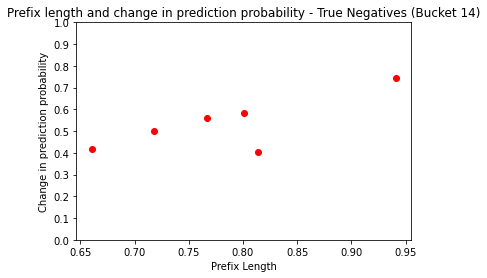

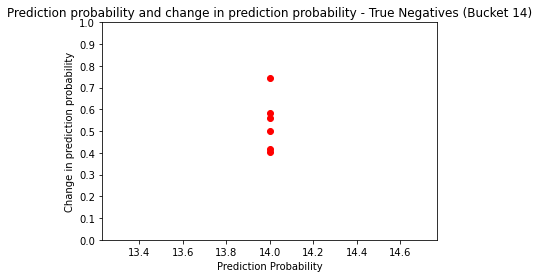

Category 2 of 4. Instance 1 of 6
Creating explanations
[('index__Activity_10_Turning & Milling Q.C.', 0.24522462, 0.24522462), ('index__weekday_6', 0.17863637, 0.17863637), ('index__open_cases_9', -0.17340474, 0.17340474), ('index__timesincemidnight_10', 0.1628669, 0.1628669), ('index__activity_duration_1', 0.15835495, 0.15835495), ('index__open_cases_2', 0.15760486, 0.15760486), ('index__Qty_Completed_1', -0.1541437, 0.1541437), ('index__timesincemidnight_1', -0.1529656, 0.1529656), ('index__timesincelastevent_13', -0.15114045, 0.15114045), ('index__timesincemidnight_13', -0.14568198, 0.14568198), ('index__activity_duration_10', -0.1448567, 0.1448567), ('index__timesincemidnight_4', -0.13988216, 0.13988216), ('index__timesincelastevent_1', 0.13928728, 0.13928728), ('index__timesincelastevent_2', -0.13323124, 0.13323124), ('index__hour_5', -0.13207953, 0.13207953), ('index__Resource.1_11_Quality Check 1', -0.13197011, 0.13197011), ('index__timesincelastevent_8', -0.12975384, 0.12975384

Creating explanations
[('index__timesincemidnight_1', -0.3058343, 0.3058343), ('index__timesincecasestart_4', -0.28522852, 0.28522852), ('index__activity_duration_5', -0.26064533, 0.26064533), ('index__activity_duration_13', -0.23176645, 0.23176645), ('index__timesincelastevent_8', 0.2012415, 0.2012415), ('index__timesincemidnight_2', -0.19236377, 0.19236377), ('index__timesincecasestart_6', 0.19036129, 0.19036129), ('index__timesincemidnight_10', -0.17286016, 0.17286016), ('index__activity_duration_1', 0.1603851, 0.1603851), ('index__Qty_Completed_8', 0.15790074, 0.15790074), ('index__timesincemidnight_9', 0.14792916, 0.14792916), ('index__timesincemidnight_13', -0.14457855, 0.14457855), ('index__activity_duration_12', 0.1414941, 0.1414941), ('index__Qty_Completed_1', 0.13225384, 0.13225384), ('index__timesincelastevent_2', 0.13141404, 0.13141404), ('index__open_cases_2', 0.130893, 0.130893), ('index__timesincemidnight_4', 0.13062857, 0.13062857), ('index__Activity_12_Final Inspection

Creating explanations
[('index__activity_duration_5', -0.27236214, 0.27236214), ('index__Qty_Completed_7', 0.24010727, 0.24010727), ('index__Activity_10_Turning & Milling Q.C.', 0.21313739, 0.21313739), ('index__timesincecasestart_6', 0.19617163, 0.19617163), ('index__activity_duration_0', -0.18814078, 0.18814078), ('index__hour_1', 0.18065137, 0.18065137), ('index__timesincemidnight_1', 0.17122853, 0.17122853), ('index__Activity_12_Final Inspection Q.C.', 0.1517008, 0.1517008), ('index__open_cases_9', -0.14849466, 0.14849466), ('index__timesincemidnight_10', 0.14379543, 0.14379543), ('index__timesincemidnight_4', -0.13988216, 0.13988216), ('index__activity_duration_1', 0.13957411, 0.13957411), ('index__hour_13', 0.13203114, 0.13203114), ('index__hour_5', -0.13009432, 0.13009432), ('index__timesincecasestart_3', 0.12473165, 0.12473165), ('index__open_cases_10', -0.112343736, 0.112343736), ('index__Resource.1_11_Machine 1 - Lapping', -0.111546904, 0.111546904), ('index__Qty_Completed_1'

Creating explanations
[('index__Qty_Completed_7', -0.38070738, 0.38070738), ('index__timesincelastevent_8', 0.34803483, 0.34803483), ('index__activity_duration_12', 0.2766594, 0.2766594), ('index__timesincemidnight_9', 0.18767658, 0.18767658), ('index__hour_1', 0.18065137, 0.18065137), ('index__Qty_Completed_8', 0.17873915, 0.17873915), ('index__open_cases_9', -0.17465569, 0.17465569), ('index__timesincecasestart_6', 0.17247654, 0.17247654), ('index__weekday_13', 0.16888797, 0.16888797), ('index__timesincemidnight_10', -0.16612846, 0.16612846), ('index__timesincelastevent_13', -0.15769614, 0.15769614), ('index__Qty_Completed_3', 0.14993635, 0.14993635), ('index__timesincelastevent_2', -0.14886414, 0.14886414), ('index__timesincemidnight_1', 0.14334252, 0.14334252), ('index__activity_duration_1', 0.13945422, 0.13945422), ('index__Activity_12_Final Inspection Q.C.', 0.13881573, 0.13881573), ('index__hour_13', -0.1382359, 0.1382359), ('index__timesincemidnight_4', 0.13062857, 0.13062857),

Creating explanations
[('index__activity_duration_5', 0.25124875, 0.25124875), ('index__activity_duration_12', 0.22673489, 0.22673489), ('index__timesincemidnight_13', 0.22321391, 0.22321391), ('index__timesincecasestart_11', 0.21131808, 0.21131808), ('index__timesincelastevent_13', -0.1918172, 0.1918172), ('index__open_cases_9', -0.18568799, 0.18568799), ('index__Qty_Completed_7', 0.18078814, 0.18078814), ('index__activity_duration_1', 0.18069762, 0.18069762), ('index__hour_13', 0.17011768, 0.17011768), ('index__timesincemidnight_1', 0.15274613, 0.15274613), ('index__Activity_12_Final Inspection Q.C.', 0.14520957, 0.14520957), ('index__hour_1', 0.14238244, 0.14238244), ('index__timesincemidnight_10', 0.13590235, 0.13590235), ('index__timesincelastevent_2', 0.13385087, 0.13385087), ('index__timesincemidnight_9', -0.13158108, 0.13158108), ('index__activity_duration_0', 0.12322559, 0.12322559), ('index__timesincecasestart_6', 0.122659184, 0.122659184), ('index__open_cases_10', -0.1127056

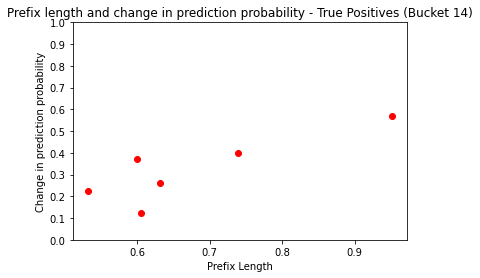

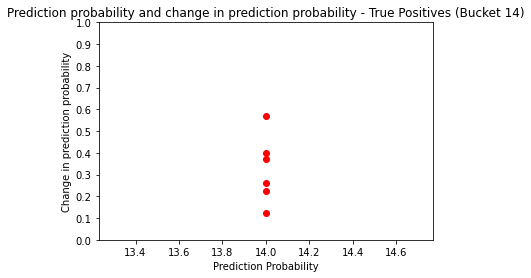

Category 3 of 4. Instance 1 of 3
Creating explanations
[('index__Qty_Completed_7', 0.27909234, 0.27909234), ('index__timesincecasestart_6', 0.1961269, 0.1961269), ('index__hour_13', -0.18621755, 0.18621755), ('index__weekday_6', 0.17841844, 0.17841844), ('index__open_cases_9', -0.17635761, 0.17635761), ('index__timesincemidnight_13', -0.15700108, 0.15700108), ('index__timesincecasestart_4', 0.15690547, 0.15690547), ('index__Resource_2_ID4429', 0.15637723, 0.15637723), ('index__timesincemidnight_1', -0.1550387, 0.1550387), ('index__timesincecasestart_11', 0.14481838, 0.14481838), ('index__Activity_12_Final Inspection Q.C.', 0.14455524, 0.14455524), ('index__timesincelastevent_4', -0.13732657, 0.13732657), ('index__timesincemidnight_9', -0.13246706, 0.13246706), ('index__timesincelastevent_8', -0.12854895, 0.12854895), ('index__timesincelastevent_2', 0.1240248, 0.1240248), ('index__timesincelastevent_6', 0.11338715, 0.11338715), ('index__Qty_Completed_8', 0.11250755, 0.11250755), ('index

Creating explanations
[('index__timesincemidnight_1', -0.27152234, 0.27152234), ('index__hour_5', 0.24082465, 0.24082465), ('index__timesincelastevent_13', -0.18041535, 0.18041535), ('index__activity_duration_1', -0.17962706, 0.17962706), ('index__weekday_6', 0.1755622, 0.1755622), ('index__timesincemidnight_9', 0.1645719, 0.1645719), ('index__open_cases_9', -0.16105676, 0.16105676), ('index__timesincelastevent_8', -0.15888575, 0.15888575), ('index__hour_6', 0.15344961, 0.15344961), ('index__timesincecasestart_6', 0.150896, 0.150896), ('index__activity_duration_13', -0.14888452, 0.14888452), ('index__Report_Type_5_S', 0.14098205, 0.14098205), ('index__Resource.1_11_Quality Check 1', -0.13563749, 0.13563749), ('index__timesincecasestart_11', 0.12458842, 0.12458842), ('index__Activity_12_Final Inspection Q.C.', 0.12411905, 0.12411905), ('index__timesincelastevent_2', -0.11752056, 0.11752056), ('index__activity_duration_10', -0.11540896, 0.11540896), ('index__open_cases_10', -0.107858755,

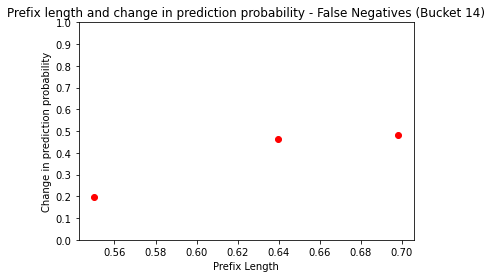

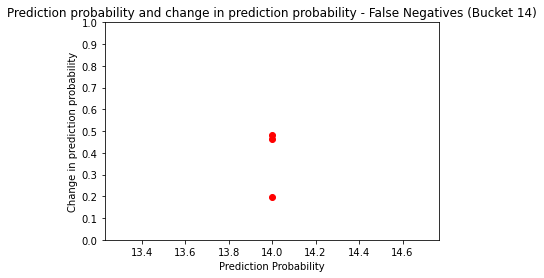

Category 4 of 4. Instance 1 of 2
Creating explanations
[('index__timesincemidnight_1', -0.26599818, 0.26599818), ('index__timesincelastevent_3', -0.20436078, 0.20436078), ('index__Qty_Completed_7', 0.19754775, 0.19754775), ('index__activity_duration_5', 0.19018936, 0.19018936), ('index__timesincecasestart_6', 0.18910527, 0.18910527), ('index__activity_duration_0', -0.18114665, 0.18114665), ('index__timesincecasestart_4', 0.15802075, 0.15802075), ('index__open_cases_9', -0.14933155, 0.14933155), ('index__Activity_12_Final Inspection Q.C.', 0.14514236, 0.14514236), ('index__timesincelastevent_8', -0.13893083, 0.13893083), ('index__timesincecasestart_10', 0.13788038, 0.13788038), ('index__timesincemidnight_6', -0.13252383, 0.13252383), ('index__timesincemidnight_3', 0.13207462, 0.13207462), ('index__hour_13', 0.13185562, 0.13185562), ('index__timesincemidnight_10', -0.12960266, 0.12960266), ('index__timesincecasestart_3', 0.12509961, 0.12509961), ('index__activity_duration_13', 0.11997548

Creating explanations
[('index__timesincemidnight_1', -0.349254, 0.349254), ('index__Qty_Completed_7', -0.32973495, 0.32973495), ('index__timesincelastevent_8', 0.30570793, 0.30570793), ('index__activity_duration_5', 0.25145283, 0.25145283), ('index__activity_duration_1', 0.20908599, 0.20908599), ('index__open_cases_2', 0.19807349, 0.19807349), ('index__open_cases_9', -0.17769448, 0.17769448), ('index__activity_duration_13', -0.17647797, 0.17647797), ('index__Qty_Completed_8', 0.16463967, 0.16463967), ('index__weekday_10', -0.15393232, 0.15393232), ('index__Resource.1_5_Machine 6 - Turning & Milling', 0.14617862, 0.14617862), ('index__Activity_12_Final Inspection Q.C.', 0.1438716, 0.1438716), ('index__Qty_Completed_3', 0.14304948, 0.14304948), ('index__timesincemidnight_9', -0.13026446, 0.13026446), ('index__timesincemidnight_13', 0.12991214, 0.12991214), ('index__Qty_Completed_5', 0.12956512, 0.12956512), ('index__timesincelastevent_2', -0.12605627, 0.12605627), ('index__Resource.1_11

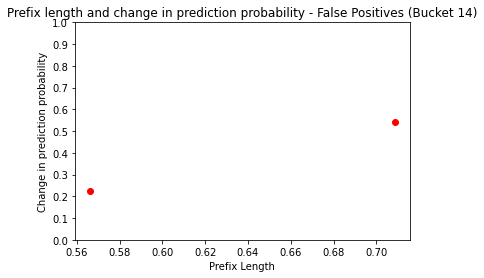

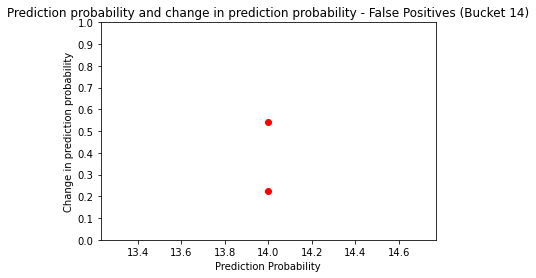

Bucket 15
Generating distributions for bucket
1 of 779 features
2 of 779 features
3 of 779 features
4 of 779 features
5 of 779 features
6 of 779 features
7 of 779 features
8 of 779 features
9 of 779 features
10 of 779 features
11 of 779 features
12 of 779 features
13 of 779 features
14 of 779 features
15 of 779 features
16 of 779 features
17 of 779 features
18 of 779 features
19 of 779 features
20 of 779 features
21 of 779 features
22 of 779 features
23 of 779 features
24 of 779 features
25 of 779 features
26 of 779 features
27 of 779 features
28 of 779 features
29 of 779 features
30 of 779 features
31 of 779 features
32 of 779 features
33 of 779 features
34 of 779 features
35 of 779 features
36 of 779 features
37 of 779 features
38 of 779 features
39 of 779 features
40 of 779 features
41 of 779 features
42 of 779 features
43 of 779 features
44 of 779 features
45 of 779 features
46 of 779 features
47 of 779 features
48 of 779 features
49 of 779 features
50 of 779 features
51 of 779 fea

476 of 779 features
477 of 779 features
478 of 779 features
479 of 779 features
480 of 779 features
481 of 779 features
482 of 779 features
483 of 779 features
484 of 779 features
485 of 779 features
486 of 779 features
487 of 779 features
488 of 779 features
489 of 779 features
490 of 779 features
491 of 779 features
492 of 779 features
493 of 779 features
494 of 779 features
495 of 779 features
496 of 779 features
497 of 779 features
498 of 779 features
499 of 779 features
500 of 779 features
501 of 779 features
502 of 779 features
503 of 779 features
504 of 779 features
505 of 779 features
506 of 779 features
507 of 779 features
508 of 779 features
509 of 779 features
510 of 779 features
511 of 779 features
512 of 779 features
513 of 779 features
514 of 779 features
515 of 779 features
516 of 779 features
517 of 779 features
518 of 779 features
519 of 779 features
520 of 779 features
521 of 779 features
522 of 779 features
523 of 779 features
524 of 779 features
525 of 779 features


Creating explanations
[('index__timesincecasestart_6', 0.35642353, 0.35642353), ('index__activity_duration_11', -0.34893438, 0.34893438), ('index__hour_3', 0.24192531, 0.24192531), ('index__Qty_Completed_14', 0.23238249, 0.23238249), ('index__hour_12', 0.21347727, 0.21347727), ('index__timesincecasestart_8', 0.20892651, 0.20892651), ('index__Qty_Completed_3', -0.19939812, 0.19939812), ('index__Resource.1_0_Machine 8 - Turning & Milling', -0.18861015, 0.18861015), ('index__activity_duration_12', 0.16953, 0.16953), ('index__Qty_Completed_11', 0.14619572, 0.14619572), ('index__weekday_10', 0.14464879, 0.14464879), ('index__timesincelastevent_6', 0.1441566, 0.1441566), ('index__hour_1', -0.14391053, 0.14391053), ('index__timesincelastevent_14', -0.14139745, 0.14139745), ('index__activity_duration_14', -0.1365401, 0.1365401), ('index__timesincemidnight_8', -0.13437396, 0.13437396), ('index__open_cases_7', -0.12500924, 0.12500924), ('index__Resource.1_7_Machine 8 - Turning & Milling', 0.1218

Creating explanations
[('index__activity_duration_1', 0.342896, 0.342896), ('index__activity_duration_11', 0.34156457, 0.34156457), ('index__timesincecasestart_6', -0.27468595, 0.27468595), ('index__weekday_10', -0.25572747, 0.25572747), ('index__Qty_Completed_14', -0.23086968, 0.23086968), ('index__Qty_Completed_13', 0.22350535, 0.22350535), ('index__hour_1', -0.22326833, 0.22326833), ('index__Qty_Completed_3', 0.21061769, 0.21061769), ('index__Activity_13_Final Inspection Q.C.', -0.19149977, 0.19149977), ('index__timesincelastevent_10', -0.1853827, 0.1853827), ('index__timesincelastevent_8', 0.17611806, 0.17611806), ('index__activity_duration_8', 0.16795267, 0.16795267), ('index__hour_12', -0.15046073, 0.15046073), ('index__timesincemidnight_8', 0.14704677, 0.14704677), ('index__timesincelastevent_6', 0.14270645, 0.14270645), ('index__timesincelastevent_14', -0.13656686, 0.13656686), ('index__activity_duration_5', 0.12734084, 0.12734084), ('index__activity_duration_14', -0.12510216, 

Creating explanations
[('index__timesincecasestart_6', -0.33554453, 0.33554453), ('index__activity_duration_11', -0.28908288, 0.28908288), ('index__Report_Type_5_S', 0.24342066, 0.24342066), ('index__Qty_Completed_14', -0.23114574, 0.23114574), ('index__hour_12', 0.16938233, 0.16938233), ('index__open_cases_8', -0.1657989, 0.1657989), ('index__hour_1', 0.16299161, 0.16299161), ('index__Qty_Completed_3', -0.15326273, 0.15326273), ('index__open_cases_13', 0.1524411, 0.1524411), ('index__timesincelastevent_6', 0.15151255, 0.15151255), ('index__weekday_10', 0.14275768, 0.14275768), ('index__Qty_Completed_5', -0.13939133, 0.13939133), ('index__timesincemidnight_7', -0.13443038, 0.13443038), ('index__hour_4', -0.12801975, 0.12801975), ('index__Qty_Completed_10', -0.1263055, 0.1263055), ('index__hour_3', -0.12165804, 0.12165804), ('index__activity_duration_5', -0.1201462, 0.1201462), ('index__Activity_4_Turning & Milling - Machine 5', -0.115910545, 0.115910545), ('index__activity_duration_8',

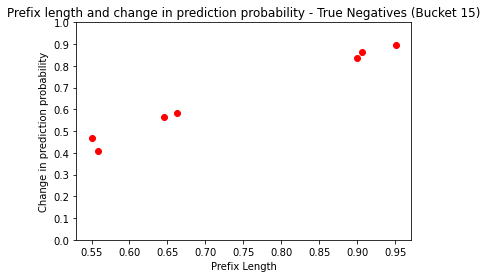

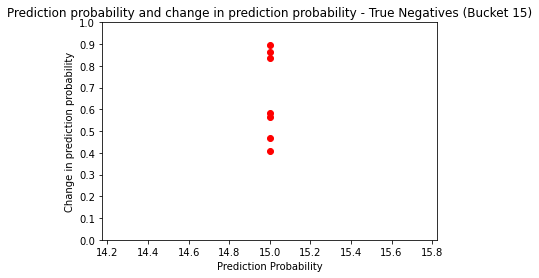

Category 2 of 4. Instance 1 of 7
Creating explanations
[('index__activity_duration_1', 0.39490655, 0.39490655), ('index__activity_duration_11', -0.29197115, 0.29197115), ('index__weekday_10', 0.28306603, 0.28306603), ('index__timesincecasestart_6', -0.2674426, 0.2674426), ('index__timesincemidnight_8', 0.25453743, 0.25453743), ('index__timesincelastevent_10', 0.2325584, 0.2325584), ('index__hour_3', -0.1700423, 0.1700423), ('index__Qty_Completed_14', -0.16595674, 0.16595674), ('index__hour_12', -0.161804, 0.161804), ('index__activity_duration_12', -0.16162375, 0.16162375), ('index__activity_duration_14', 0.15695322, 0.15695322), ('index__Report_Type_0_B', 0.15613233, 0.15613233), ('index__hour_4', -0.14709882, 0.14709882), ('index__Qty_Completed_0', 0.13471363, 0.13471363), ('index__open_cases_13', 0.12983343, 0.12983343), ('index__Resource.1_8_Machine 9 - Turning & Milling', 0.12954947, 0.12954947), ('index__Qty_Completed_11', 0.121913835, 0.121913835), ('index__activity_duration_4', 

Creating explanations
[('index__weekday_10', 0.31350085, 0.31350085), ('index__activity_duration_11', -0.2971635, 0.2971635), ('index__activity_duration_1', 0.2950328, 0.2950328), ('index__timesincemidnight_8', 0.2630421, 0.2630421), ('index__Qty_Completed_14', 0.24449745, 0.24449745), ('index__Activity_5_Turning & Milling Q.C.', -0.2341835, 0.2341835), ('index__activity_duration_14', 0.21765476, 0.21765476), ('index__timesincecasestart_6', 0.20561746, 0.20561746), ('index__timesincelastevent_7', 0.17621434, 0.17621434), ('index__timesincelastevent_6', 0.16069631, 0.16069631), ('index__activity_duration_2', 0.15438543, 0.15438543), ('index__Qty_Completed_0', 0.14403006, 0.14403006), ('index__open_cases_13', 0.13896814, 0.13896814), ('index__Qty_Completed_10', 0.137571, 0.137571), ('index__timesincemidnight_13', -0.13337006, 0.13337006), ('index__activity_duration_4', -0.13285564, 0.13285564), ('index__hour_13', 0.1303528, 0.1303528), ('index__open_cases_7', -0.12333398, 0.12333398), ('

Creating explanations
[('index__activity_duration_1', 0.35690424, 0.35690424), ('index__timesincecasestart_6', 0.35637033, 0.35637033), ('index__activity_duration_11', -0.2971635, 0.2971635), ('index__Qty_Completed_14', 0.2444754, 0.2444754), ('index__timesincemidnight_8', 0.2197165, 0.2197165), ('index__timesincelastevent_10', 0.2187833, 0.2187833), ('index__timesincecasestart_8', 0.21875194, 0.21875194), ('index__hour_3', 0.19952497, 0.19952497), ('static__Work_Order_Qty', 0.19022885, 0.19022885), ('index__activity_duration_8', 0.17442785, 0.17442785), ('index__hour_1', -0.15594366, 0.15594366), ('index__activity_duration_2', 0.14851588, 0.14851588), ('index__Qty_Completed_0', 0.1436482, 0.1436482), ('index__weekday_10', 0.14227279, 0.14227279), ('index__timesincelastevent_14', -0.14081626, 0.14081626), ('index__Qty_Completed_10', -0.13784896, 0.13784896), ('index__timesincelastevent_7', -0.12798494, 0.12798494), ('index__timesincelastevent_8', 0.1255018, 0.1255018), ('index__hour_13

Creating explanations
[('index__activity_duration_11', 0.34156457, 0.34156457), ('index__activity_duration_1', 0.31074387, 0.31074387), ('index__timesincecasestart_6', 0.28750032, 0.28750032), ('index__Qty_Completed_14', 0.24529019, 0.24529019), ('index__activity_duration_14', 0.2103476, 0.2103476), ('index__timesincecasestart_8', 0.20868914, 0.20868914), ('static__Work_Order_Qty', 0.195364, 0.195364), ('index__Qty_Completed_3', -0.19019733, 0.19019733), ('index__timesincelastevent_10', -0.18790126, 0.18790126), ('index__hour_3', -0.187264, 0.187264), ('index__activity_duration_2', 0.15446307, 0.15446307), ('index__Qty_Completed_0', 0.1438866, 0.1438866), ('index__hour_13', 0.14054532, 0.14054532), ('index__Resource.1_2_Quality Check 1', -0.13730405, 0.13730405), ('index__timesincemidnight_8', -0.13085955, 0.13085955), ('index__timesincelastevent_6', 0.13026968, 0.13026968), ('index__activity_duration_4', -0.12929723, 0.12929723), ('index__hour_5', 0.12429059, 0.12429059), ('index__ope

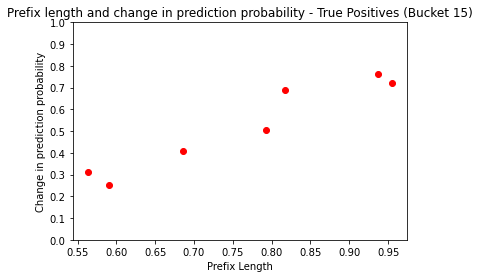

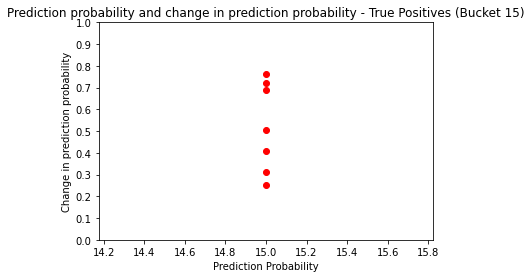

Category 3 of 4. Instance 1 of 1
Creating explanations
[('index__activity_duration_11', -0.34893438, 0.34893438), ('index__timesincecasestart_6', 0.23842983, 0.23842983), ('index__hour_12', -0.23570046, 0.23570046), ('index__hour_3', -0.23311989, 0.23311989), ('index__Qty_Completed_14', 0.23252796, 0.23252796), ('index__timesincecasestart_8', 0.19434315, 0.19434315), ('index__Resource.1_0_Machine 8 - Turning & Milling', -0.1914216, 0.1914216), ('index__activity_duration_2', -0.18207927, 0.18207927), ('index__timesincelastevent_10', -0.17807497, 0.17807497), ('index__hour_7', 0.16891763, 0.16891763), ('index__timesincemidnight_4', 0.14746663, 0.14746663), ('index__open_cases_13', 0.14116405, 0.14116405), ('index__Qty_Completed_0', 0.13450792, 0.13450792), ('index__timesincemidnight_8', -0.13044675, 0.13044675), ('index__hour_13', 0.12954885, 0.12954885), ('index__open_cases_7', -0.12500924, 0.12500924), ('index__Resource.1_7_Machine 8 - Turning & Milling', 0.12187663, 0.12187663), ('ind

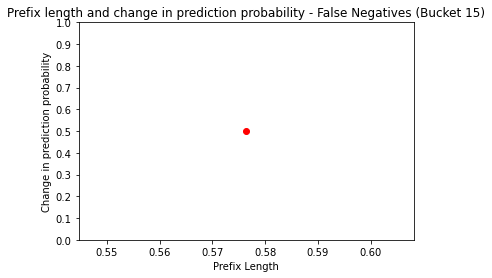

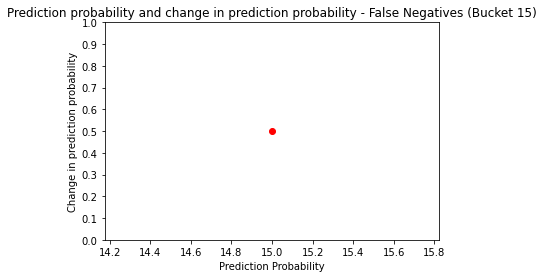

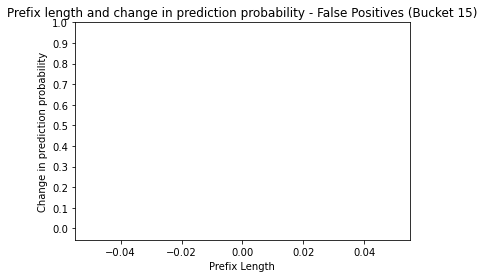

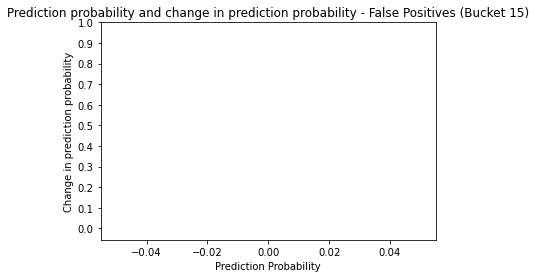

Bucket 16
Generating distributions for bucket
1 of 794 features
2 of 794 features
3 of 794 features
4 of 794 features
5 of 794 features
6 of 794 features
7 of 794 features
8 of 794 features
9 of 794 features
10 of 794 features
11 of 794 features
12 of 794 features
13 of 794 features
14 of 794 features
15 of 794 features
16 of 794 features
17 of 794 features
18 of 794 features
19 of 794 features
20 of 794 features
21 of 794 features
22 of 794 features
23 of 794 features
24 of 794 features
25 of 794 features
26 of 794 features
27 of 794 features
28 of 794 features
29 of 794 features
30 of 794 features
31 of 794 features
32 of 794 features
33 of 794 features
34 of 794 features
35 of 794 features
36 of 794 features
37 of 794 features
38 of 794 features
39 of 794 features
40 of 794 features
41 of 794 features
42 of 794 features
43 of 794 features
44 of 794 features
45 of 794 features
46 of 794 features
47 of 794 features
48 of 794 features
49 of 794 features
50 of 794 features
51 of 794 fea

588 of 794 features
589 of 794 features
590 of 794 features
591 of 794 features
592 of 794 features
593 of 794 features
594 of 794 features
595 of 794 features
596 of 794 features
597 of 794 features
598 of 794 features
599 of 794 features
600 of 794 features
601 of 794 features
602 of 794 features
603 of 794 features
604 of 794 features
605 of 794 features
606 of 794 features
607 of 794 features
608 of 794 features
609 of 794 features
610 of 794 features
611 of 794 features
612 of 794 features
613 of 794 features
614 of 794 features
615 of 794 features
616 of 794 features
617 of 794 features
618 of 794 features
619 of 794 features
620 of 794 features
621 of 794 features
622 of 794 features
623 of 794 features
624 of 794 features
625 of 794 features
626 of 794 features
627 of 794 features
628 of 794 features
629 of 794 features
630 of 794 features
631 of 794 features
632 of 794 features
633 of 794 features
634 of 794 features
635 of 794 features
636 of 794 features
637 of 794 features


Creating explanations
[('index__weekday_15', -0.23817308, 0.23817308), ('index__Qty_Completed_10', -0.20698814, 0.20698814), ('index__timesincemidnight_12', 0.1920554, 0.1920554), ('index__Qty_Completed_1', -0.18663938, 0.18663938), ('index__Qty_Completed_15', -0.18383558, 0.18383558), ('index__weekday_10', 0.16632757, 0.16632757), ('index__timesincecasestart_11', -0.16612412, 0.16612412), ('index__open_cases_12', -0.15689947, 0.15689947), ('index__timesincecasestart_1', -0.15255345, 0.15255345), ('index__Qty_Completed_14', 0.15068913, 0.15068913), ('index__timesincelastevent_3', -0.13920704, 0.13920704), ('index__hour_1', -0.13287538, 0.13287538), ('index__weekday_11', 0.12959301, 0.12959301), ('index__timesincecasestart_6', 0.1283584, 0.1283584), ('index__Qty_Completed_6', 0.12526399, 0.12526399), ('index__timesincelastevent_2', 0.115953, 0.115953), ('index__activity_duration_2', 0.10971188, 0.10971188), ('index__activity_duration_1', -0.10702105, 0.10702105), ('index__activity_durat

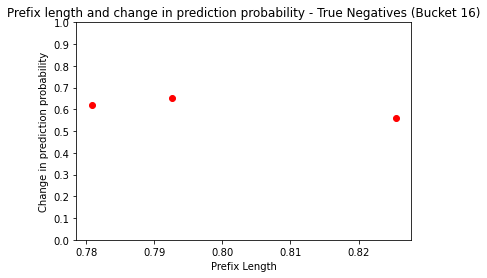

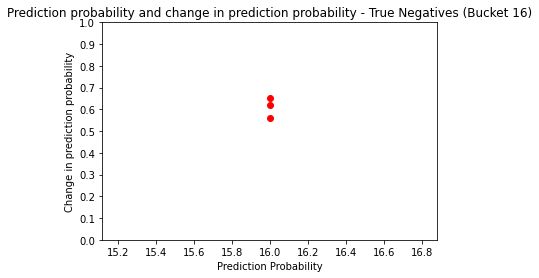

Category 2 of 4. Instance 1 of 5
Creating explanations
[('index__Qty_Completed_8', 0.27626845, 0.27626845), ('index__Qty_Completed_10', -0.26512626, 0.26512626), ('index__activity_duration_3', -0.23125449, 0.23125449), ('index__timesincecasestart_1', -0.21616992, 0.21616992), ('index__Qty_Completed_14', 0.19596313, 0.19596313), ('index__open_cases_12', -0.18675637, 0.18675637), ('index__Qty_Completed_1', 0.17890327, 0.17890327), ('index__weekday_10', 0.17882016, 0.17882016), ('index__Qty_Completed_6', -0.16300297, 0.16300297), ('static__Work_Order_Qty', 0.158451, 0.158451), ('index__Report_Type_5_D', 0.15718427, 0.15718427), ('index__activity_duration_8', 0.13013549, 0.13013549), ('index__activity_duration_11', 0.1259282, 0.1259282), ('index__timesincecasestart_6', 0.12540318, 0.12540318), ('index__hour_1', -0.12089111, 0.12089111), ('index__timesincecasestart_9', 0.11567181, 0.11567181), ('index__Activity_1_Turning & Milling - Machine 5', -0.11025052, 0.11025052), ('index__open_cases_

Creating explanations
[('index__Qty_Completed_15', 0.27331606, 0.27331606), ('index__Qty_Completed_6', -0.22171508, 0.22171508), ('index__activity_duration_1', 0.2163169, 0.2163169), ('index__timesincemidnight_12', 0.2040536, 0.2040536), ('index__timesincemidnight_5', 0.19159162, 0.19159162), ('index__weekday_10', -0.19095087, 0.19095087), ('index__Qty_Completed_1', -0.18087462, 0.18087462), ('index__open_cases_12', -0.14871058, 0.14871058), ('index__weekday_8', -0.14730884, 0.14730884), ('index__activity_duration_15', 0.1432958, 0.1432958), ('index__Qty_Completed_14', 0.14292748, 0.14292748), ('index__activity_duration_8', 0.13950104, 0.13950104), ('index__timesincelastevent_3', -0.13933036, 0.13933036), ('index__timesincecasestart_9', 0.13365762, 0.13365762), ('index__timesincecasestart_15', -0.13185786, 0.13185786), ('index__Qty_Completed_10', 0.13176903, 0.13176903), ('index__Report_Type_10_D', 0.1289649, 0.1289649), ('index__hour_1', -0.118589185, 0.118589185), ('index__activity_d

Creating explanations
[('index__Qty_Completed_8', 0.2818257, 0.2818257), ('index__Qty_Completed_1', 0.23795027, 0.23795027), ('index__timesincelastevent_3', 0.23171742, 0.23171742), ('index__timesincecasestart_1', -0.2256281, 0.2256281), ('index__Qty_Completed_15', 0.19975342, 0.19975342), ('index__Qty_Completed_14', 0.19596313, 0.19596313), ('index__open_cases_12', -0.18760775, 0.18760775), ('index__timesincecasestart_11', -0.18591978, 0.18591978), ('index__weekday_10', 0.1747487, 0.1747487), ('index__Qty_Completed_10', 0.17327309, 0.17327309), ('static__Work_Order_Qty', 0.15428244, 0.15428244), ('index__timesincemidnight_13', -0.14694984, 0.14694984), ('index__activity_duration_8', 0.14316663, 0.14316663), ('index__timesincelastevent_2', -0.12402957, 0.12402957), ('index__Qty_Completed_6', -0.12351866, 0.12351866), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.120200105, 0.120200105), ('index__activity_duration_4', 0.119595386, 0.119595386), ('index__activity_duration_15', 

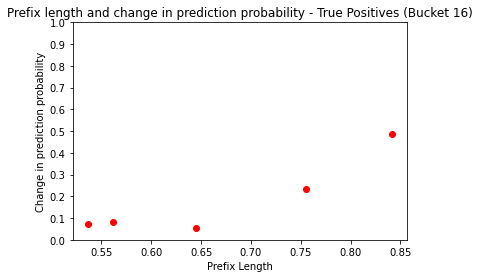

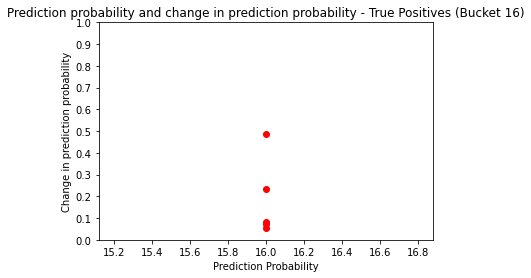

Category 3 of 4. Instance 1 of 2
Creating explanations
[('index__timesincemidnight_13', 0.2848626, 0.2848626), ('index__Qty_Completed_1', 0.2743072, 0.2743072), ('index__Qty_Completed_6', -0.21633354, 0.21633354), ('index__weekday_10', 0.1951378, 0.1951378), ('index__Qty_Completed_14', 0.1948664, 0.1948664), ('index__timesincecasestart_1', -0.19472706, 0.19472706), ('index__Activity_5_Turning & Milling Q.C.', -0.18477887, 0.18477887), ('index__timesincemidnight_12', -0.17511353, 0.17511353), ('index__Qty_Completed_10', 0.17327309, 0.17327309), ('index__timesincelastevent_3', -0.13568619, 0.13568619), ('index__open_cases_12', -0.132894, 0.132894), ('index__activity_duration_2', 0.12201934, 0.12201934), ('index__Resource.1_0_Machine 4 - Turning & Milling', 0.120200105, 0.120200105), ('index__timesincecasestart_6', 0.11994171, 0.11994171), ('index__timesincecasestart_5', -0.118455544, 0.118455544), ('index__Resource.1_11_Machine 1 - Lapping', -0.11531773, 0.11531773), ('index__weekday_11'

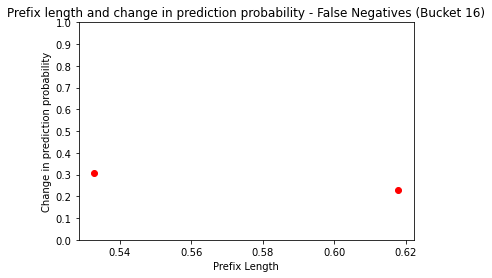

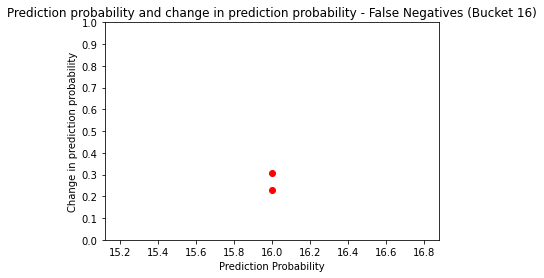

Category 4 of 4. Instance 1 of 1
Creating explanations
[('index__timesincelastevent_3', 0.23171742, 0.23171742), ('index__Qty_Completed_15', -0.21269745, 0.21269745), ('index__Report_Type_5_D', 0.19984125, 0.19984125), ('index__timesincemidnight_12', 0.19169772, 0.19169772), ('index__open_cases_12', -0.18893553, 0.18893553), ('index__timesincecasestart_11', -0.1869211, 0.1869211), ('index__Qty_Completed_1', 0.18059823, 0.18059823), ('index__weekday_10', 0.17816897, 0.17816897), ('index__activity_duration_11', 0.17002957, 0.17002957), ('index__Activity_1_Turning Q.C.', 0.15653193, 0.15653193), ('index__timesincecasestart_5', 0.14755036, 0.14755036), ('index__Qty_Completed_6', 0.14461313, 0.14461313), ('static__Work_Order_Qty', -0.14040384, 0.14040384), ('index__timesincelastevent_13', 0.13127078, 0.13127078), ('index__timesincemidnight_8', -0.12718752, 0.12718752), ('index__weekday_11', 0.12688434, 0.12688434), ('index__Qty_Completed_10', -0.1221348, 0.1221348), ('index__open_cases_8', 

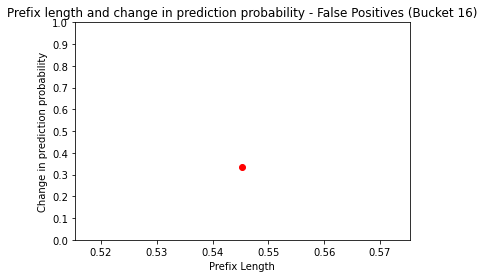

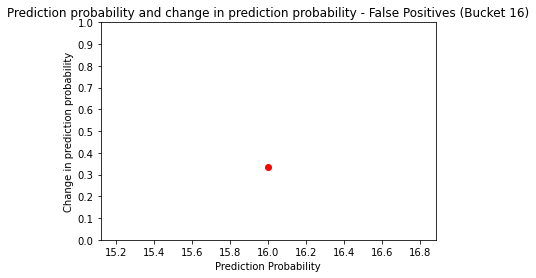

Bucket 17
Generating distributions for bucket
1 of 796 features
2 of 796 features
3 of 796 features
4 of 796 features
5 of 796 features
6 of 796 features
7 of 796 features
8 of 796 features
9 of 796 features
10 of 796 features
11 of 796 features
12 of 796 features
13 of 796 features
14 of 796 features
15 of 796 features
16 of 796 features
17 of 796 features
18 of 796 features
19 of 796 features
20 of 796 features
21 of 796 features
22 of 796 features
23 of 796 features
24 of 796 features
25 of 796 features
26 of 796 features
27 of 796 features
28 of 796 features
29 of 796 features
30 of 796 features
31 of 796 features
32 of 796 features
33 of 796 features
34 of 796 features
35 of 796 features
36 of 796 features
37 of 796 features
38 of 796 features
39 of 796 features
40 of 796 features
41 of 796 features
42 of 796 features
43 of 796 features
44 of 796 features
45 of 796 features
46 of 796 features
47 of 796 features
48 of 796 features
49 of 796 features
50 of 796 features
51 of 796 fea

583 of 796 features
584 of 796 features
585 of 796 features
586 of 796 features
587 of 796 features
588 of 796 features
589 of 796 features
590 of 796 features
591 of 796 features
592 of 796 features
593 of 796 features
594 of 796 features
595 of 796 features
596 of 796 features
597 of 796 features
598 of 796 features
599 of 796 features
600 of 796 features
601 of 796 features
602 of 796 features
603 of 796 features
604 of 796 features
605 of 796 features
606 of 796 features
607 of 796 features
608 of 796 features
609 of 796 features
610 of 796 features
611 of 796 features
612 of 796 features
613 of 796 features
614 of 796 features
615 of 796 features
616 of 796 features
617 of 796 features
618 of 796 features
619 of 796 features
620 of 796 features
621 of 796 features
622 of 796 features
623 of 796 features
624 of 796 features
625 of 796 features
626 of 796 features
627 of 796 features
628 of 796 features
629 of 796 features
630 of 796 features
631 of 796 features
632 of 796 features


Creating explanations
[('index__timesincecasestart_2', -0.22202261, 0.22202261), ('index__hour_5', -0.1867158, 0.1867158), ('index__activity_duration_10', -0.18337017, 0.18337017), ('index__activity_duration_8', -0.16786495, 0.16786495), ('index__hour_12', 0.15353028, 0.15353028), ('index__timesincemidnight_4', -0.15010394, 0.15010394), ('index__month_9', -0.14939268, 0.14939268), ('index__timesincemidnight_9', -0.14345825, 0.14345825), ('index__timesincemidnight_1', 0.14061594, 0.14061594), ('index__hour_0', -0.13969602, 0.13969602), ('index__Qty_Completed_14', -0.13327488, 0.13327488), ('static__Work_Order_Qty', -0.13064384, 0.13064384), ('index__Resource_10_ID0998', -0.12679653, 0.12679653), ('index__activity_duration_5', 0.12306722, 0.12306722), ('index__activity_duration_7', -0.122092366, 0.122092366), ('index__timesincemidnight_5', -0.12203739, 0.12203739), ('index__Report_Type_1_S', 0.12199838, 0.12199838), ('index__timesincelastevent_9', 0.1149138, 0.1149138), ('index__open_cas

Creating explanations
[('index__timesincecasestart_2', -0.22179341, 0.22179341), ('index__month_9', -0.22115009, 0.22115009), ('index__timesincecasestart_8', 0.16920233, 0.16920233), ('index__timesincecasestart_7', 0.1680691, 0.1680691), ('index__timesincemidnight_1', -0.16767152, 0.16767152), ('index__activity_duration_8', -0.1675725, 0.1675725), ('index__Activity_9_Flat Grinding - Machine 11', -0.15815353, 0.15815353), ('index__hour_12', 0.15625677, 0.15625677), ('index__timesincelastevent_7', -0.14570877, 0.14570877), ('index__hour_0', -0.14156115, 0.14156115), ('index__Resource_10_ID0998', -0.12679653, 0.12679653), ('index__Qty_Completed_14', 0.119956285, 0.119956285), ('index__activity_duration_7', -0.11484186, 0.11484186), ('index__timesincecasestart_3', -0.111936726, 0.111936726), ('index__open_cases_12', 0.10291346, 0.10291346), ('index__timesincecasestart_14', 0.10211715, 0.10211715), ('index__activity_duration_5', 0.10170749, 0.10170749), ('index__timesincelastevent_12', -0.1

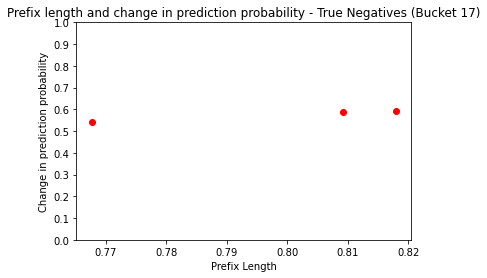

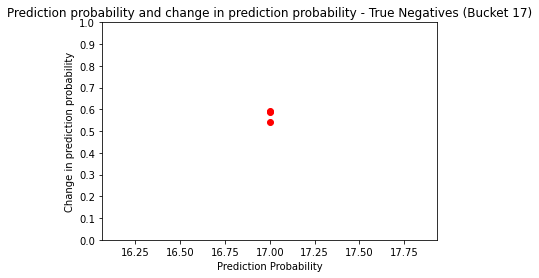

Category 2 of 4. Instance 1 of 4
Creating explanations
[('index__weekday_10', 0.25751555, 0.25751555), ('index__timesincelastevent_7', 0.22513932, 0.22513932), ('index__month_9', -0.22115009, 0.22115009), ('index__hour_5', -0.17814314, 0.17814314), ('index__activity_duration_8', -0.16498986, 0.16498986), ('index__Activity_9_Flat Grinding - Machine 11', -0.15324368, 0.15324368), ('index__month_8', -0.15091659, 0.15091659), ('index__open_cases_10', -0.13735937, 0.13735937), ('index__timesincemidnight_4', -0.13654338, 0.13654338), ('index__timesincemidnight_9', -0.1358906, 0.1358906), ('index__timesincemidnight_1', 0.13435096, 0.13435096), ('index__timesincecasestart_2', 0.13385528, 0.13385528), ('index__activity_duration_14', 0.13336346, 0.13336346), ('index__Qty_Completed_14', 0.12287283, 0.12287283), ('index__timesincemidnight_5', -0.12203739, 0.12203739), ('index__Report_Type_1_S', 0.11817744, 0.11817744), ('index__timesincelastevent_9', 0.1149138, 0.1149138), ('index__timesincemidnig

Creating explanations
[('index__timesincecasestart_2', -0.24362288, 0.24362288), ('index__month_9', -0.21760523, 0.21760523), ('index__timesincecasestart_8', 0.19665605, 0.19665605), ('index__Qty_Completed_8', 0.19261935, 0.19261935), ('static__Work_Order_Qty', 0.16868487, 0.16868487), ('index__timesincecasestart_7', 0.16102941, 0.16102941), ('index__timesincemidnight_1', -0.15699856, 0.15699856), ('index__month_8', -0.15096633, 0.15096633), ('index__timesincelastevent_7', -0.14743851, 0.14743851), ('index__Qty_Completed_14', 0.1416499, 0.1416499), ('index__timesincecasestart_10', 0.13832565, 0.13832565), ('index__Qty_Completed_9', 0.12971611, 0.12971611), ('index__activity_duration_6', -0.1228816, 0.1228816), ('index__activity_duration_7', -0.1172784, 0.1172784), ('index__timesincemidnight_9', 0.108150244, 0.108150244), ('index__activity_duration_8', 0.107374154, 0.107374154), ('index__timesincecasestart_5', 0.10338753, 0.10338753), ('index__timesincemidnight_7', 0.102612585, 0.102612

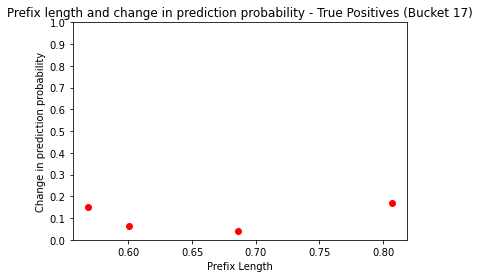

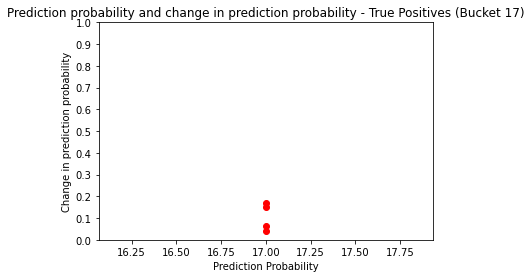

Category 3 of 4. Instance 1 of 1
Creating explanations
[('index__hour_7', -0.26567456, 0.26567456), ('index__timesincecasestart_2', -0.26194715, 0.26194715), ('index__timesincecasestart_8', 0.26005647, 0.26005647), ('index__month_9', -0.22115009, 0.22115009), ('index__timesincemidnight_7', -0.17573489, 0.17573489), ('index__hour_5', -0.16809638, 0.16809638), ('index__timesincecasestart_7', 0.16800255, 0.16800255), ('index__activity_duration_8', -0.1675725, 0.1675725), ('index__activity_duration_10', -0.1585896, 0.1585896), ('index__timesincelastevent_7', -0.14570877, 0.14570877), ('index__timesincecasestart_10', 0.14379221, 0.14379221), ('index__timesincemidnight_4', -0.13785213, 0.13785213), ('index__weekday_10', -0.13206214, 0.13206214), ('index__activity_duration_14', 0.12976982, 0.12976982), ('index__timesincelastevent_12', -0.12962264, 0.12962264), ('index__Report_Type_1_S', 0.12593612, 0.12593612), ('index__Qty_Completed_12', 0.12542136, 0.12542136), ('index__open_cases_10', -0.1

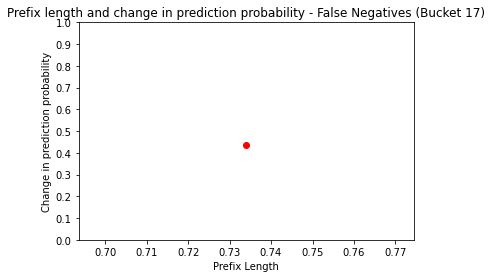

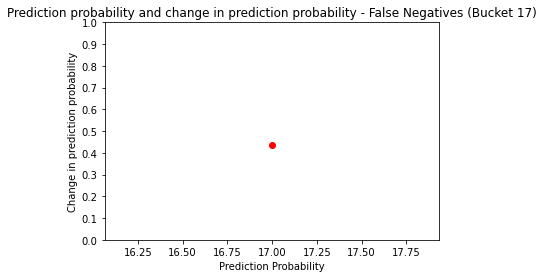

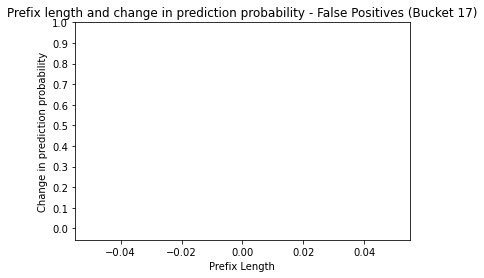

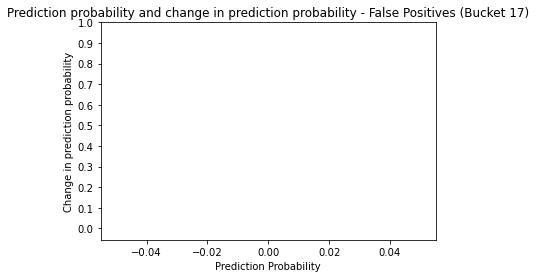

Bucket 18
Generating distributions for bucket
1 of 861 features
2 of 861 features
3 of 861 features
4 of 861 features
5 of 861 features
6 of 861 features
7 of 861 features
8 of 861 features
9 of 861 features
10 of 861 features
11 of 861 features
12 of 861 features
13 of 861 features
14 of 861 features
15 of 861 features
16 of 861 features
17 of 861 features
18 of 861 features
19 of 861 features
20 of 861 features
21 of 861 features
22 of 861 features
23 of 861 features
24 of 861 features
25 of 861 features
26 of 861 features
27 of 861 features
28 of 861 features
29 of 861 features
30 of 861 features
31 of 861 features
32 of 861 features
33 of 861 features
34 of 861 features
35 of 861 features
36 of 861 features
37 of 861 features
38 of 861 features
39 of 861 features
40 of 861 features
41 of 861 features
42 of 861 features
43 of 861 features
44 of 861 features
45 of 861 features
46 of 861 features
47 of 861 features
48 of 861 features
49 of 861 features
50 of 861 features
51 of 861 fea

419 of 861 features
420 of 861 features
421 of 861 features
422 of 861 features
423 of 861 features
424 of 861 features
425 of 861 features
426 of 861 features
427 of 861 features
428 of 861 features
429 of 861 features
430 of 861 features
431 of 861 features
432 of 861 features
433 of 861 features
434 of 861 features
435 of 861 features
436 of 861 features
437 of 861 features
438 of 861 features
439 of 861 features
440 of 861 features
441 of 861 features
442 of 861 features
443 of 861 features
444 of 861 features
445 of 861 features
446 of 861 features
447 of 861 features
448 of 861 features
449 of 861 features
450 of 861 features
451 of 861 features
452 of 861 features
453 of 861 features
454 of 861 features
455 of 861 features
456 of 861 features
457 of 861 features
458 of 861 features
459 of 861 features
460 of 861 features
461 of 861 features
462 of 861 features
463 of 861 features
464 of 861 features
465 of 861 features
466 of 861 features
467 of 861 features
468 of 861 features


Creating explanations
[('index__timesincecasestart_10', 0.34115753, 0.34115753), ('static__Work_Order_Qty', -0.3027505, 0.3027505), ('index__timesincecasestart_6', 0.285563, 0.285563), ('index__timesincecasestart_8', 0.25829843, 0.25829843), ('index__open_cases_10', -0.23235199, 0.23235199), ('index__month_13', -0.1808475, 0.1808475), ('index__activity_duration_4', 0.1800073, 0.1800073), ('index__timesincemidnight_1', -0.1698288, 0.1698288), ('index__Qty_Completed_4', -0.16677824, 0.16677824), ('index__activity_duration_17', 0.1534587, 0.1534587), ('index__open_cases_2', -0.15276554, 0.15276554), ('index__Qty_Completed_12', 0.13913345, 0.13913345), ('index__open_cases_1', -0.13623951, 0.13623951), ('index__Resource_13_ID4385', 0.13607189, 0.13607189), ('index__month_17', -0.13536718, 0.13536718), ('index__timesincecasestart_7', 0.13300338, 0.13300338), ('index__timesincemidnight_4', -0.13049845, 0.13049845), ('index__Qty_Completed_13', -0.122916035, 0.122916035), ('index__activity_dura

Creating explanations
[('static__Work_Order_Qty', -0.30180788, 0.30180788), ('index__open_cases_10', -0.21959315, 0.21959315), ('index__Qty_Completed_4', -0.20571057, 0.20571057), ('index__Activity_14_Round Grinding - Machine 3', 0.19349456, 0.19349456), ('index__month_13', -0.1808475, 0.1808475), ('index__timesincemidnight_4', -0.18006401, 0.18006401), ('index__timesincemidnight_12', 0.17709152, 0.17709152), ('index__activity_duration_6', -0.14892763, 0.14892763), ('index__open_cases_2', -0.14342469, 0.14342469), ('index__timesincecasestart_10', -0.13829292, 0.13829292), ('index__month_17', -0.13536718, 0.13536718), ('index__hour_5', -0.12771729, 0.12771729), ('index__timesincelastevent_14', -0.12728801, 0.12728801), ('index__hour_3', -0.12694484, 0.12694484), ('index__activity_duration_17', 0.1244034, 0.1244034), ('index__open_cases_12', -0.11427205, 0.11427205), ('index__hour_12', 0.11227253, 0.11227253), ('index__timesincemidnight_8', -0.111734375, 0.111734375), ('index__hour_4', -

Creating explanations
[('static__Work_Order_Qty', -0.24199583, 0.24199583), ('index__open_cases_10', -0.21618104, 0.21618104), ('index__hour_13', -0.19990097, 0.19990097), ('index__timesincemidnight_4', -0.19967, 0.19967), ('index__month_13', -0.18388605, 0.18388605), ('index__timesincemidnight_1', -0.18335861, 0.18335861), ('index__activity_duration_17', -0.17697985, 0.17697985), ('index__activity_duration_6', -0.1489804, 0.1489804), ('index__Resource.1_7_Quality Check 1', -0.13884674, 0.13884674), ('index__month_17', -0.13579997, 0.13579997), ('index__timesincecasestart_10', -0.13366887, 0.13366887), ('index__Qty_Completed_12', -0.12643905, 0.12643905), ('index__timesincecasestart_1', -0.12514369, 0.12514369), ('index__Resource.1_15_Quality Check 1', 0.1231889, 0.1231889), ('index__timesincecasestart_8', -0.12222967, 0.12222967), ('index__open_cases_12', -0.11427205, 0.11427205), ('index__hour_5', -0.11294733, 0.11294733), ('index__Qty_Completed_3', -0.11057292, 0.11057292), ('index_

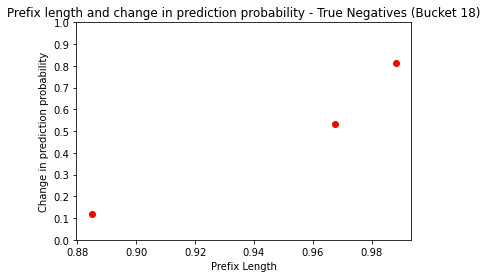

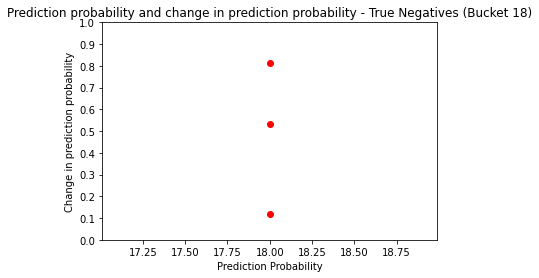

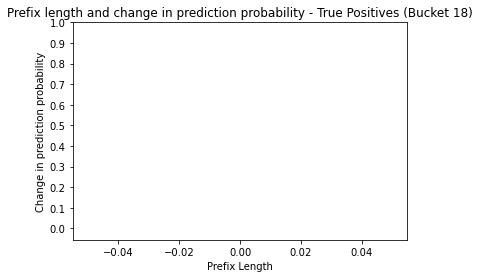

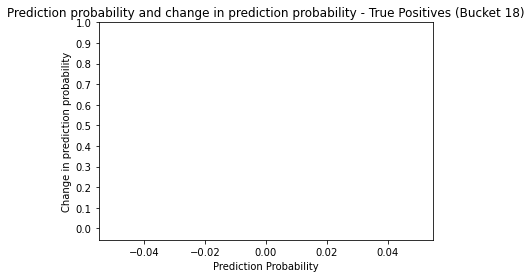

Category 3 of 4. Instance 1 of 3
Creating explanations
[('index__timesincemidnight_4', 0.26581898, 0.26581898), ('index__activity_duration_17', -0.22935049, 0.22935049), ('index__timesincemidnight_7', -0.22395225, 0.22395225), ('index__open_cases_10', -0.20518732, 0.20518732), ('index__activity_duration_6', -0.18545264, 0.18545264), ('index__month_13', -0.17740546, 0.17740546), ('static__Work_Order_Qty', 0.16541152, 0.16541152), ('index__hour_7', -0.14767355, 0.14767355), ('index__Resource.1_15_Quality Check 1', 0.14158142, 0.14158142), ('index__Qty_Completed_12', 0.13826424, 0.13826424), ('index__month_17', -0.13536718, 0.13536718), ('index__timesincemidnight_16', -0.13371065, 0.13371065), ('index__timesincecasestart_7', 0.13300338, 0.13300338), ('index__timesincecasestart_10', -0.13180101, 0.13180101), ('index__open_cases_12', -0.11427205, 0.11427205), ('index__Qty_Completed_13', 0.10472623, 0.10472623), ('index__hour_13', 0.09981576, 0.09981576), ('index__Qty_Completed_9', -0.098879

Category 3 of 4. Instance 2 of 3
Creating explanations
[('index__timesincecasestart_10', 0.3638518, 0.3638518), ('index__timesincecasestart_8', 0.25829843, 0.25829843), ('index__open_cases_10', -0.23561154, 0.23561154), ('index__timesincecasestart_6', 0.20344019, 0.20344019), ('index__month_13', -0.17538072, 0.17538072), ('index__Qty_Completed_4', -0.17266585, 0.17266585), ('index__Qty_Completed_12', 0.17130144, 0.17130144), ('index__timesincemidnight_7', -0.16641001, 0.16641001), ('static__Work_Order_Qty', 0.15683477, 0.15683477), ('index__Resource_11_ID4794', 0.156367, 0.156367), ('index__activity_duration_6', -0.15065019, 0.15065019), ('index__hour_7', -0.14646028, 0.14646028), ('index__open_cases_2', -0.14342469, 0.14342469), ('index__open_cases_1', -0.13892683, 0.13892683), ('index__activity_duration_4', 0.13777928, 0.13777928), ('index__timesincecasestart_7', 0.13300338, 0.13300338), ('index__hour_5', -0.1285816, 0.1285816), ('index__timesincemidnight_4', -0.12314171, 0.12314171)

Creating explanations
[('index__timesincecasestart_6', 0.2662053, 0.2662053), ('index__timesincecasestart_8', 0.25081843, 0.25081843), ('index__open_cases_10', -0.21618104, 0.21618104), ('index__timesincemidnight_4', 0.19250879, 0.19250879), ('index__timesincemidnight_1', -0.18724726, 0.18724726), ('index__month_13', -0.17740546, 0.17740546), ('index__timesincecasestart_10', -0.15445521, 0.15445521), ('index__activity_duration_6', -0.14773299, 0.14773299), ('index__hour_7', -0.14646028, 0.14646028), ('index__open_cases_2', -0.13821137, 0.13821137), ('index__month_17', -0.13579997, 0.13579997), ('index__timesincecasestart_7', 0.13300338, 0.13300338), ('index__open_cases_1', -0.13253872, 0.13253872), ('index__Qty_Completed_12', -0.13025503, 0.13025503), ('index__activity_duration_13', -0.12572126, 0.12572126), ('index__activity_duration_17', 0.11843835, 0.11843835), ('static__Work_Order_Qty', 0.11738914, 0.11738914), ('index__month_14', -0.115323715, 0.115323715), ('index__hour_10', 0.10

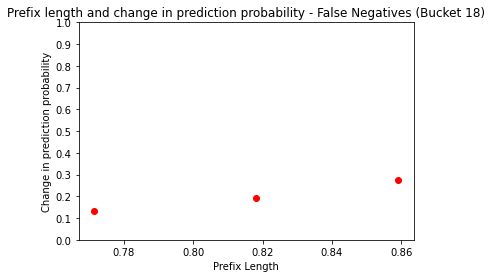

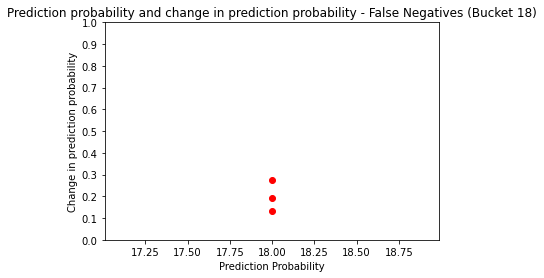

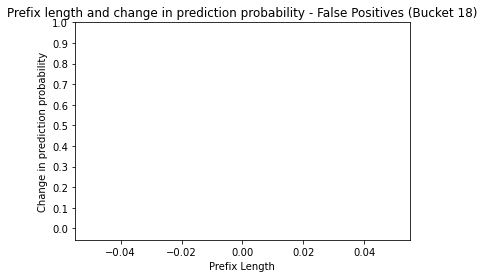

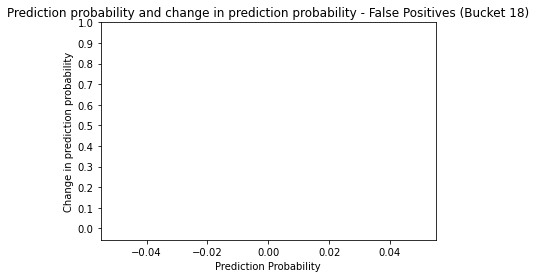

Bucket 19
Generating distributions for bucket
1 of 890 features
2 of 890 features
3 of 890 features
4 of 890 features
5 of 890 features
6 of 890 features
7 of 890 features
8 of 890 features
9 of 890 features
10 of 890 features
11 of 890 features
12 of 890 features
13 of 890 features
14 of 890 features
15 of 890 features
16 of 890 features
17 of 890 features
18 of 890 features
19 of 890 features
20 of 890 features
21 of 890 features
22 of 890 features
23 of 890 features
24 of 890 features
25 of 890 features
26 of 890 features
27 of 890 features
28 of 890 features
29 of 890 features
30 of 890 features
31 of 890 features
32 of 890 features
33 of 890 features
34 of 890 features
35 of 890 features
36 of 890 features
37 of 890 features
38 of 890 features
39 of 890 features
40 of 890 features
41 of 890 features
42 of 890 features
43 of 890 features
44 of 890 features
45 of 890 features
46 of 890 features
47 of 890 features
48 of 890 features
49 of 890 features
50 of 890 features
51 of 890 fea

443 of 890 features
444 of 890 features
445 of 890 features
446 of 890 features
447 of 890 features
448 of 890 features
449 of 890 features
450 of 890 features
451 of 890 features
452 of 890 features
453 of 890 features
454 of 890 features
455 of 890 features
456 of 890 features
457 of 890 features
458 of 890 features
459 of 890 features
460 of 890 features
461 of 890 features
462 of 890 features
463 of 890 features
464 of 890 features
465 of 890 features
466 of 890 features
467 of 890 features
468 of 890 features
469 of 890 features
470 of 890 features
471 of 890 features
472 of 890 features
473 of 890 features
474 of 890 features
475 of 890 features
476 of 890 features
477 of 890 features
478 of 890 features
479 of 890 features
480 of 890 features
481 of 890 features
482 of 890 features
483 of 890 features
484 of 890 features
485 of 890 features
486 of 890 features
487 of 890 features
488 of 890 features
489 of 890 features
490 of 890 features
491 of 890 features
492 of 890 features


Creating explanations
[('index__timesincecasestart_10', 0.23475699, 0.23475699), ('index__timesincemidnight_1', -0.21707472, 0.21707472), ('index__timesincecasestart_6', 0.20310055, 0.20310055), ('index__timesincelastevent_10', 0.20176329, 0.20176329), ('index__Qty_Completed_4', -0.19547401, 0.19547401), ('index__Activity_8_Turning & Milling - Machine 5', 0.18709248, 0.18709248), ('index__Qty_Completed_12', 0.18663777, 0.18663777), ('index__Qty_Completed_13', -0.16731112, 0.16731112), ('index__activity_duration_17', 0.15965177, 0.15965177), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__timesincemidnight_5', 0.14140287, 0.14140287), ('index__timesincecasestart_5', -0.13396285, 0.13396285), ('index__month_4', -0.13327084, 0.13327084), ('index__timesincecasestart_7', 0.13187975, 0.13187975), ('index__timesincelastevent_7', -0.1288158, 0.1288158), ('index__Resource.1_12_Machine 1 - Lapping', -0.11871897, 0.11871897), ('index__open_cases_11', 0.116750054, 0.116750054), ('

Creating explanations
[('index__Resource_14_ID4882', -0.21671581, 0.21671581), ('index__activity_duration_7', -0.21394996, 0.21394996), ('index__activity_duration_17', -0.20617701, 0.20617701), ('index__timesincemidnight_1', -0.17855507, 0.17855507), ('index__month_4', -0.17815645, 0.17815645), ('index__Activity_8_Flat Grinding - Machine 11', -0.1680213, 0.1680213), ('index__Qty_Completed_12', -0.15615936, 0.15615936), ('index__Resource.1_5_Quality Check 1', -0.15379383, 0.15379383), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__activity_duration_13', -0.14953917, 0.14953917), ('index__Resource_0_ID4429', 0.1313141, 0.1313141), ('index__timesincemidnight_5', 0.12997983, 0.12997983), ('index__timesincelastevent_7', -0.1288158, 0.1288158), ('index__timesincecasestart_6', -0.1256841, 0.1256841), ('index__activity_duration_18', -0.12534405, 0.12534405), ('index__open_cases_11', 0.11670849, 0.11670849), ('index__hour_2', -0.11299421, 0.11299421), ('index__open_cases_2', -

Creating explanations
[('index__Qty_Completed_4', -0.24438074, 0.24438074), ('index__timesincemidnight_1', -0.23107854, 0.23107854), ('index__timesincemidnight_18', 0.22491391, 0.22491391), ('index__activity_duration_7', -0.20697534, 0.20697534), ('index__Qty_Completed_12', -0.19115998, 0.19115998), ('index__month_4', -0.17815645, 0.17815645), ('index__timesincelastevent_7', -0.15782596, 0.15782596), ('index__Resource.1_5_Quality Check 1', -0.1573875, 0.1573875), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__activity_duration_13', -0.14953917, 0.14953917), ('index__hour_18', 0.13072877, 0.13072877), ('index__activity_duration_17', -0.12986231, 0.12986231), ('index__timesincecasestart_6', -0.12629516, 0.12629516), ('static__Part_Desc__Piston', -0.11924845, 0.11924845), ('index__open_cases_11', 0.116750054, 0.116750054), ('index__hour_2', -0.11299421, 0.11299421), ('index__open_cases_0', 0.11200241, 0.11200241), ('index__Qty_Completed_9', -0.11034909, 0.11034909), ('in

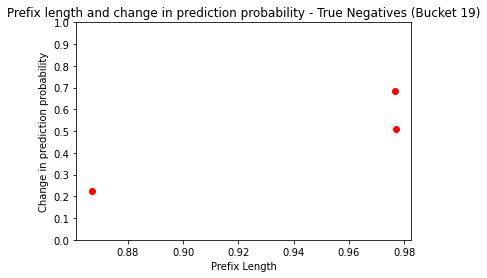

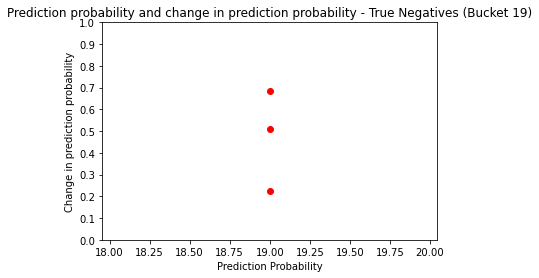

Category 2 of 4. Instance 1 of 1
Creating explanations
[('index__timesincecasestart_10', 0.22940063, 0.22940063), ('index__activity_duration_17', 0.21159667, 0.21159667), ('index__Qty_Completed_12', 0.20978849, 0.20978849), ('index__Qty_Completed_4', -0.2035591, 0.2035591), ('index__timesincelastevent_10', 0.19428428, 0.19428428), ('index__timesincecasestart_6', 0.193755, 0.193755), ('index__timesincemidnight_18', 0.1508337, 0.1508337), ('index__Report_Type_1_S', 0.14616746, 0.14616746), ('index__hour_16', -0.14271599, 0.14271599), ('index__timesincecasestart_4', -0.14079833, 0.14079833), ('index__timesincecasestart_11', 0.13941802, 0.13941802), ('index__timesincelastevent_7', -0.13530284, 0.13530284), ('index__month_4', -0.13327084, 0.13327084), ('index__timesincemidnight_1', 0.12749836, 0.12749836), ('index__hour_18', 0.12654313, 0.12654313), ('index__activity_duration_7', 0.12497176, 0.12497176), ('index__open_cases_10', -0.12349385, 0.12349385), ('index__timesincemidnight_15', -0.1

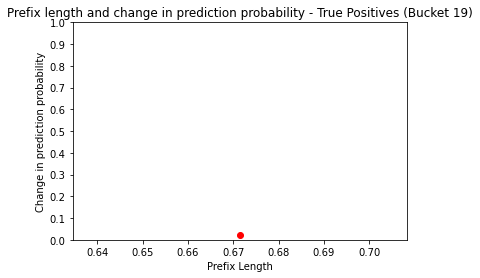

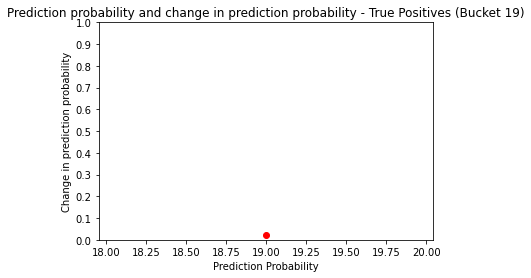

Category 3 of 4. Instance 1 of 3
Creating explanations
[('index__activity_duration_17', -0.28374758, 0.28374758), ('index__Qty_Completed_18', 0.24776566, 0.24776566), ('index__activity_duration_6', -0.24150468, 0.24150468), ('index__timesincemidnight_18', 0.2164122, 0.2164122), ('index__activity_duration_7', -0.20809841, 0.20809841), ('index__timesincemidnight_5', 0.18561575, 0.18561575), ('index__month_4', -0.17815645, 0.17815645), ('index__Activity_6_Turning & Milling Q.C.', 0.1575475, 0.1575475), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__open_cases_0', 0.1493708, 0.1493708), ('index__hour_18', 0.12654313, 0.12654313), ('index__timesincelastevent_7', -0.12383611, 0.12383611), ('index__Activity_13_Turning & Milling - Machine 4', -0.11168691, 0.11168691), ('index__Qty_Completed_9', -0.11034909, 0.11034909), ('index__open_cases_10', -0.10702355, 0.10702355), ('index__activity_duration_18', 0.10629372, 0.10629372), ('index__hour_2', -0.10530529, 0.10530529), ('inde

Creating explanations
[('index__timesincemidnight_1', -0.23175177, 0.23175177), ('index__Resource_14_ID4882', -0.21671581, 0.21671581), ('index__timesincecasestart_6', 0.1945702, 0.1945702), ('index__hour_16', 0.18618545, 0.18618545), ('index__timesincemidnight_18', 0.16309005, 0.16309005), ('index__activity_duration_13', -0.15930614, 0.15930614), ('index__Qty_Completed_12', -0.15615936, 0.15615936), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__timesincelastevent_5', 0.13540989, 0.13540989), ('index__hour_18', 0.1342732, 0.1342732), ('index__month_4', -0.13327084, 0.13327084), ('index__activity_duration_2', -0.13253598, 0.13253598), ('index__timesincelastevent_7', -0.13155805, 0.13155805), ('index__open_cases_11', 0.116750054, 0.116750054), ('index__hour_2', -0.11406103, 0.11406103), ('index__activity_duration_15', -0.11139562, 0.11139562), ('index__timesincelastevent_16', -0.11039367, 0.11039367), ('index__Qty_Completed_9', -0.11034909, 0.11034909), ('index__open_c

Creating explanations
[('index__activity_duration_17', -0.28374758, 0.28374758), ('index__Qty_Completed_4', -0.22678712, 0.22678712), ('index__activity_duration_7', -0.20955527, 0.20955527), ('index__Qty_Completed_12', -0.19115998, 0.19115998), ('index__timesincecasestart_6', 0.1888615, 0.1888615), ('index__Activity_8_Flat Grinding - Machine 11', -0.16663733, 0.16663733), ('index__Resource_1_ID4529', 0.16564536, 0.16564536), ('index__Resource.1_5_Quality Check 1', -0.1573875, 0.1573875), ('index__Qty_Completed_11', 0.15508747, 0.15508747), ('index__timesincecasestart_4', -0.1497764, 0.1497764), ('index__activity_duration_13', -0.14682615, 0.14682615), ('index__month_4', -0.13327084, 0.13327084), ('index__timesincecasestart_5', -0.13287763, 0.13287763), ('index__timesincelastevent_7', 0.123143494, 0.123143494), ('index__hour_2', -0.11436579, 0.11436579), ('index__timesincemidnight_18', -0.112503186, 0.112503186), ('index__activity_duration_16', 0.112288676, 0.112288676), ('index__Report

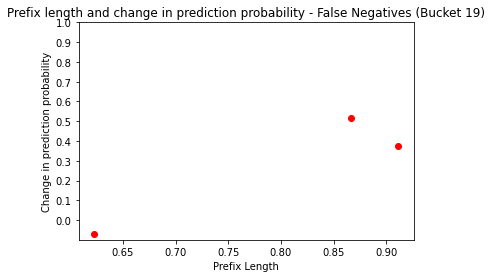

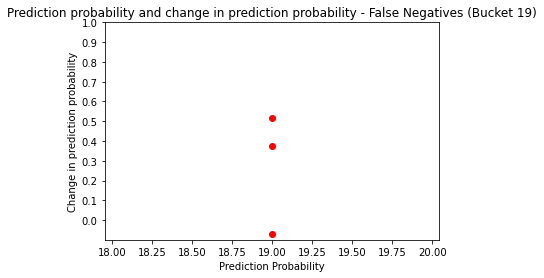

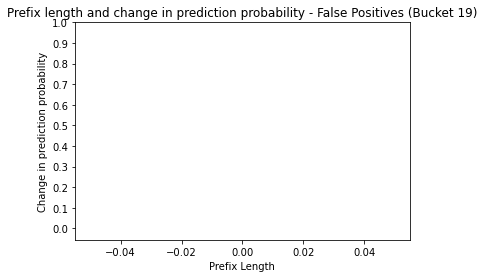

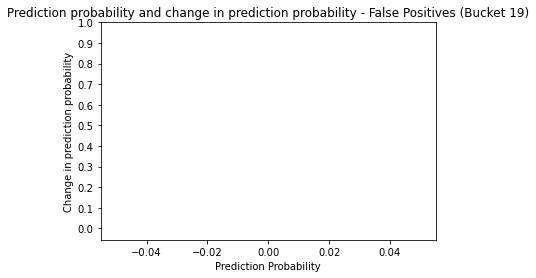

Bucket 20
Generating distributions for bucket
1 of 844 features
2 of 844 features
3 of 844 features
4 of 844 features
5 of 844 features
6 of 844 features
7 of 844 features
8 of 844 features
9 of 844 features
10 of 844 features
11 of 844 features
12 of 844 features
13 of 844 features
14 of 844 features
15 of 844 features
16 of 844 features
17 of 844 features
18 of 844 features
19 of 844 features
20 of 844 features
21 of 844 features
22 of 844 features
23 of 844 features
24 of 844 features
25 of 844 features
26 of 844 features
27 of 844 features
28 of 844 features
29 of 844 features
30 of 844 features
31 of 844 features
32 of 844 features
33 of 844 features
34 of 844 features
35 of 844 features
36 of 844 features
37 of 844 features
38 of 844 features
39 of 844 features
40 of 844 features
41 of 844 features
42 of 844 features
43 of 844 features
44 of 844 features
45 of 844 features
46 of 844 features
47 of 844 features
48 of 844 features
49 of 844 features
50 of 844 features
51 of 844 fea

454 of 844 features
455 of 844 features
456 of 844 features
457 of 844 features
458 of 844 features
459 of 844 features
460 of 844 features
461 of 844 features
462 of 844 features
463 of 844 features
464 of 844 features
465 of 844 features
466 of 844 features
467 of 844 features
468 of 844 features
469 of 844 features
470 of 844 features
471 of 844 features
472 of 844 features
473 of 844 features
474 of 844 features
475 of 844 features
476 of 844 features
477 of 844 features
478 of 844 features
479 of 844 features
480 of 844 features
481 of 844 features
482 of 844 features
483 of 844 features
484 of 844 features
485 of 844 features
486 of 844 features
487 of 844 features
488 of 844 features
489 of 844 features
490 of 844 features
491 of 844 features
492 of 844 features
493 of 844 features
494 of 844 features
495 of 844 features
496 of 844 features
497 of 844 features
498 of 844 features
499 of 844 features
500 of 844 features
501 of 844 features
502 of 844 features
503 of 844 features


Creating explanations
[('index__timesincemidnight_10', -0.25094417, 0.25094417), ('index__activity_duration_11', 0.22903126, 0.22903126), ('index__Report_Type_1_D', 0.19426699, 0.19426699), ('index__weekday_19', 0.1844734, 0.1844734), ('index__Qty_Completed_1', 0.1510553, 0.1510553), ('index__timesincemidnight_1', -0.14896514, 0.14896514), ('index__Qty_Completed_13', 0.14793569, 0.14793569), ('index__month_4', -0.13387138, 0.13387138), ('index__weekday_2', -0.13210776, 0.13210776), ('index__Qty_Completed_9', -0.13098949, 0.13098949), ('index__timesincemidnight_14', -0.119125456, 0.119125456), ('index__timesincelastevent_4', -0.117870286, 0.117870286), ('index__activity_duration_19', -0.11718409, 0.11718409), ('index__Resource.1_5_Quality Check 1', -0.11293778, 0.11293778), ('index__timesincecasestart_5', -0.112131596, 0.112131596), ('index__Resource_16_ID4287', 0.11048405, 0.11048405), ('index__timesincelastevent_15', -0.1079127, 0.1079127), ('index__Report_Type_1_S', 0.10787287, 0.107

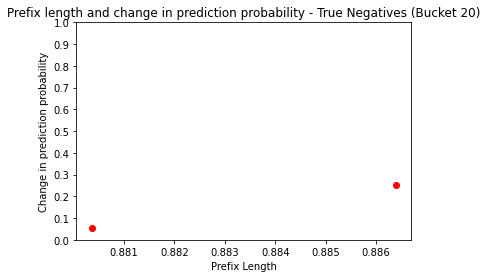

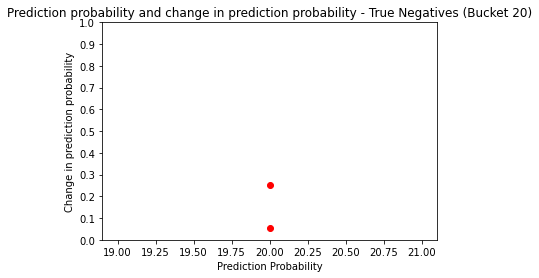

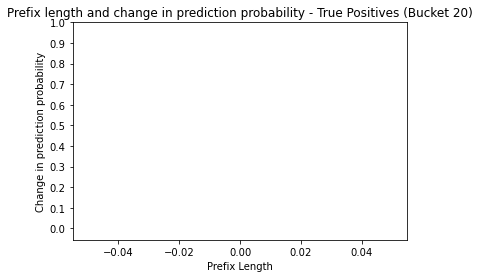

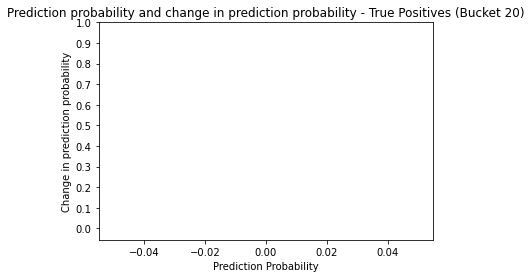

Category 3 of 4. Instance 1 of 3
Creating explanations
[('index__Qty_Completed_3', 0.23550177, 0.23550177), ('index__timesincemidnight_10', 0.21893084, 0.21893084), ('index__Report_Type_1_D', 0.19426699, 0.19426699), ('index__timesincecasestart_5', 0.18349235, 0.18349235), ('index__activity_duration_3', -0.163072, 0.163072), ('index__weekday_19', 0.15772103, 0.15772103), ('index__timesincemidnight_1', -0.15367956, 0.15367956), ('index__Qty_Completed_1', 0.1510553, 0.1510553), ('index__hour_5', -0.1484555, 0.1484555), ('index__Qty_Completed_13', 0.13818984, 0.13818984), ('index__month_4', -0.13387138, 0.13387138), ('index__open_cases_9', -0.123640515, 0.123640515), ('index__timesincemidnight_11', 0.11479295, 0.11479295), ('index__Qty_Completed_18', -0.11476312, 0.11476312), ('index__timesincecasestart_6', 0.112029135, 0.112029135), ('index__activity_duration_11', -0.110895835, 0.110895835), ('index__activity_duration_19', 0.108423464, 0.108423464), ('index__Report_Type_1_S', 0.10787287,

Creating explanations
[('index__Qty_Completed_3', 0.26378834, 0.26378834), ('index__timesincemidnight_10', 0.2467582, 0.2467582), ('index__timesincecasestart_13', 0.1983698, 0.1983698), ('index__Report_Type_1_D', 0.19426699, 0.19426699), ('index__timesincecasestart_5', 0.18880184, 0.18880184), ('index__activity_duration_11', 0.1842868, 0.1842868), ('index__activity_duration_19', -0.16589001, 0.16589001), ('index__activity_duration_3', -0.163072, 0.163072), ('index__hour_5', -0.16169174, 0.16169174), ('index__Qty_Completed_4', -0.15565927, 0.15565927), ('index__hour_3', -0.14673582, 0.14673582), ('index__timesincemidnight_1', -0.14541888, 0.14541888), ('index__timesincelastevent_10', 0.13452232, 0.13452232), ('index__month_4', -0.13387138, 0.13387138), ('index__timesincecasestart_6', 0.13315257, 0.13315257), ('index__Qty_Completed_9', -0.1179398, 0.1179398), ('index__timesincelastevent_4', -0.117870286, 0.117870286), ('index__weekday_2', 0.11159671, 0.11159671), ('index__Qty_Completed_1

Creating explanations
[('index__hour_5', 0.28678024, 0.28678024), ('index__weekday_19', -0.28116456, 0.28116456), ('index__timesincemidnight_10', -0.25356022, 0.25356022), ('index__activity_duration_11', 0.23521627, 0.23521627), ('index__timesincemidnight_1', 0.18362087, 0.18362087), ('index__activity_duration_19', -0.15050626, 0.15050626), ('index__Qty_Completed_3', -0.14915028, 0.14915028), ('index__Report_Type_1_D', -0.14244092, 0.14244092), ('index__Qty_Completed_18', 0.14223886, 0.14223886), ('index__Qty_Completed_13', 0.1399888, 0.1399888), ('index__month_4', -0.13387138, 0.13387138), ('index__activity_duration_3', -0.12371759, 0.12371759), ('index__open_cases_9', -0.123640515, 0.123640515), ('index__Qty_Completed_9', -0.12193842, 0.12193842), ('index__timesincelastevent_4', -0.117870286, 0.117870286), ('index__timesincemidnight_14', -0.11565411, 0.11565411), ('index__Activity_6_Turning & Milling Q.C.', 0.1123602, 0.1123602), ('index__Resource.1_15_Quality Check 1', 0.1106864, 0.

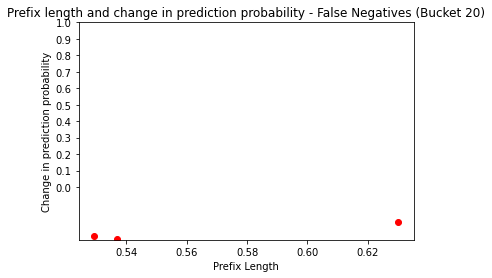

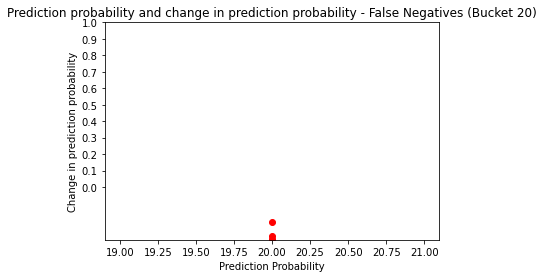

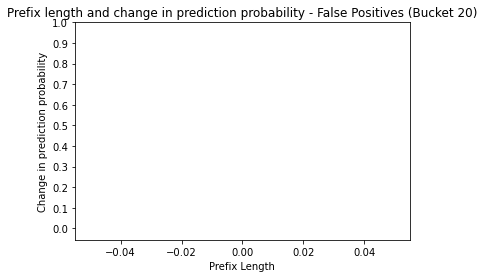

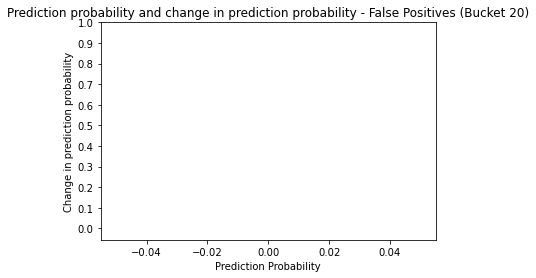

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)
                        print(rel_exp[0])

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][0]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

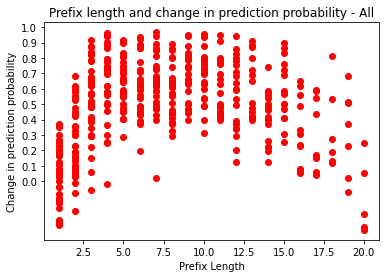

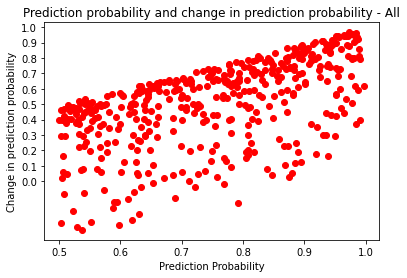

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

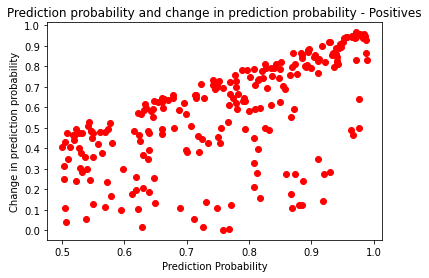

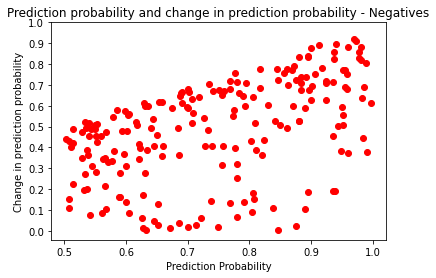

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pert

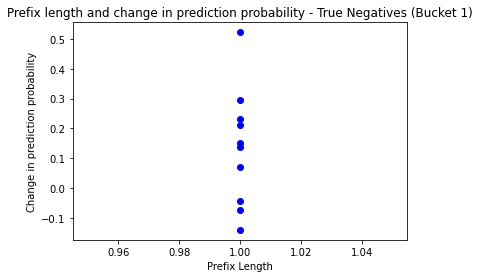

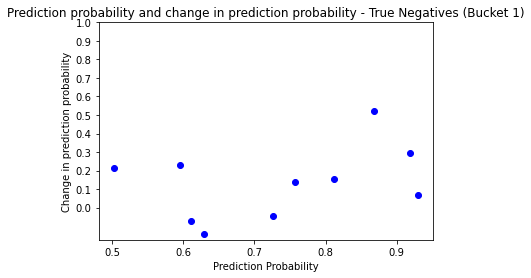

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - R

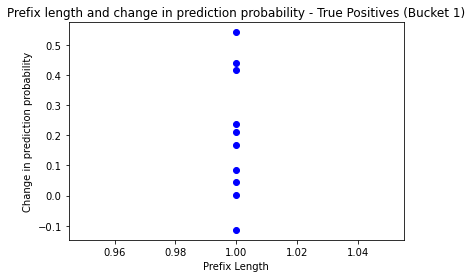

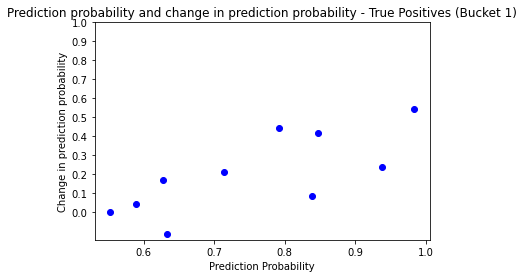

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run

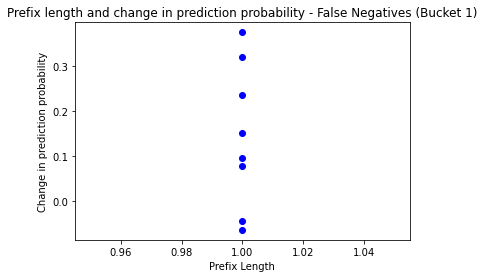

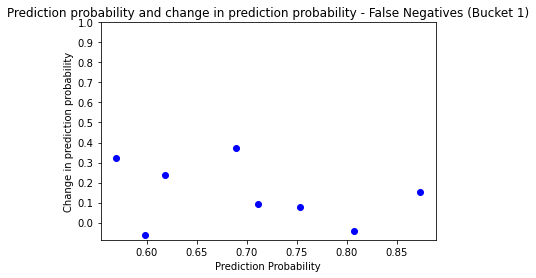

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run

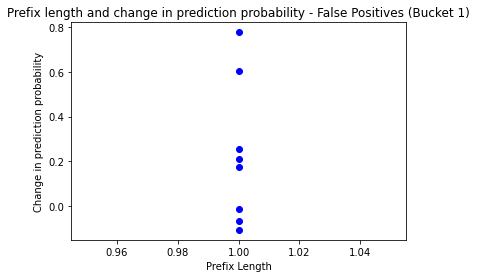

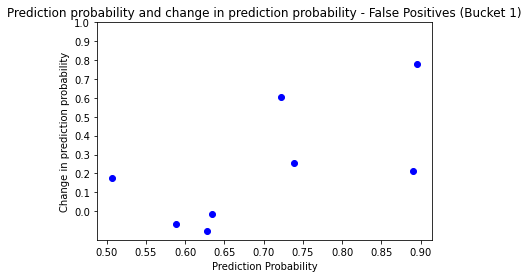

Bucket 2
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distri

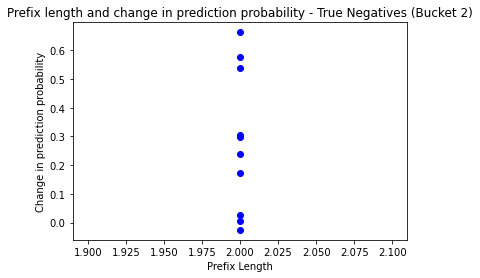

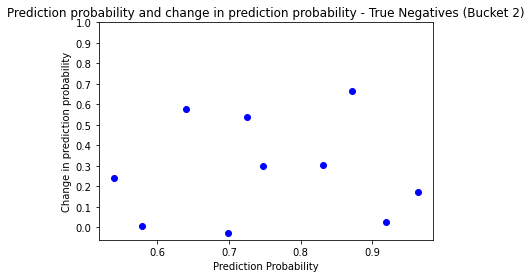

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution fo

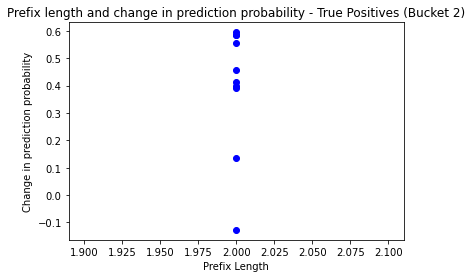

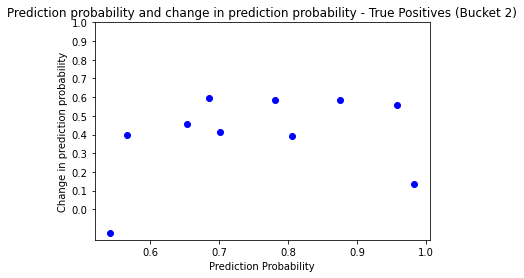

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for 

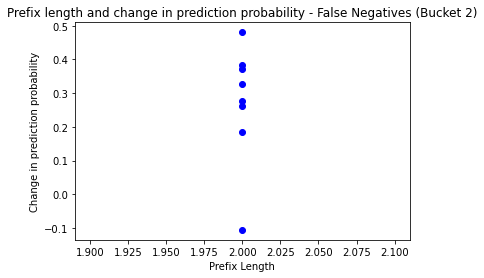

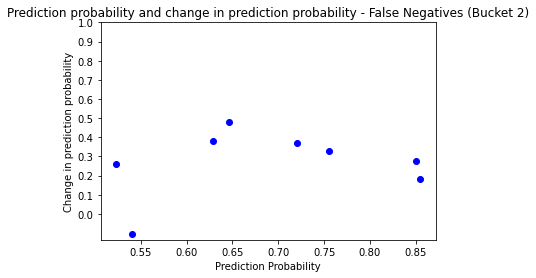

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for 

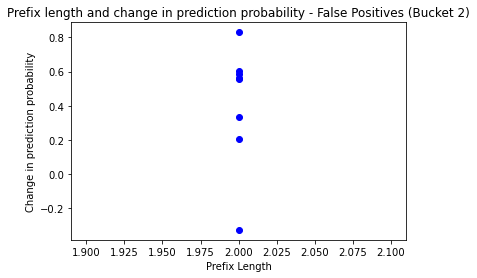

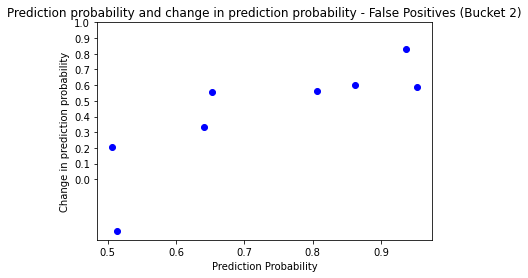

Bucket 3
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertub

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

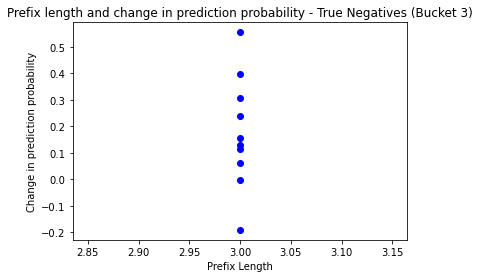

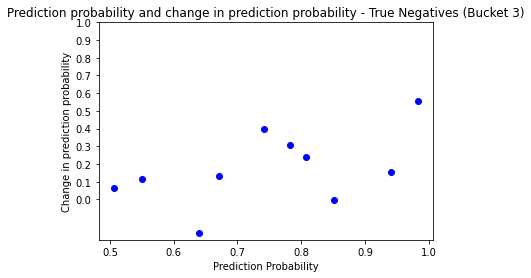

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

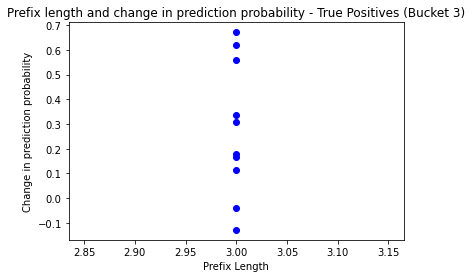

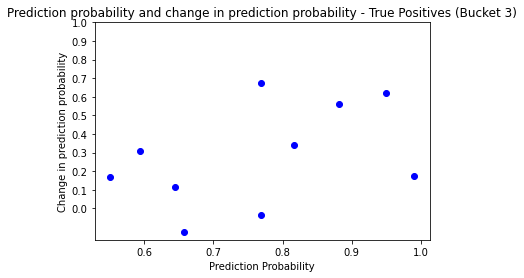

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

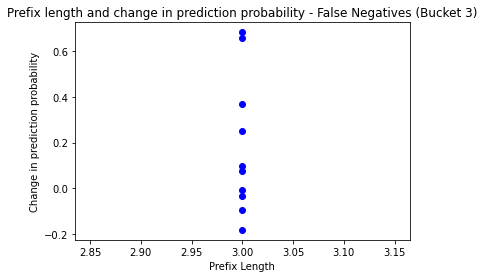

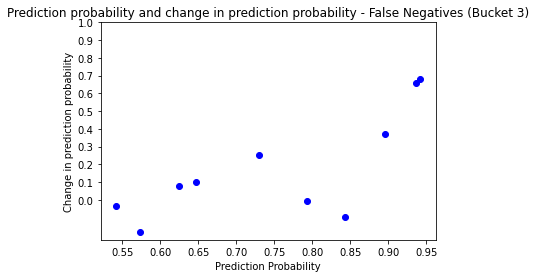

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - R

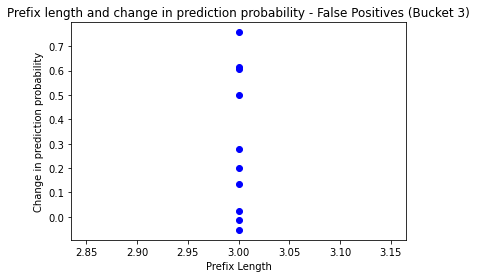

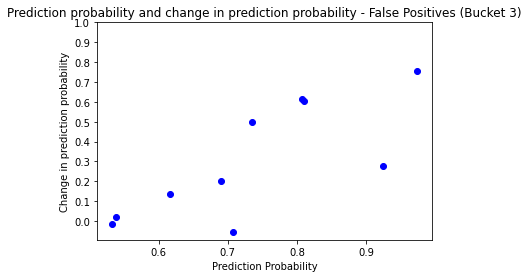

Bucket 4
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

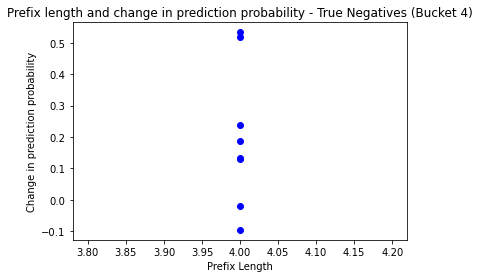

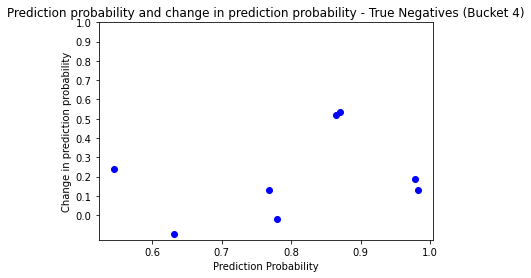

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

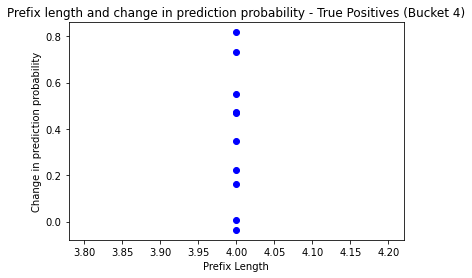

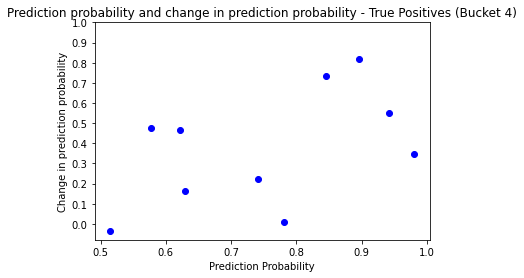

Category 3 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

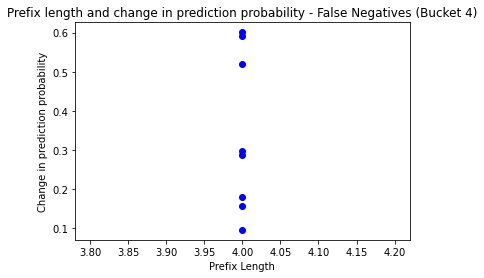

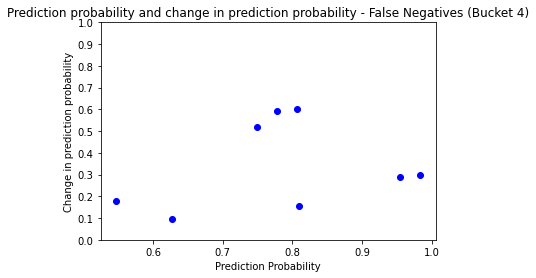

Category 4 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

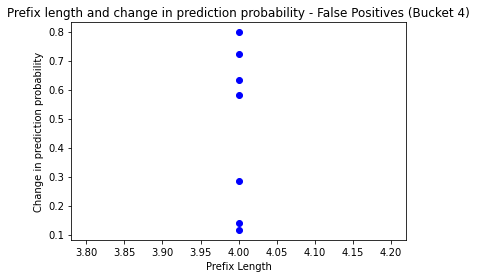

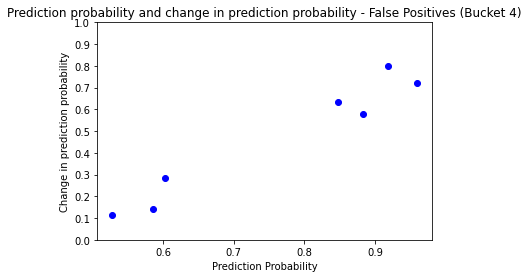

Bucket 5
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

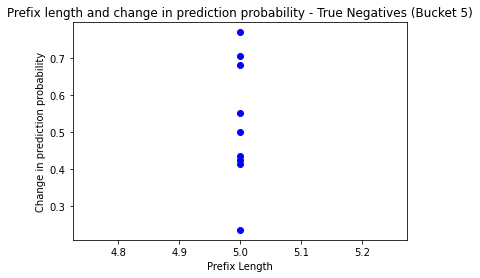

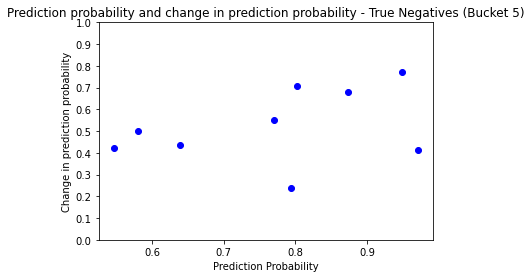

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

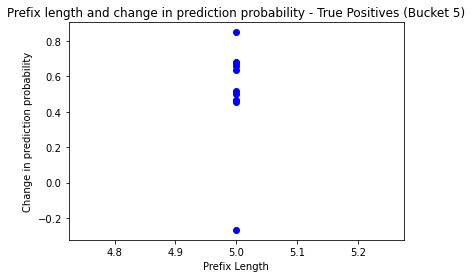

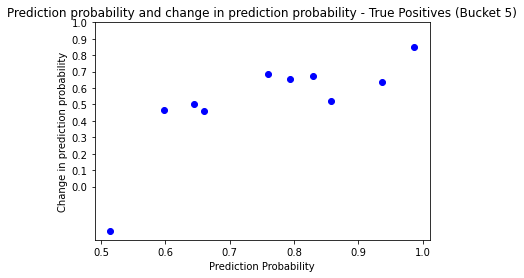

Category 3 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

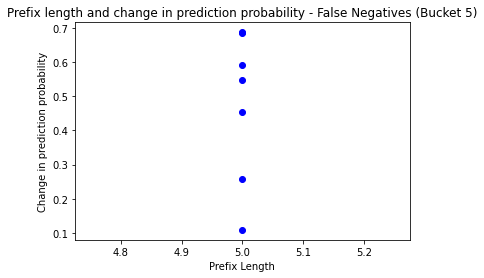

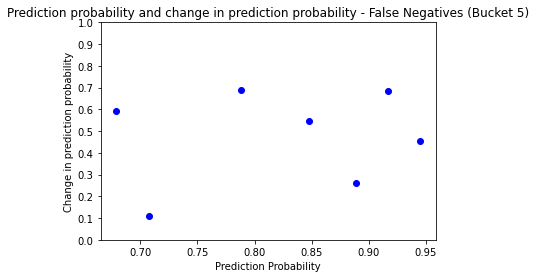

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

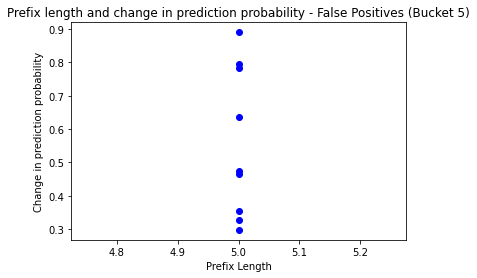

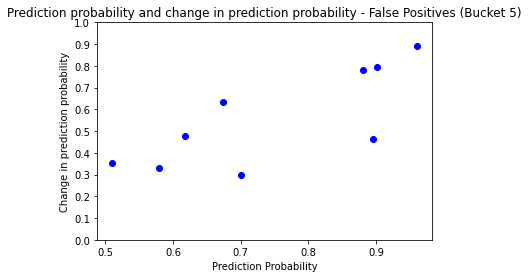

Bucket 6
Category 1 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

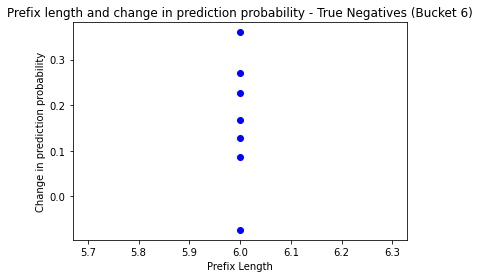

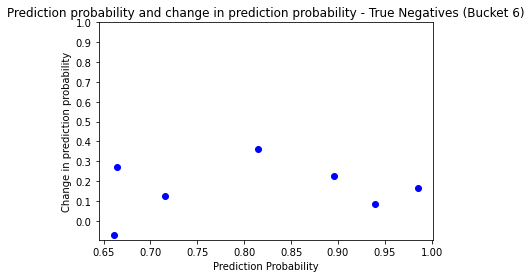

Category 2 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

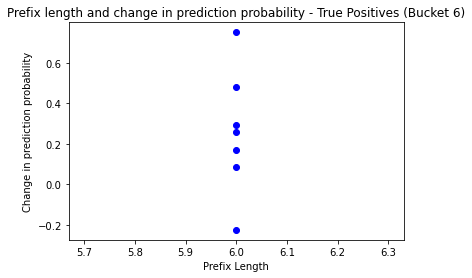

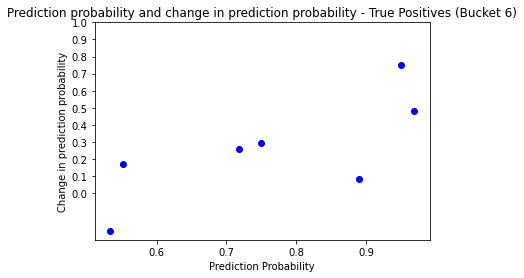

Category 3 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

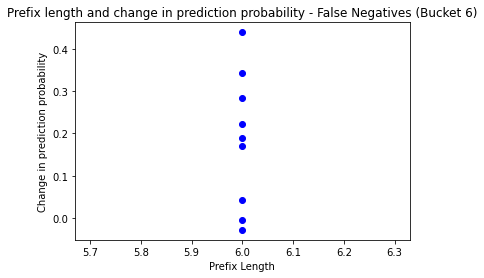

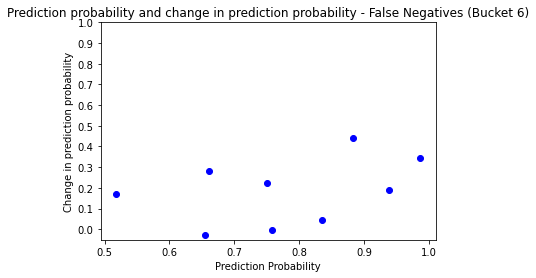

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

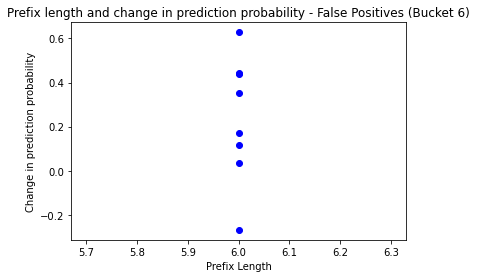

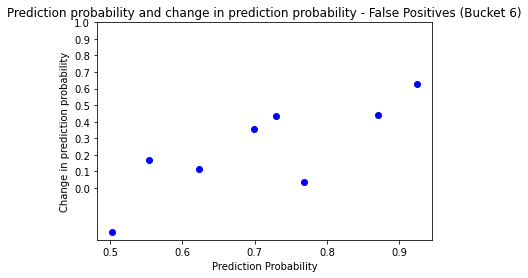

Bucket 7
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

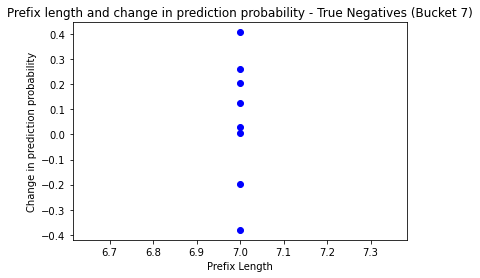

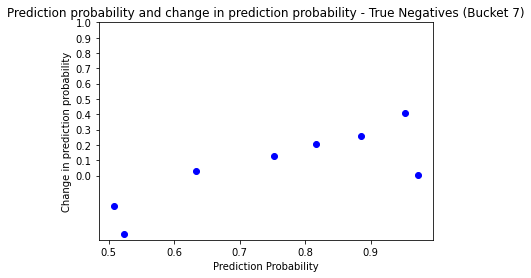

Category 2 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

In [ ]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][0]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [ ]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

In [ ]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))